In [1]:
import torch
torch.__version__

'2.5.1+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import numpy as np
import pandas as pd
import csv
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
import os
from tqdm import tqdm
from sklearn.metrics import f1_score
import random
import gc

In [4]:
# Set seed for reproducibility
SEED = 123
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Load Data

In [5]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixels'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(10),     # Randomly rotate by 10 degrees
    transforms.RandomResizedCrop(
        size=IMG_SIZE,  # Output size
        scale=(0.8, 1.0)  # Range of the random crop size relative to the input size
    ),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
]) 

# Create transform pipeline manually
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

 
print(f"train transforms: {train_transforms}")
print(f"test transforms: {test_transforms}")

train transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)
test transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)


In [7]:
data = pd.read_csv('../Data/fer2013_clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33325 entries, 0 to 33324
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pixels   33325 non-null  object
 1   emotion  33325 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 520.8+ KB


In [8]:
# pisahkan data train (80%), validation (10%), test (10%)
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=123)
data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=123)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26992
Validation set size: 3000
Test set size: 3333


In [9]:
train_dataset = FERDataset(data_train, transform=train_transforms)
val_dataset = FERDataset(data_val, transform=test_transforms)
test_dataset = FERDataset(data_test, transform=test_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [10]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Mapping dari label ke ID (label2id)
label2id = {c: idx for idx, c in enumerate(labels)}

# Mapping dari ID ke label (id2label)
id2label = {idx: c for idx, c in enumerate(labels)}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}
id2label: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


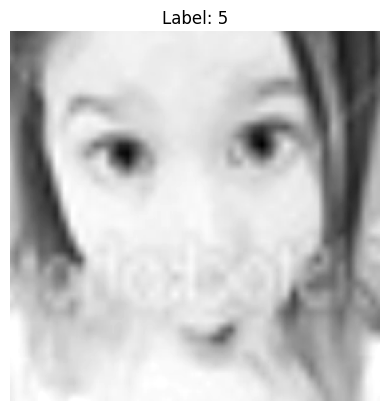

In [11]:
# Ambil satu contoh dari train_dataset
image, label = train_dataset[0]  # Index pertama dataset

# Jika transform menghasilkan tensor, konversi ke format numpy
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Plot gambar
plt.imshow(image, cmap='gray')  # Gunakan cmap='gray' jika gambar grayscale
plt.title(f"Label: {label}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

In [12]:
image, label = train_dataset[0]
image.shape

torch.Size([1, 224, 224])

## Build Vision Transformer (ViT) Model

In [13]:
from torch import nn

In [14]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=768
                ):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    def forward(self, x):
        image_resolution = x.shape[-1]
        
        x_patched = self.patcher(x) # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x_flattened = x_patched.flatten(2) # (n_samples, embed_dim, n_patches)
        x = x_flattened.transpose(1, 2) # (n_samples, n_patches, embed_dim)
        
        return x

In [15]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [16]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

In [17]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(self.layer_norm1(x)) + x 
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x

In [18]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.,
                 mlp_dropout:float=0.,
                 embedding_dropout:float=0.,
                 num_classes:int=1000):
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, pixel_values, labels=None):
        batch_size = pixel_values.shape[0]

        x = self.patch_embedding(pixel_values) # (n_samples, num_patches, embed_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) # (n_samples, 1, embed_dim)

        x = torch.cat((class_token, x), dim=1) # (n_samples, 1 + n_patches, embed_dim)

        x = self.position_embedding + x # add position embed

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        logits = self.classifier(x[:, 0])

        # Jika labels diberikan, hitung loss
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
    
        return (loss, logits) if loss is not None else logits

## Model Training

In [19]:
class BestModelSaver:
    def __init__(self, save_path, model_name):
        self.save_path = save_path
        self.model_name = model_name
        self.best_accuracy = -float('inf')
        os.makedirs(self.save_path, exist_ok=True)

    def save(self, model, current_accuracy, epoch):
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            model_path = os.path.join(self.save_path, f"{self.model_name}_best.pt")
            torch.save(model.state_dict(), model_path)
            print(f"Best model saved at {model_path} with accuracy: {self.best_accuracy:.4f}")

In [20]:
class MetricsPlotter:
    def __init__(self, save_path, model_name):
        self.save_path = save_path
        self.model_name = model_name
        os.makedirs(self.save_path, exist_ok=True)

    def plot_and_save(self, train_metrics, val_metrics, metric_name, epoch):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_metrics) + 1), train_metrics, label=f"Training {metric_name}", marker='o')
        plt.plot(range(1, len(val_metrics) + 1), val_metrics, label=f"Validation {metric_name}", marker='o')
        plt.title(f"{self.model_name} {metric_name} per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(True)
        plot_path = os.path.join(self.save_path, f"{self.model_name}_{metric_name.lower()}.png")
        plt.savefig(plot_path)
        plt.close()

In [21]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1

        if self.epochs_no_improve >= self.patience:
            self.early_stop = True

        return self.early_stop

In [22]:
class Validator:
    def __init__(self, model, criterion, device):
        self.model = model
        self.criterion = criterion
        self.device = device

    def validate(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_targets = []
        all_predicted = []

        with torch.no_grad():  # Disable gradient computation
            pbar = tqdm(val_loader, desc="Validation")
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                # Update statistics
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

                # Collect all targets and predictions for F1-score
                all_targets.extend(targets.cpu().numpy())
                all_predicted.extend(predicted.cpu().numpy())

                # Update progress bar
                pbar.set_postfix({
                    "Loss": f"{val_loss / (batch_idx + 1):.4f}",
                    "Acc": f"{val_correct / val_total:.4f}"
                })

        # Calculate validation accuracy, loss, and F1-score
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(all_targets, all_predicted, average="weighted")

        return avg_val_loss, val_accuracy, val_f1

In [23]:
patch_sizes = [16, 32]
num_heads = [8]
embedding_dims = [256, 384, 512, 768]
num_transformer_layers = [6, 12]

EPOCHS = 1000
LEARNING_RATE = 3e-5
NUM_CLASSES = 7
SEED = 123
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# Define the CSV file paths
config_csv_path = "../Experiment Augment Result/augment_model_configurations.csv"
epoch_csv_path = "../Experiment Augment Result/augment_epoch_results.csv"
test_csv_path = "../Experiment Augment Result/augment_test_results.csv"

# Check if the configuration CSV file exists. If not, create it and write the header.
if not os.path.exists(config_csv_path):
    with open(config_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Config", "Patch Size", "Num Heads", "Embedding Dim", "Num Transformer Layers"])

# Check if the epoch results CSV file exists. If not, create it and write the header.
if not os.path.exists(epoch_csv_path):
    with open(epoch_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Config", "Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc", "F1 Score", "Learning Rate"])
        
# Check if the epoch results CSV file exists. If not, create it and write the header.
if not os.path.exists(test_csv_path):
    with open(test_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Config", "Test Loss", "Test Acc", "F1 Score"])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))

# Open the configuration CSV file in append mode
with open(config_csv_path, mode='a', newline='') as config_file, \
     open(epoch_csv_path, mode='a', newline='') as epoch_file, \
     open(test_csv_path, mode='a', newline='') as test_file:
    
    config_writer = csv.writer(config_file)
    epoch_writer = csv.writer(epoch_file)
    test_writer = csv.writer(test_file)

    idx = 1

    for patch_size in patch_sizes:
        for num_head in num_heads:
            for embedding_dim in embedding_dims:
                for num_transformer_layer in num_transformer_layers:
                    print(f"Start model{idx} with configuration patch size: {patch_size}, num_heads: {num_head}, embedding_dims: {embedding_dim}, num_layers: {num_transformer_layer}")

                    # Model initialization
                    model = ViT(num_classes=len(class_names), 
                                in_channels=1, 
                                patch_size=patch_size, 
                                num_heads=num_head, 
                                embedding_dim=embedding_dim, 
                                num_transformer_layers=num_transformer_layer)

                    model = model.to(DEVICE)

                    # Initialize BestModelSaver and MetricsPlotter
                    model_saver = BestModelSaver(save_path="../Experiment Augment Result", model_name=f"model{idx}_augment")
                    metrics_plotter = MetricsPlotter(save_path="../Experiment Augment Result", model_name=f"model{idx}_augment")

                    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
                    criterion = nn.CrossEntropyLoss()

                    # Define the learning rate scheduler
                    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
                    early_stopping = EarlyStopping(patience=15, min_delta=0)

                    # Initialize Validator
                    validator = Validator(model=model, criterion=criterion, device=DEVICE)

                    # Initialize lists to store training and validation metrics
                    train_losses = []
                    val_losses = []
                    train_accuracies = []
                    val_accuracies = []

                    for epoch in range(EPOCHS):
                        model.train()
                        train_loss = 0.0
                        correct = 0
                        total = 0

                        # Training
                        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")
                        for batch_idx, (inputs, targets) in enumerate(pbar):
                            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                            # Zero the gradients
                            optimizer.zero_grad()

                            # Forward pass
                            outputs = model(inputs)
                            loss = criterion(outputs, targets)

                            # Backward pass and optimize
                            loss.backward()
                            optimizer.step()

                            # Update statistics
                            train_loss += loss.item()
                            _, predicted = outputs.max(1)
                            total += targets.size(0)
                            correct += predicted.eq(targets).sum().item()

                            # Update progress bar
                            pbar.set_postfix({
                                "Loss": f"{train_loss / (batch_idx + 1):.4f}",
                                "Acc": f"{correct / total:.4f}"
                            })

                        # Calculate training accuracy and loss
                        train_accuracy = correct / total
                        avg_train_loss = train_loss / len(train_loader)
                        train_losses.append(avg_train_loss)
                        train_accuracies.append(train_accuracy)

                        # Print training summary
                        print(f"Epoch {epoch + 1}/{EPOCHS}: "
                              f"Train Loss: {avg_train_loss:.4f}, "
                              f"Train Acc: {train_accuracy:.4f}")

                        # ===== VALIDATION =======
                        avg_val_loss, val_accuracy, val_f1 = validator.validate(val_loader)
                        val_losses.append(avg_val_loss)
                        val_accuracies.append(val_accuracy)

                        # Print validation summary
                        print(f"Epoch {epoch + 1}/{EPOCHS}: "
                              f"Val Loss: {avg_val_loss:.4f}, "
                              f"Val Acc: {val_accuracy:.4f}, "
                              f"Val F1: {val_f1:.4f}")

                        # Step the learning rate scheduler based on validation loss
                        scheduler.step(avg_val_loss)

                        # Print the current learning rate
                        current_lr = optimizer.param_groups[0]['lr']
                        print(f"Current Learning Rate: {current_lr}")

                        # Save the best model based on validation accuracy
                        model_saver.save(model, val_accuracy, epoch)

                        # Save loss and accuracy plots
                        metrics_plotter.plot_and_save(train_losses, val_losses, "Loss", epoch)
                        metrics_plotter.plot_and_save(train_accuracies, val_accuracies, "Accuracy", epoch)
                        
                        # Save epoch results to CSV
                        epoch_writer.writerow([
                            idx,  # Config
                            epoch + 1,  # Epoch
                            avg_train_loss,  # Train Loss
                            train_accuracy,  # Train Acc
                            avg_val_loss,  # Val Loss
                            val_accuracy,  # Val Acc
                            val_f1,  # F1 Score
                            current_lr  # Learning Rate
                        ])

                        # Early stopping check
                        if early_stopping(avg_val_loss):
                            print(f"Early stopping triggered at epoch {epoch + 1}!")
                            break

                    # Clear GPU memory after each configuration
                    del model, optimizer, scheduler
                    torch.cuda.empty_cache()
                    gc.collect()

                    # ======= TESTING ========
                    best_model = ViT(num_classes=len(class_names), 
                                    in_channels=1, 
                                    patch_size=patch_size, 
                                    num_heads=num_head, 
                                    embedding_dim=embedding_dim, 
                                    num_transformer_layers=num_transformer_layer)
                    best_model.to(DEVICE)
                    best_model.load_state_dict(torch.load(f"../Experiment Augment Result/model{idx}_augment_best.pt", weights_only=False))

                    best_model.eval()
                    test_loss = 0.0
                    test_correct = 0
                    test_total = 0
                    all_test_targets = []
                    all_test_predicted = []

                    with torch.no_grad():  # Disable gradient computation
                        pbar = tqdm(test_loader, desc="Testing")
                        for batch_idx, (inputs, targets) in enumerate(pbar):
                            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                            # Forward pass
                            outputs = best_model(inputs)
                            loss = criterion(outputs, targets)

                            # Update statistics
                            test_loss += loss.item()
                            _, predicted = outputs.max(1)
                            test_total += targets.size(0)
                            test_correct += predicted.eq(targets).sum().item()

                            # Collect all targets and predictions
                            all_test_targets.extend(targets.cpu().numpy())
                            all_test_predicted.extend(predicted.cpu().numpy())

                            # Update progress bar
                            pbar.set_postfix({
                                "Loss": f"{test_loss / (batch_idx + 1):.4f}",
                                "Acc": f"{test_correct / test_total:.4f}"
                            })

                    # Calculate test accuracy, loss, and F1-score
                    test_accuracy = test_correct / test_total
                    avg_test_loss = test_loss / len(test_loader)
                    test_f1 = f1_score(all_test_targets, all_test_predicted, average="weighted")

                    # Print test summary
                    print(f"Test Loss: {avg_test_loss:.4f}, "
                          f"Test Acc: {test_accuracy:.4f}, "
                          f"Test F1: {test_f1:.4f}")

                    # Clear GPU memory after each configuration
                    del best_model
                    torch.cuda.empty_cache()
                    gc.collect()
                    
                    # Save the configuration to the CSV file
                    test_writer.writerow([idx, avg_test_loss, test_accuracy, test_f1])
                    config_writer.writerow([idx, patch_size, num_head, embedding_dim, num_transformer_layer])

                    idx+=1

Start model1 with configuration patch size: 16, num_heads: 8, embedding_dims: 256, num_layers: 6


Epoch 1/1000: 100%|██████████| 422/422 [01:17<00:00,  5.42it/s, Loss=1.7900, Acc=0.2531]


Epoch 1/1000: Train Loss: 1.7900, Train Acc: 0.2531


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.83it/s, Loss=1.7975, Acc=0.2597]


Epoch 1/1000: Val Loss: 1.7975, Val Acc: 0.2597, Val F1: 0.1670
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.2597


Epoch 2/1000: 100%|██████████| 422/422 [01:16<00:00,  5.48it/s, Loss=1.7566, Acc=0.2745]


Epoch 2/1000: Train Loss: 1.7566, Train Acc: 0.2745


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.32it/s, Loss=1.7117, Acc=0.3097]


Epoch 2/1000: Val Loss: 1.7117, Val Acc: 0.3097, Val F1: 0.2354
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.3097


Epoch 3/1000: 100%|██████████| 422/422 [01:16<00:00,  5.50it/s, Loss=1.6944, Acc=0.3255]


Epoch 3/1000: Train Loss: 1.6944, Train Acc: 0.3255


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.24it/s, Loss=1.6803, Acc=0.3250]


Epoch 3/1000: Val Loss: 1.6803, Val Acc: 0.3250, Val F1: 0.2520
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.3250


Epoch 4/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.6647, Acc=0.3410]


Epoch 4/1000: Train Loss: 1.6647, Train Acc: 0.3410


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.73it/s, Loss=1.6384, Acc=0.3540]


Epoch 4/1000: Val Loss: 1.6384, Val Acc: 0.3540, Val F1: 0.2880
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.3540


Epoch 5/1000: 100%|██████████| 422/422 [01:17<00:00,  5.44it/s, Loss=1.6420, Acc=0.3508]


Epoch 5/1000: Train Loss: 1.6420, Train Acc: 0.3508


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.53it/s, Loss=1.6251, Acc=0.3653]


Epoch 5/1000: Val Loss: 1.6251, Val Acc: 0.3653, Val F1: 0.2921
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.3653


Epoch 6/1000: 100%|██████████| 422/422 [01:18<00:00,  5.41it/s, Loss=1.6273, Acc=0.3545]


Epoch 6/1000: Train Loss: 1.6273, Train Acc: 0.3545


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.52it/s, Loss=1.6218, Acc=0.3670]


Epoch 6/1000: Val Loss: 1.6218, Val Acc: 0.3670, Val F1: 0.3285
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.3670


Epoch 7/1000: 100%|██████████| 422/422 [01:17<00:00,  5.43it/s, Loss=1.6145, Acc=0.3643]


Epoch 7/1000: Train Loss: 1.6145, Train Acc: 0.3643


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.50it/s, Loss=1.5993, Acc=0.3737]


Epoch 7/1000: Val Loss: 1.5993, Val Acc: 0.3737, Val F1: 0.3426
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.3737


Epoch 8/1000: 100%|██████████| 422/422 [01:17<00:00,  5.48it/s, Loss=1.6033, Acc=0.3704]


Epoch 8/1000: Train Loss: 1.6033, Train Acc: 0.3704


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.48it/s, Loss=1.5813, Acc=0.3837]


Epoch 8/1000: Val Loss: 1.5813, Val Acc: 0.3837, Val F1: 0.3527
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.3837


Epoch 9/1000: 100%|██████████| 422/422 [01:17<00:00,  5.47it/s, Loss=1.5970, Acc=0.3714]


Epoch 9/1000: Train Loss: 1.5970, Train Acc: 0.3714


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.50it/s, Loss=1.5790, Acc=0.3790]


Epoch 9/1000: Val Loss: 1.5790, Val Acc: 0.3790, Val F1: 0.3265
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|██████████| 422/422 [01:17<00:00,  5.43it/s, Loss=1.5880, Acc=0.3741]


Epoch 10/1000: Train Loss: 1.5880, Train Acc: 0.3741


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.50it/s, Loss=1.5577, Acc=0.3930]


Epoch 10/1000: Val Loss: 1.5577, Val Acc: 0.3930, Val F1: 0.3374
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.3930


Epoch 11/1000: 100%|██████████| 422/422 [01:16<00:00,  5.51it/s, Loss=1.5763, Acc=0.3797]


Epoch 11/1000: Train Loss: 1.5763, Train Acc: 0.3797


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.43it/s, Loss=1.5563, Acc=0.3900]


Epoch 11/1000: Val Loss: 1.5563, Val Acc: 0.3900, Val F1: 0.3663
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|██████████| 422/422 [01:16<00:00,  5.50it/s, Loss=1.5698, Acc=0.3823]


Epoch 12/1000: Train Loss: 1.5698, Train Acc: 0.3823


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.48it/s, Loss=1.5481, Acc=0.3817]


Epoch 12/1000: Val Loss: 1.5481, Val Acc: 0.3817, Val F1: 0.3245
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|██████████| 422/422 [01:16<00:00,  5.49it/s, Loss=1.5613, Acc=0.3856]


Epoch 13/1000: Train Loss: 1.5613, Train Acc: 0.3856


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.47it/s, Loss=1.5333, Acc=0.3957]


Epoch 13/1000: Val Loss: 1.5333, Val Acc: 0.3957, Val F1: 0.3658
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.3957


Epoch 14/1000: 100%|██████████| 422/422 [01:17<00:00,  5.46it/s, Loss=1.5472, Acc=0.3947]


Epoch 14/1000: Train Loss: 1.5472, Train Acc: 0.3947


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.51it/s, Loss=1.5369, Acc=0.3913]


Epoch 14/1000: Val Loss: 1.5369, Val Acc: 0.3913, Val F1: 0.3430
Current Learning Rate: 3e-05


Epoch 15/1000: 100%|██████████| 422/422 [01:17<00:00,  5.44it/s, Loss=1.5432, Acc=0.3942]


Epoch 15/1000: Train Loss: 1.5432, Train Acc: 0.3942


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.51it/s, Loss=1.5124, Acc=0.4023]


Epoch 15/1000: Val Loss: 1.5124, Val Acc: 0.4023, Val F1: 0.3817
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4023


Epoch 16/1000: 100%|██████████| 422/422 [01:21<00:00,  5.17it/s, Loss=1.5307, Acc=0.4014]


Epoch 16/1000: Train Loss: 1.5307, Train Acc: 0.4014


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.53it/s, Loss=1.5132, Acc=0.4057]


Epoch 16/1000: Val Loss: 1.5132, Val Acc: 0.4057, Val F1: 0.3904
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4057


Epoch 17/1000: 100%|██████████| 422/422 [01:17<00:00,  5.41it/s, Loss=1.5208, Acc=0.4049]


Epoch 17/1000: Train Loss: 1.5208, Train Acc: 0.4049


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.70it/s, Loss=1.4973, Acc=0.4180]


Epoch 17/1000: Val Loss: 1.4973, Val Acc: 0.4180, Val F1: 0.3914
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4180


Epoch 18/1000: 100%|██████████| 422/422 [01:16<00:00,  5.50it/s, Loss=1.5096, Acc=0.4125]


Epoch 18/1000: Train Loss: 1.5096, Train Acc: 0.4125


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.23it/s, Loss=1.5026, Acc=0.4107]


Epoch 18/1000: Val Loss: 1.5026, Val Acc: 0.4107, Val F1: 0.3859
Current Learning Rate: 3e-05


Epoch 19/1000: 100%|██████████| 422/422 [01:19<00:00,  5.34it/s, Loss=1.5011, Acc=0.4128]


Epoch 19/1000: Train Loss: 1.5011, Train Acc: 0.4128


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.24it/s, Loss=1.4789, Acc=0.4140]


Epoch 19/1000: Val Loss: 1.4789, Val Acc: 0.4140, Val F1: 0.3728
Current Learning Rate: 3e-05


Epoch 20/1000: 100%|██████████| 422/422 [01:16<00:00,  5.50it/s, Loss=1.4886, Acc=0.4218]


Epoch 20/1000: Train Loss: 1.4886, Train Acc: 0.4218


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.29it/s, Loss=1.4632, Acc=0.4297]


Epoch 20/1000: Val Loss: 1.4632, Val Acc: 0.4297, Val F1: 0.3992
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4297


Epoch 21/1000: 100%|██████████| 422/422 [01:18<00:00,  5.36it/s, Loss=1.4794, Acc=0.4231]


Epoch 21/1000: Train Loss: 1.4794, Train Acc: 0.4231


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.26it/s, Loss=1.4771, Acc=0.4110]


Epoch 21/1000: Val Loss: 1.4771, Val Acc: 0.4110, Val F1: 0.4052
Current Learning Rate: 3e-05


Epoch 22/1000: 100%|██████████| 422/422 [01:19<00:00,  5.34it/s, Loss=1.4731, Acc=0.4280]


Epoch 22/1000: Train Loss: 1.4731, Train Acc: 0.4280


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.07it/s, Loss=1.4488, Acc=0.4307]


Epoch 22/1000: Val Loss: 1.4488, Val Acc: 0.4307, Val F1: 0.4025
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4307


Epoch 23/1000: 100%|██████████| 422/422 [01:20<00:00,  5.24it/s, Loss=1.4588, Acc=0.4311]


Epoch 23/1000: Train Loss: 1.4588, Train Acc: 0.4311


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.77it/s, Loss=1.4532, Acc=0.4260]


Epoch 23/1000: Val Loss: 1.4532, Val Acc: 0.4260, Val F1: 0.3999
Current Learning Rate: 3e-05


Epoch 24/1000: 100%|██████████| 422/422 [01:17<00:00,  5.44it/s, Loss=1.4545, Acc=0.4330]


Epoch 24/1000: Train Loss: 1.4545, Train Acc: 0.4330


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.30it/s, Loss=1.4335, Acc=0.4397]


Epoch 24/1000: Val Loss: 1.4335, Val Acc: 0.4397, Val F1: 0.4303
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4397


Epoch 25/1000: 100%|██████████| 422/422 [01:15<00:00,  5.56it/s, Loss=1.4427, Acc=0.4387]


Epoch 25/1000: Train Loss: 1.4427, Train Acc: 0.4387


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.31it/s, Loss=1.4202, Acc=0.4480]


Epoch 25/1000: Val Loss: 1.4202, Val Acc: 0.4480, Val F1: 0.4335
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4480


Epoch 26/1000: 100%|██████████| 422/422 [01:15<00:00,  5.55it/s, Loss=1.4336, Acc=0.4413]


Epoch 26/1000: Train Loss: 1.4336, Train Acc: 0.4413


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.28it/s, Loss=1.4177, Acc=0.4560]


Epoch 26/1000: Val Loss: 1.4177, Val Acc: 0.4560, Val F1: 0.4298
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4560


Epoch 27/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.4276, Acc=0.4430]


Epoch 27/1000: Train Loss: 1.4276, Train Acc: 0.4430


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.27it/s, Loss=1.4191, Acc=0.4477]


Epoch 27/1000: Val Loss: 1.4191, Val Acc: 0.4477, Val F1: 0.4274
Current Learning Rate: 3e-05


Epoch 28/1000: 100%|██████████| 422/422 [01:16<00:00,  5.53it/s, Loss=1.4148, Acc=0.4492]


Epoch 28/1000: Train Loss: 1.4148, Train Acc: 0.4492


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.27it/s, Loss=1.4132, Acc=0.4443]


Epoch 28/1000: Val Loss: 1.4132, Val Acc: 0.4443, Val F1: 0.4211
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|██████████| 422/422 [01:16<00:00,  5.49it/s, Loss=1.4077, Acc=0.4538]


Epoch 29/1000: Train Loss: 1.4077, Train Acc: 0.4538


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.25it/s, Loss=1.4172, Acc=0.4460]


Epoch 29/1000: Val Loss: 1.4172, Val Acc: 0.4460, Val F1: 0.4298
Current Learning Rate: 3e-05


Epoch 30/1000: 100%|██████████| 422/422 [01:17<00:00,  5.47it/s, Loss=1.3958, Acc=0.4595]


Epoch 30/1000: Train Loss: 1.3958, Train Acc: 0.4595


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.46it/s, Loss=1.4094, Acc=0.4483]


Epoch 30/1000: Val Loss: 1.4094, Val Acc: 0.4483, Val F1: 0.4183
Current Learning Rate: 3e-05


Epoch 31/1000: 100%|██████████| 422/422 [01:18<00:00,  5.37it/s, Loss=1.3897, Acc=0.4632]


Epoch 31/1000: Train Loss: 1.3897, Train Acc: 0.4632


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.42it/s, Loss=1.3992, Acc=0.4483]


Epoch 31/1000: Val Loss: 1.3992, Val Acc: 0.4483, Val F1: 0.4422
Current Learning Rate: 3e-05


Epoch 32/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.3830, Acc=0.4666]


Epoch 32/1000: Train Loss: 1.3830, Train Acc: 0.4666


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.50it/s, Loss=1.4004, Acc=0.4440]


Epoch 32/1000: Val Loss: 1.4004, Val Acc: 0.4440, Val F1: 0.4395
Current Learning Rate: 3e-05


Epoch 33/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.3723, Acc=0.4652]


Epoch 33/1000: Train Loss: 1.3723, Train Acc: 0.4652


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.46it/s, Loss=1.3875, Acc=0.4623]


Epoch 33/1000: Val Loss: 1.3875, Val Acc: 0.4623, Val F1: 0.4525
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4623


Epoch 34/1000: 100%|██████████| 422/422 [01:18<00:00,  5.36it/s, Loss=1.3717, Acc=0.4702]


Epoch 34/1000: Train Loss: 1.3717, Train Acc: 0.4702


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.46it/s, Loss=1.3824, Acc=0.4627]


Epoch 34/1000: Val Loss: 1.3824, Val Acc: 0.4627, Val F1: 0.4527
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4627


Epoch 35/1000: 100%|██████████| 422/422 [01:18<00:00,  5.41it/s, Loss=1.3637, Acc=0.4716]


Epoch 35/1000: Train Loss: 1.3637, Train Acc: 0.4716


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.46it/s, Loss=1.3746, Acc=0.4763]


Epoch 35/1000: Val Loss: 1.3746, Val Acc: 0.4763, Val F1: 0.4559
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4763


Epoch 36/1000: 100%|██████████| 422/422 [01:18<00:00,  5.38it/s, Loss=1.3540, Acc=0.4736]


Epoch 36/1000: Train Loss: 1.3540, Train Acc: 0.4736


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.38it/s, Loss=1.3831, Acc=0.4543]


Epoch 36/1000: Val Loss: 1.3831, Val Acc: 0.4543, Val F1: 0.4461
Current Learning Rate: 3e-05


Epoch 37/1000: 100%|██████████| 422/422 [01:18<00:00,  5.37it/s, Loss=1.3514, Acc=0.4737]


Epoch 37/1000: Train Loss: 1.3514, Train Acc: 0.4737


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.21it/s, Loss=1.3798, Acc=0.4720]


Epoch 37/1000: Val Loss: 1.3798, Val Acc: 0.4720, Val F1: 0.4596
Current Learning Rate: 3e-05


Epoch 38/1000: 100%|██████████| 422/422 [01:19<00:00,  5.33it/s, Loss=1.3442, Acc=0.4802]


Epoch 38/1000: Train Loss: 1.3442, Train Acc: 0.4802


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.40it/s, Loss=1.3735, Acc=0.4663]


Epoch 38/1000: Val Loss: 1.3735, Val Acc: 0.4663, Val F1: 0.4436
Current Learning Rate: 3e-05


Epoch 39/1000: 100%|██████████| 422/422 [01:22<00:00,  5.12it/s, Loss=1.3316, Acc=0.4850]


Epoch 39/1000: Train Loss: 1.3316, Train Acc: 0.4850


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.04it/s, Loss=1.3510, Acc=0.4763]


Epoch 39/1000: Val Loss: 1.3510, Val Acc: 0.4763, Val F1: 0.4632
Current Learning Rate: 3e-05


Epoch 40/1000: 100%|██████████| 422/422 [01:17<00:00,  5.44it/s, Loss=1.3281, Acc=0.4868]


Epoch 40/1000: Train Loss: 1.3281, Train Acc: 0.4868


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.24it/s, Loss=1.3536, Acc=0.4783]


Epoch 40/1000: Val Loss: 1.3536, Val Acc: 0.4783, Val F1: 0.4614
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4783


Epoch 41/1000: 100%|██████████| 422/422 [01:20<00:00,  5.25it/s, Loss=1.3220, Acc=0.4878]


Epoch 41/1000: Train Loss: 1.3220, Train Acc: 0.4878


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.12it/s, Loss=1.3701, Acc=0.4683]


Epoch 41/1000: Val Loss: 1.3701, Val Acc: 0.4683, Val F1: 0.4629
Current Learning Rate: 3e-05


Epoch 42/1000: 100%|██████████| 422/422 [01:18<00:00,  5.36it/s, Loss=1.3135, Acc=0.4928]


Epoch 42/1000: Train Loss: 1.3135, Train Acc: 0.4928


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.10it/s, Loss=1.3491, Acc=0.4793]


Epoch 42/1000: Val Loss: 1.3491, Val Acc: 0.4793, Val F1: 0.4780
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4793


Epoch 43/1000: 100%|██████████| 422/422 [01:18<00:00,  5.38it/s, Loss=1.3082, Acc=0.4941]


Epoch 43/1000: Train Loss: 1.3082, Train Acc: 0.4941


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.49it/s, Loss=1.3512, Acc=0.4740]


Epoch 43/1000: Val Loss: 1.3512, Val Acc: 0.4740, Val F1: 0.4699
Current Learning Rate: 3e-05


Epoch 44/1000: 100%|██████████| 422/422 [01:17<00:00,  5.48it/s, Loss=1.2972, Acc=0.4979]


Epoch 44/1000: Train Loss: 1.2972, Train Acc: 0.4979


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.43it/s, Loss=1.3430, Acc=0.4900]


Epoch 44/1000: Val Loss: 1.3430, Val Acc: 0.4900, Val F1: 0.4832
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4900


Epoch 45/1000: 100%|██████████| 422/422 [01:20<00:00,  5.24it/s, Loss=1.2963, Acc=0.4963]


Epoch 45/1000: Train Loss: 1.2963, Train Acc: 0.4963


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.45it/s, Loss=1.3358, Acc=0.4907]


Epoch 45/1000: Val Loss: 1.3358, Val Acc: 0.4907, Val F1: 0.4759
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.4907


Epoch 46/1000: 100%|██████████| 422/422 [01:17<00:00,  5.42it/s, Loss=1.2861, Acc=0.5057]


Epoch 46/1000: Train Loss: 1.2861, Train Acc: 0.5057


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.48it/s, Loss=1.3458, Acc=0.4857]


Epoch 46/1000: Val Loss: 1.3458, Val Acc: 0.4857, Val F1: 0.4729
Current Learning Rate: 3e-05


Epoch 47/1000: 100%|██████████| 422/422 [01:17<00:00,  5.47it/s, Loss=1.2800, Acc=0.5057]


Epoch 47/1000: Train Loss: 1.2800, Train Acc: 0.5057


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.46it/s, Loss=1.3421, Acc=0.4883]


Epoch 47/1000: Val Loss: 1.3421, Val Acc: 0.4883, Val F1: 0.4682
Current Learning Rate: 3e-05


Epoch 48/1000: 100%|██████████| 422/422 [01:17<00:00,  5.44it/s, Loss=1.2730, Acc=0.5109]


Epoch 48/1000: Train Loss: 1.2730, Train Acc: 0.5109


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.01it/s, Loss=1.3207, Acc=0.4873]


Epoch 48/1000: Val Loss: 1.3207, Val Acc: 0.4873, Val F1: 0.4690
Current Learning Rate: 3e-05


Epoch 49/1000: 100%|██████████| 422/422 [01:20<00:00,  5.24it/s, Loss=1.2663, Acc=0.5128]


Epoch 49/1000: Train Loss: 1.2663, Train Acc: 0.5128


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.49it/s, Loss=1.3305, Acc=0.4877]


Epoch 49/1000: Val Loss: 1.3305, Val Acc: 0.4877, Val F1: 0.4835
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [01:18<00:00,  5.37it/s, Loss=1.2657, Acc=0.5113]


Epoch 50/1000: Train Loss: 1.2657, Train Acc: 0.5113


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.06it/s, Loss=1.3043, Acc=0.5037]


Epoch 50/1000: Val Loss: 1.3043, Val Acc: 0.5037, Val F1: 0.4940
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.5037


Epoch 51/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=1.2571, Acc=0.5166]


Epoch 51/1000: Train Loss: 1.2571, Train Acc: 0.5166


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.80it/s, Loss=1.3073, Acc=0.5020]


Epoch 51/1000: Val Loss: 1.3073, Val Acc: 0.5020, Val F1: 0.4920
Current Learning Rate: 3e-05


Epoch 52/1000: 100%|██████████| 422/422 [01:17<00:00,  5.44it/s, Loss=1.2532, Acc=0.5152]


Epoch 52/1000: Train Loss: 1.2532, Train Acc: 0.5152


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.51it/s, Loss=1.3314, Acc=0.4903]


Epoch 52/1000: Val Loss: 1.3314, Val Acc: 0.4903, Val F1: 0.4887
Current Learning Rate: 3e-05


Epoch 53/1000: 100%|██████████| 422/422 [01:19<00:00,  5.28it/s, Loss=1.2447, Acc=0.5223]


Epoch 53/1000: Train Loss: 1.2447, Train Acc: 0.5223


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.06it/s, Loss=1.3300, Acc=0.4947]


Epoch 53/1000: Val Loss: 1.3300, Val Acc: 0.4947, Val F1: 0.4872
Current Learning Rate: 3e-05


Epoch 54/1000: 100%|██████████| 422/422 [01:19<00:00,  5.32it/s, Loss=1.2433, Acc=0.5217]


Epoch 54/1000: Train Loss: 1.2433, Train Acc: 0.5217


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.51it/s, Loss=1.3095, Acc=0.4970]


Epoch 54/1000: Val Loss: 1.3095, Val Acc: 0.4970, Val F1: 0.4861
Current Learning Rate: 3e-05


Epoch 55/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.2264, Acc=0.5286]


Epoch 55/1000: Train Loss: 1.2264, Train Acc: 0.5286


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.50it/s, Loss=1.3198, Acc=0.4903]


Epoch 55/1000: Val Loss: 1.3198, Val Acc: 0.4903, Val F1: 0.4869
Current Learning Rate: 3e-05


Epoch 56/1000: 100%|██████████| 422/422 [01:16<00:00,  5.48it/s, Loss=1.2287, Acc=0.5273]


Epoch 56/1000: Train Loss: 1.2287, Train Acc: 0.5273


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.43it/s, Loss=1.2948, Acc=0.5080]


Epoch 56/1000: Val Loss: 1.2948, Val Acc: 0.5080, Val F1: 0.4970
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.5080


Epoch 57/1000: 100%|██████████| 422/422 [01:17<00:00,  5.44it/s, Loss=1.2152, Acc=0.5328]


Epoch 57/1000: Train Loss: 1.2152, Train Acc: 0.5328


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.39it/s, Loss=1.3158, Acc=0.5000]


Epoch 57/1000: Val Loss: 1.3158, Val Acc: 0.5000, Val F1: 0.4944
Current Learning Rate: 3e-05


Epoch 58/1000: 100%|██████████| 422/422 [01:21<00:00,  5.16it/s, Loss=1.2096, Acc=0.5343]


Epoch 58/1000: Train Loss: 1.2096, Train Acc: 0.5343


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.43it/s, Loss=1.2953, Acc=0.4993]


Epoch 58/1000: Val Loss: 1.2953, Val Acc: 0.4993, Val F1: 0.4867
Current Learning Rate: 3e-05


Epoch 59/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.2064, Acc=0.5358]


Epoch 59/1000: Train Loss: 1.2064, Train Acc: 0.5358


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.47it/s, Loss=1.3019, Acc=0.5010]


Epoch 59/1000: Val Loss: 1.3019, Val Acc: 0.5010, Val F1: 0.4932
Current Learning Rate: 3e-05


Epoch 60/1000: 100%|██████████| 422/422 [01:19<00:00,  5.31it/s, Loss=1.2020, Acc=0.5390]


Epoch 60/1000: Train Loss: 1.2020, Train Acc: 0.5390


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.43it/s, Loss=1.2874, Acc=0.5143]


Epoch 60/1000: Val Loss: 1.2874, Val Acc: 0.5143, Val F1: 0.5048
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.5143


Epoch 61/1000: 100%|██████████| 422/422 [01:18<00:00,  5.34it/s, Loss=1.1968, Acc=0.5410]


Epoch 61/1000: Train Loss: 1.1968, Train Acc: 0.5410


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.97it/s, Loss=1.3021, Acc=0.5067]


Epoch 61/1000: Val Loss: 1.3021, Val Acc: 0.5067, Val F1: 0.5036
Current Learning Rate: 3e-05


Epoch 62/1000: 100%|██████████| 422/422 [01:18<00:00,  5.36it/s, Loss=1.1814, Acc=0.5473]


Epoch 62/1000: Train Loss: 1.1814, Train Acc: 0.5473


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.46it/s, Loss=1.2921, Acc=0.5130]


Epoch 62/1000: Val Loss: 1.2921, Val Acc: 0.5130, Val F1: 0.5078
Current Learning Rate: 3e-05


Epoch 63/1000: 100%|██████████| 422/422 [01:17<00:00,  5.44it/s, Loss=1.1791, Acc=0.5489]


Epoch 63/1000: Train Loss: 1.1791, Train Acc: 0.5489


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.44it/s, Loss=1.2925, Acc=0.5053]


Epoch 63/1000: Val Loss: 1.2925, Val Acc: 0.5053, Val F1: 0.4977
Current Learning Rate: 3e-05


Epoch 64/1000: 100%|██████████| 422/422 [01:17<00:00,  5.44it/s, Loss=1.1684, Acc=0.5539]


Epoch 64/1000: Train Loss: 1.1684, Train Acc: 0.5539


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.48it/s, Loss=1.2862, Acc=0.5087]


Epoch 64/1000: Val Loss: 1.2862, Val Acc: 0.5087, Val F1: 0.4998
Current Learning Rate: 3e-05


Epoch 65/1000: 100%|██████████| 422/422 [01:18<00:00,  5.36it/s, Loss=1.1660, Acc=0.5509]


Epoch 65/1000: Train Loss: 1.1660, Train Acc: 0.5509


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.53it/s, Loss=1.2788, Acc=0.5233]


Epoch 65/1000: Val Loss: 1.2788, Val Acc: 0.5233, Val F1: 0.5175
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.5233


Epoch 66/1000: 100%|██████████| 422/422 [01:17<00:00,  5.45it/s, Loss=1.1589, Acc=0.5593]


Epoch 66/1000: Train Loss: 1.1589, Train Acc: 0.5593


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.50it/s, Loss=1.3000, Acc=0.5107]


Epoch 66/1000: Val Loss: 1.3000, Val Acc: 0.5107, Val F1: 0.5009
Current Learning Rate: 3e-05


Epoch 67/1000: 100%|██████████| 422/422 [01:17<00:00,  5.43it/s, Loss=1.1515, Acc=0.5610]


Epoch 67/1000: Train Loss: 1.1515, Train Acc: 0.5610


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.44it/s, Loss=1.2900, Acc=0.5143]


Epoch 67/1000: Val Loss: 1.2900, Val Acc: 0.5143, Val F1: 0.4998
Current Learning Rate: 3e-05


Epoch 68/1000: 100%|██████████| 422/422 [01:17<00:00,  5.46it/s, Loss=1.1492, Acc=0.5607]


Epoch 68/1000: Train Loss: 1.1492, Train Acc: 0.5607


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.24it/s, Loss=1.3052, Acc=0.5053]


Epoch 68/1000: Val Loss: 1.3052, Val Acc: 0.5053, Val F1: 0.4951
Current Learning Rate: 3e-05


Epoch 69/1000: 100%|██████████| 422/422 [01:17<00:00,  5.42it/s, Loss=1.1372, Acc=0.5664]


Epoch 69/1000: Train Loss: 1.1372, Train Acc: 0.5664


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.12it/s, Loss=1.2766, Acc=0.5237]


Epoch 69/1000: Val Loss: 1.2766, Val Acc: 0.5237, Val F1: 0.5136
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.5237


Epoch 70/1000: 100%|██████████| 422/422 [01:21<00:00,  5.15it/s, Loss=1.1266, Acc=0.5697]


Epoch 70/1000: Train Loss: 1.1266, Train Acc: 0.5697


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.44it/s, Loss=1.2694, Acc=0.5237]


Epoch 70/1000: Val Loss: 1.2694, Val Acc: 0.5237, Val F1: 0.5171
Current Learning Rate: 3e-05


Epoch 71/1000: 100%|██████████| 422/422 [01:17<00:00,  5.46it/s, Loss=1.1245, Acc=0.5664]


Epoch 71/1000: Train Loss: 1.1245, Train Acc: 0.5664


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.47it/s, Loss=1.2828, Acc=0.5247]


Epoch 71/1000: Val Loss: 1.2828, Val Acc: 0.5247, Val F1: 0.5179
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.5247


Epoch 72/1000: 100%|██████████| 422/422 [01:16<00:00,  5.49it/s, Loss=1.1131, Acc=0.5764]


Epoch 72/1000: Train Loss: 1.1131, Train Acc: 0.5764


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.47it/s, Loss=1.2837, Acc=0.5170]


Epoch 72/1000: Val Loss: 1.2837, Val Acc: 0.5170, Val F1: 0.5136
Current Learning Rate: 3e-05


Epoch 73/1000: 100%|██████████| 422/422 [01:17<00:00,  5.47it/s, Loss=1.1097, Acc=0.5746]


Epoch 73/1000: Train Loss: 1.1097, Train Acc: 0.5746


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.44it/s, Loss=1.2798, Acc=0.5153]


Epoch 73/1000: Val Loss: 1.2798, Val Acc: 0.5153, Val F1: 0.5106
Current Learning Rate: 3e-05


Epoch 74/1000: 100%|██████████| 422/422 [01:18<00:00,  5.35it/s, Loss=1.1007, Acc=0.5835]


Epoch 74/1000: Train Loss: 1.1007, Train Acc: 0.5835


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.36it/s, Loss=1.2716, Acc=0.5177]


Epoch 74/1000: Val Loss: 1.2716, Val Acc: 0.5177, Val F1: 0.5142
Current Learning Rate: 3e-05


Epoch 75/1000: 100%|██████████| 422/422 [01:17<00:00,  5.42it/s, Loss=1.0959, Acc=0.5783]


Epoch 75/1000: Train Loss: 1.0959, Train Acc: 0.5783


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.39it/s, Loss=1.2736, Acc=0.5237]


Epoch 75/1000: Val Loss: 1.2736, Val Acc: 0.5237, Val F1: 0.5200
Current Learning Rate: 3e-05


Epoch 76/1000: 100%|██████████| 422/422 [01:16<00:00,  5.50it/s, Loss=1.0861, Acc=0.5857]


Epoch 76/1000: Train Loss: 1.0861, Train Acc: 0.5857


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.51it/s, Loss=1.2962, Acc=0.5080]


Epoch 76/1000: Val Loss: 1.2962, Val Acc: 0.5080, Val F1: 0.5081
Current Learning Rate: 3e-06


Epoch 77/1000: 100%|██████████| 422/422 [01:16<00:00,  5.51it/s, Loss=1.0351, Acc=0.6080]


Epoch 77/1000: Train Loss: 1.0351, Train Acc: 0.6080


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.45it/s, Loss=1.2708, Acc=0.5317]


Epoch 77/1000: Val Loss: 1.2708, Val Acc: 0.5317, Val F1: 0.5274
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.5317


Epoch 78/1000: 100%|██████████| 422/422 [01:16<00:00,  5.50it/s, Loss=1.0113, Acc=0.6173]


Epoch 78/1000: Train Loss: 1.0113, Train Acc: 0.6173


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.21it/s, Loss=1.2723, Acc=0.5320]


Epoch 78/1000: Val Loss: 1.2723, Val Acc: 0.5320, Val F1: 0.5277
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.5320


Epoch 79/1000: 100%|██████████| 422/422 [01:17<00:00,  5.44it/s, Loss=1.0110, Acc=0.6202]


Epoch 79/1000: Train Loss: 1.0110, Train Acc: 0.6202


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.77it/s, Loss=1.2720, Acc=0.5340]


Epoch 79/1000: Val Loss: 1.2720, Val Acc: 0.5340, Val F1: 0.5281
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.5340


Epoch 80/1000: 100%|██████████| 422/422 [01:17<00:00,  5.42it/s, Loss=0.9942, Acc=0.6247]


Epoch 80/1000: Train Loss: 0.9942, Train Acc: 0.6247


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.49it/s, Loss=1.2719, Acc=0.5373]


Epoch 80/1000: Val Loss: 1.2719, Val Acc: 0.5373, Val F1: 0.5298
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.5373


Epoch 81/1000: 100%|██████████| 422/422 [01:17<00:00,  5.48it/s, Loss=0.9960, Acc=0.6257]


Epoch 81/1000: Train Loss: 0.9960, Train Acc: 0.6257


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.47it/s, Loss=1.2690, Acc=0.5333]


Epoch 81/1000: Val Loss: 1.2690, Val Acc: 0.5333, Val F1: 0.5282
Current Learning Rate: 3e-06


Epoch 82/1000: 100%|██████████| 422/422 [01:17<00:00,  5.45it/s, Loss=0.9948, Acc=0.6239]


Epoch 82/1000: Train Loss: 0.9948, Train Acc: 0.6239


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.29it/s, Loss=1.2744, Acc=0.5303]


Epoch 82/1000: Val Loss: 1.2744, Val Acc: 0.5303, Val F1: 0.5267
Current Learning Rate: 3e-06


Epoch 83/1000: 100%|██████████| 422/422 [01:16<00:00,  5.50it/s, Loss=0.9847, Acc=0.6304]


Epoch 83/1000: Train Loss: 0.9847, Train Acc: 0.6304


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.43it/s, Loss=1.2756, Acc=0.5320]


Epoch 83/1000: Val Loss: 1.2756, Val Acc: 0.5320, Val F1: 0.5256
Current Learning Rate: 3e-06


Epoch 84/1000: 100%|██████████| 422/422 [01:22<00:00,  5.13it/s, Loss=0.9846, Acc=0.6287]


Epoch 84/1000: Train Loss: 0.9846, Train Acc: 0.6287


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.48it/s, Loss=1.2667, Acc=0.5373]


Epoch 84/1000: Val Loss: 1.2667, Val Acc: 0.5373, Val F1: 0.5318
Current Learning Rate: 3e-06


Epoch 85/1000: 100%|██████████| 422/422 [01:16<00:00,  5.49it/s, Loss=0.9855, Acc=0.6273]


Epoch 85/1000: Train Loss: 0.9855, Train Acc: 0.6273


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.49it/s, Loss=1.2750, Acc=0.5300]


Epoch 85/1000: Val Loss: 1.2750, Val Acc: 0.5300, Val F1: 0.5249
Current Learning Rate: 3e-06


Epoch 86/1000: 100%|██████████| 422/422 [01:17<00:00,  5.48it/s, Loss=0.9807, Acc=0.6294]


Epoch 86/1000: Train Loss: 0.9807, Train Acc: 0.6294


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.48it/s, Loss=1.2768, Acc=0.5460]


Epoch 86/1000: Val Loss: 1.2768, Val Acc: 0.5460, Val F1: 0.5389
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model1_augment_best.pt with accuracy: 0.5460


Epoch 87/1000: 100%|██████████| 422/422 [01:17<00:00,  5.45it/s, Loss=0.9727, Acc=0.6335]


Epoch 87/1000: Train Loss: 0.9727, Train Acc: 0.6335


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.42it/s, Loss=1.2781, Acc=0.5360]


Epoch 87/1000: Val Loss: 1.2781, Val Acc: 0.5360, Val F1: 0.5307
Current Learning Rate: 3e-06


Epoch 88/1000: 100%|██████████| 422/422 [01:17<00:00,  5.47it/s, Loss=0.9719, Acc=0.6330]


Epoch 88/1000: Train Loss: 0.9719, Train Acc: 0.6330


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.47it/s, Loss=1.2820, Acc=0.5333]


Epoch 88/1000: Val Loss: 1.2820, Val Acc: 0.5333, Val F1: 0.5265
Current Learning Rate: 3e-06


Epoch 89/1000: 100%|██████████| 422/422 [01:17<00:00,  5.45it/s, Loss=0.9725, Acc=0.6324]


Epoch 89/1000: Train Loss: 0.9725, Train Acc: 0.6324


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.45it/s, Loss=1.2828, Acc=0.5297]


Epoch 89/1000: Val Loss: 1.2828, Val Acc: 0.5297, Val F1: 0.5246
Current Learning Rate: 3e-06


Epoch 90/1000: 100%|██████████| 422/422 [01:17<00:00,  5.42it/s, Loss=0.9700, Acc=0.6342]


Epoch 90/1000: Train Loss: 0.9700, Train Acc: 0.6342


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.47it/s, Loss=1.2793, Acc=0.5297]


Epoch 90/1000: Val Loss: 1.2793, Val Acc: 0.5297, Val F1: 0.5236
Current Learning Rate: 3.0000000000000004e-07


Epoch 91/1000: 100%|██████████| 422/422 [01:16<00:00,  5.48it/s, Loss=0.9654, Acc=0.6369]


Epoch 91/1000: Train Loss: 0.9654, Train Acc: 0.6369


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.05it/s, Loss=1.2776, Acc=0.5317]


Epoch 91/1000: Val Loss: 1.2776, Val Acc: 0.5317, Val F1: 0.5267
Current Learning Rate: 3.0000000000000004e-07


Epoch 92/1000: 100%|██████████| 422/422 [01:22<00:00,  5.14it/s, Loss=0.9619, Acc=0.6367]


Epoch 92/1000: Train Loss: 0.9619, Train Acc: 0.6367


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.69it/s, Loss=1.2775, Acc=0.5307]


Epoch 92/1000: Val Loss: 1.2775, Val Acc: 0.5307, Val F1: 0.5257
Current Learning Rate: 3.0000000000000004e-07


Epoch 93/1000: 100%|██████████| 422/422 [01:18<00:00,  5.35it/s, Loss=0.9565, Acc=0.6394]


Epoch 93/1000: Train Loss: 0.9565, Train Acc: 0.6394


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.37it/s, Loss=1.2787, Acc=0.5307]


Epoch 93/1000: Val Loss: 1.2787, Val Acc: 0.5307, Val F1: 0.5258
Current Learning Rate: 3.0000000000000004e-07


Epoch 94/1000: 100%|██████████| 422/422 [01:17<00:00,  5.42it/s, Loss=0.9582, Acc=0.6415]


Epoch 94/1000: Train Loss: 0.9582, Train Acc: 0.6415


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.49it/s, Loss=1.2784, Acc=0.5313]


Epoch 94/1000: Val Loss: 1.2784, Val Acc: 0.5313, Val F1: 0.5267
Current Learning Rate: 3.0000000000000004e-07


Epoch 95/1000: 100%|██████████| 422/422 [01:19<00:00,  5.31it/s, Loss=0.9609, Acc=0.6383]


Epoch 95/1000: Train Loss: 0.9609, Train Acc: 0.6383


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.09it/s, Loss=1.2783, Acc=0.5303]


Epoch 95/1000: Val Loss: 1.2783, Val Acc: 0.5303, Val F1: 0.5258
Current Learning Rate: 3.0000000000000004e-07


Epoch 96/1000: 100%|██████████| 422/422 [01:21<00:00,  5.20it/s, Loss=0.9593, Acc=0.6373]


Epoch 96/1000: Train Loss: 0.9593, Train Acc: 0.6373


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.49it/s, Loss=1.2786, Acc=0.5310]


Epoch 96/1000: Val Loss: 1.2786, Val Acc: 0.5310, Val F1: 0.5263
Current Learning Rate: 3.0000000000000004e-08


Epoch 97/1000: 100%|██████████| 422/422 [01:16<00:00,  5.49it/s, Loss=0.9566, Acc=0.6410]


Epoch 97/1000: Train Loss: 0.9566, Train Acc: 0.6410


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.49it/s, Loss=1.2792, Acc=0.5300]


Epoch 97/1000: Val Loss: 1.2792, Val Acc: 0.5300, Val F1: 0.5252
Current Learning Rate: 3.0000000000000004e-08


Epoch 98/1000: 100%|██████████| 422/422 [01:16<00:00,  5.50it/s, Loss=0.9590, Acc=0.6389]


Epoch 98/1000: Train Loss: 0.9590, Train Acc: 0.6389


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.49it/s, Loss=1.2789, Acc=0.5300]


Epoch 98/1000: Val Loss: 1.2789, Val Acc: 0.5300, Val F1: 0.5252
Current Learning Rate: 3.0000000000000004e-08


Epoch 99/1000: 100%|██████████| 422/422 [01:17<00:00,  5.45it/s, Loss=0.9556, Acc=0.6408]


Epoch 99/1000: Train Loss: 0.9556, Train Acc: 0.6408


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.50it/s, Loss=1.2785, Acc=0.5310]


Epoch 99/1000: Val Loss: 1.2785, Val Acc: 0.5310, Val F1: 0.5263
Current Learning Rate: 3.0000000000000004e-08
Early stopping triggered at epoch 99!


Testing: 100%|██████████| 53/53 [00:02<00:00, 19.71it/s, Loss=1.2923, Acc=0.5344]


Test Loss: 1.2923, Test Acc: 0.5344, Test F1: 0.5251
Start model2 with configuration patch size: 16, num_heads: 8, embedding_dims: 256, num_layers: 12


Epoch 1/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=1.7918, Acc=0.2502]


Epoch 1/1000: Train Loss: 1.7918, Train Acc: 0.2502


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.02it/s, Loss=1.7896, Acc=0.2593]


Epoch 1/1000: Val Loss: 1.7896, Val Acc: 0.2593, Val F1: 0.1086
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.2593


Epoch 2/1000: 100%|██████████| 422/422 [02:20<00:00,  3.01it/s, Loss=1.7725, Acc=0.2635]


Epoch 2/1000: Train Loss: 1.7725, Train Acc: 0.2635


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.03it/s, Loss=1.7588, Acc=0.2697]


Epoch 2/1000: Val Loss: 1.7588, Val Acc: 0.2697, Val F1: 0.1836
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.2697


Epoch 3/1000: 100%|██████████| 422/422 [02:19<00:00,  3.02it/s, Loss=1.7119, Acc=0.3058]


Epoch 3/1000: Train Loss: 1.7119, Train Acc: 0.3058


Validation: 100%|██████████| 47/47 [00:04<00:00, 10.90it/s, Loss=1.6630, Acc=0.3443]


Epoch 3/1000: Val Loss: 1.6630, Val Acc: 0.3443, Val F1: 0.2684
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.3443


Epoch 4/1000: 100%|██████████| 422/422 [02:20<00:00,  3.00it/s, Loss=1.6669, Acc=0.3337]


Epoch 4/1000: Train Loss: 1.6669, Train Acc: 0.3337


Validation: 100%|██████████| 47/47 [00:04<00:00, 10.87it/s, Loss=1.6563, Acc=0.3443]


Epoch 4/1000: Val Loss: 1.6563, Val Acc: 0.3443, Val F1: 0.3192
Current Learning Rate: 3e-05


Epoch 5/1000: 100%|██████████| 422/422 [02:18<00:00,  3.05it/s, Loss=1.6456, Acc=0.3478]


Epoch 5/1000: Train Loss: 1.6456, Train Acc: 0.3478


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.08it/s, Loss=1.6324, Acc=0.3570]


Epoch 5/1000: Val Loss: 1.6324, Val Acc: 0.3570, Val F1: 0.2776
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.3570


Epoch 6/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=1.6318, Acc=0.3547]


Epoch 6/1000: Train Loss: 1.6318, Train Acc: 0.3547


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.09it/s, Loss=1.6227, Acc=0.3607]


Epoch 6/1000: Val Loss: 1.6227, Val Acc: 0.3607, Val F1: 0.2885
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.3607


Epoch 7/1000: 100%|██████████| 422/422 [02:18<00:00,  3.05it/s, Loss=1.6163, Acc=0.3627]


Epoch 7/1000: Train Loss: 1.6163, Train Acc: 0.3627


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.10it/s, Loss=1.5884, Acc=0.3853]


Epoch 7/1000: Val Loss: 1.5884, Val Acc: 0.3853, Val F1: 0.3324
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.3853


Epoch 8/1000: 100%|██████████| 422/422 [02:18<00:00,  3.04it/s, Loss=1.6066, Acc=0.3692]


Epoch 8/1000: Train Loss: 1.6066, Train Acc: 0.3692


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.6017, Acc=0.3867]


Epoch 8/1000: Val Loss: 1.6017, Val Acc: 0.3867, Val F1: 0.3288
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.3867


Epoch 9/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=1.5952, Acc=0.3727]


Epoch 9/1000: Train Loss: 1.5952, Train Acc: 0.3727


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.12it/s, Loss=1.5746, Acc=0.3847]


Epoch 9/1000: Val Loss: 1.5746, Val Acc: 0.3847, Val F1: 0.3473
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|██████████| 422/422 [02:19<00:00,  3.03it/s, Loss=1.5800, Acc=0.3817]


Epoch 10/1000: Train Loss: 1.5800, Train Acc: 0.3817


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.00it/s, Loss=1.5670, Acc=0.3937]


Epoch 10/1000: Val Loss: 1.5670, Val Acc: 0.3937, Val F1: 0.3583
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.3937


Epoch 11/1000: 100%|██████████| 422/422 [02:17<00:00,  3.08it/s, Loss=1.5711, Acc=0.3820]


Epoch 11/1000: Train Loss: 1.5711, Train Acc: 0.3820


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.12it/s, Loss=1.5518, Acc=0.3957]


Epoch 11/1000: Val Loss: 1.5518, Val Acc: 0.3957, Val F1: 0.3517
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.3957


Epoch 12/1000: 100%|██████████| 422/422 [02:17<00:00,  3.06it/s, Loss=1.5555, Acc=0.3913]


Epoch 12/1000: Train Loss: 1.5555, Train Acc: 0.3913


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.13it/s, Loss=1.5258, Acc=0.3993]


Epoch 12/1000: Val Loss: 1.5258, Val Acc: 0.3993, Val F1: 0.3541
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.3993


Epoch 13/1000: 100%|██████████| 422/422 [02:18<00:00,  3.05it/s, Loss=1.5425, Acc=0.3913]


Epoch 13/1000: Train Loss: 1.5425, Train Acc: 0.3913


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.37it/s, Loss=1.5108, Acc=0.4077]


Epoch 13/1000: Val Loss: 1.5108, Val Acc: 0.4077, Val F1: 0.3566
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4077


Epoch 14/1000: 100%|██████████| 422/422 [02:18<00:00,  3.04it/s, Loss=1.5326, Acc=0.4010]


Epoch 14/1000: Train Loss: 1.5326, Train Acc: 0.4010


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.37it/s, Loss=1.4987, Acc=0.4130]


Epoch 14/1000: Val Loss: 1.4987, Val Acc: 0.4130, Val F1: 0.3725
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4130


Epoch 15/1000: 100%|██████████| 422/422 [02:16<00:00,  3.10it/s, Loss=1.5232, Acc=0.4042]


Epoch 15/1000: Train Loss: 1.5232, Train Acc: 0.4042


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.08it/s, Loss=1.4961, Acc=0.4250]


Epoch 15/1000: Val Loss: 1.4961, Val Acc: 0.4250, Val F1: 0.3694
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4250


Epoch 16/1000: 100%|██████████| 422/422 [02:17<00:00,  3.08it/s, Loss=1.5059, Acc=0.4112]


Epoch 16/1000: Train Loss: 1.5059, Train Acc: 0.4112


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.10it/s, Loss=1.4798, Acc=0.4250]


Epoch 16/1000: Val Loss: 1.4798, Val Acc: 0.4250, Val F1: 0.3737
Current Learning Rate: 3e-05


Epoch 17/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=1.4928, Acc=0.4165]


Epoch 17/1000: Train Loss: 1.4928, Train Acc: 0.4165


Validation: 100%|██████████| 47/47 [00:04<00:00, 10.59it/s, Loss=1.4739, Acc=0.4250]


Epoch 17/1000: Val Loss: 1.4739, Val Acc: 0.4250, Val F1: 0.3780
Current Learning Rate: 3e-05


Epoch 18/1000: 100%|██████████| 422/422 [02:18<00:00,  3.04it/s, Loss=1.4792, Acc=0.4223]


Epoch 18/1000: Train Loss: 1.4792, Train Acc: 0.4223


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.12it/s, Loss=1.4507, Acc=0.4327]


Epoch 18/1000: Val Loss: 1.4507, Val Acc: 0.4327, Val F1: 0.3980
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4327


Epoch 19/1000: 100%|██████████| 422/422 [02:21<00:00,  2.99it/s, Loss=1.4725, Acc=0.4241]


Epoch 19/1000: Train Loss: 1.4725, Train Acc: 0.4241


Validation: 100%|██████████| 47/47 [00:04<00:00, 10.49it/s, Loss=1.4733, Acc=0.4177]


Epoch 19/1000: Val Loss: 1.4733, Val Acc: 0.4177, Val F1: 0.3817
Current Learning Rate: 3e-05


Epoch 20/1000: 100%|██████████| 422/422 [02:18<00:00,  3.05it/s, Loss=1.4553, Acc=0.4321]


Epoch 20/1000: Train Loss: 1.4553, Train Acc: 0.4321


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.12it/s, Loss=1.4346, Acc=0.4353]


Epoch 20/1000: Val Loss: 1.4346, Val Acc: 0.4353, Val F1: 0.4260
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4353


Epoch 21/1000: 100%|██████████| 422/422 [02:16<00:00,  3.09it/s, Loss=1.4458, Acc=0.4391]


Epoch 21/1000: Train Loss: 1.4458, Train Acc: 0.4391


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.12it/s, Loss=1.4254, Acc=0.4403]


Epoch 21/1000: Val Loss: 1.4254, Val Acc: 0.4403, Val F1: 0.4167
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4403


Epoch 22/1000: 100%|██████████| 422/422 [02:17<00:00,  3.08it/s, Loss=1.4369, Acc=0.4394]


Epoch 22/1000: Train Loss: 1.4369, Train Acc: 0.4394


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.10it/s, Loss=1.4094, Acc=0.4453]


Epoch 22/1000: Val Loss: 1.4094, Val Acc: 0.4453, Val F1: 0.4221
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4453


Epoch 23/1000: 100%|██████████| 422/422 [02:16<00:00,  3.08it/s, Loss=1.4207, Acc=0.4489]


Epoch 23/1000: Train Loss: 1.4207, Train Acc: 0.4489


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.4238, Acc=0.4447]


Epoch 23/1000: Val Loss: 1.4238, Val Acc: 0.4447, Val F1: 0.4203
Current Learning Rate: 3e-05


Epoch 24/1000: 100%|██████████| 422/422 [02:16<00:00,  3.08it/s, Loss=1.4134, Acc=0.4490]


Epoch 24/1000: Train Loss: 1.4134, Train Acc: 0.4490


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.3837, Acc=0.4603]


Epoch 24/1000: Val Loss: 1.3837, Val Acc: 0.4603, Val F1: 0.4458
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4603


Epoch 25/1000: 100%|██████████| 422/422 [02:16<00:00,  3.09it/s, Loss=1.3950, Acc=0.4556]


Epoch 25/1000: Train Loss: 1.3950, Train Acc: 0.4556


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.35it/s, Loss=1.3857, Acc=0.4590]


Epoch 25/1000: Val Loss: 1.3857, Val Acc: 0.4590, Val F1: 0.4449
Current Learning Rate: 3e-05


Epoch 26/1000: 100%|██████████| 422/422 [02:19<00:00,  3.03it/s, Loss=1.3907, Acc=0.4590]


Epoch 26/1000: Train Loss: 1.3907, Train Acc: 0.4590


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.17it/s, Loss=1.3835, Acc=0.4657]


Epoch 26/1000: Val Loss: 1.3835, Val Acc: 0.4657, Val F1: 0.4296
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4657


Epoch 27/1000: 100%|██████████| 422/422 [02:18<00:00,  3.04it/s, Loss=1.3719, Acc=0.4687]


Epoch 27/1000: Train Loss: 1.3719, Train Acc: 0.4687


Validation: 100%|██████████| 47/47 [00:04<00:00, 10.90it/s, Loss=1.3688, Acc=0.4583]


Epoch 27/1000: Val Loss: 1.3688, Val Acc: 0.4583, Val F1: 0.4385
Current Learning Rate: 3e-05


Epoch 28/1000: 100%|██████████| 422/422 [02:20<00:00,  3.01it/s, Loss=1.3686, Acc=0.4691]


Epoch 28/1000: Train Loss: 1.3686, Train Acc: 0.4691


Validation: 100%|██████████| 47/47 [00:04<00:00, 10.55it/s, Loss=1.3716, Acc=0.4473]


Epoch 28/1000: Val Loss: 1.3716, Val Acc: 0.4473, Val F1: 0.4323
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|██████████| 422/422 [02:19<00:00,  3.03it/s, Loss=1.3548, Acc=0.4740]


Epoch 29/1000: Train Loss: 1.3548, Train Acc: 0.4740


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.09it/s, Loss=1.3512, Acc=0.4693]


Epoch 29/1000: Val Loss: 1.3512, Val Acc: 0.4693, Val F1: 0.4580
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4693


Epoch 30/1000: 100%|██████████| 422/422 [02:18<00:00,  3.06it/s, Loss=1.3461, Acc=0.4795]


Epoch 30/1000: Train Loss: 1.3461, Train Acc: 0.4795


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.07it/s, Loss=1.3632, Acc=0.4700]


Epoch 30/1000: Val Loss: 1.3632, Val Acc: 0.4700, Val F1: 0.4516
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4700


Epoch 31/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=1.3327, Acc=0.4836]


Epoch 31/1000: Train Loss: 1.3327, Train Acc: 0.4836


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.08it/s, Loss=1.3471, Acc=0.4803]


Epoch 31/1000: Val Loss: 1.3471, Val Acc: 0.4803, Val F1: 0.4667
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4803


Epoch 32/1000: 100%|██████████| 422/422 [02:19<00:00,  3.03it/s, Loss=1.3279, Acc=0.4839]


Epoch 32/1000: Train Loss: 1.3279, Train Acc: 0.4839


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.09it/s, Loss=1.3542, Acc=0.4790]


Epoch 32/1000: Val Loss: 1.3542, Val Acc: 0.4790, Val F1: 0.4601
Current Learning Rate: 3e-05


Epoch 33/1000: 100%|██████████| 422/422 [02:17<00:00,  3.08it/s, Loss=1.3222, Acc=0.4884]


Epoch 33/1000: Train Loss: 1.3222, Train Acc: 0.4884


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.10it/s, Loss=1.3258, Acc=0.4837]


Epoch 33/1000: Val Loss: 1.3258, Val Acc: 0.4837, Val F1: 0.4694
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4837


Epoch 34/1000: 100%|██████████| 422/422 [02:19<00:00,  3.03it/s, Loss=1.3093, Acc=0.4924]


Epoch 34/1000: Train Loss: 1.3093, Train Acc: 0.4924


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.08it/s, Loss=1.3256, Acc=0.4930]


Epoch 34/1000: Val Loss: 1.3256, Val Acc: 0.4930, Val F1: 0.4785
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4930


Epoch 35/1000: 100%|██████████| 422/422 [02:18<00:00,  3.05it/s, Loss=1.2986, Acc=0.4972]


Epoch 35/1000: Train Loss: 1.2986, Train Acc: 0.4972


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.10it/s, Loss=1.3346, Acc=0.4870]


Epoch 35/1000: Val Loss: 1.3346, Val Acc: 0.4870, Val F1: 0.4475
Current Learning Rate: 3e-05


Epoch 36/1000: 100%|██████████| 422/422 [02:16<00:00,  3.08it/s, Loss=1.2904, Acc=0.5024]


Epoch 36/1000: Train Loss: 1.2904, Train Acc: 0.5024


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.3151, Acc=0.4960]


Epoch 36/1000: Val Loss: 1.3151, Val Acc: 0.4960, Val F1: 0.4779
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4960


Epoch 37/1000: 100%|██████████| 422/422 [02:18<00:00,  3.05it/s, Loss=1.2825, Acc=0.5034]


Epoch 37/1000: Train Loss: 1.2825, Train Acc: 0.5034


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.3134, Acc=0.4833]


Epoch 37/1000: Val Loss: 1.3134, Val Acc: 0.4833, Val F1: 0.4628
Current Learning Rate: 3e-05


Epoch 38/1000: 100%|██████████| 422/422 [02:18<00:00,  3.05it/s, Loss=1.2680, Acc=0.5096]


Epoch 38/1000: Train Loss: 1.2680, Train Acc: 0.5096


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.12it/s, Loss=1.2966, Acc=0.4973]


Epoch 38/1000: Val Loss: 1.2966, Val Acc: 0.4973, Val F1: 0.4800
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.4973


Epoch 39/1000: 100%|██████████| 422/422 [02:18<00:00,  3.05it/s, Loss=1.2631, Acc=0.5127]


Epoch 39/1000: Train Loss: 1.2631, Train Acc: 0.5127


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.01it/s, Loss=1.2857, Acc=0.4970]


Epoch 39/1000: Val Loss: 1.2857, Val Acc: 0.4970, Val F1: 0.4924
Current Learning Rate: 3e-05


Epoch 40/1000: 100%|██████████| 422/422 [02:17<00:00,  3.06it/s, Loss=1.2511, Acc=0.5170]


Epoch 40/1000: Train Loss: 1.2511, Train Acc: 0.5170


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.10it/s, Loss=1.2952, Acc=0.5060]


Epoch 40/1000: Val Loss: 1.2952, Val Acc: 0.5060, Val F1: 0.4890
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5060


Epoch 41/1000: 100%|██████████| 422/422 [02:20<00:00,  3.01it/s, Loss=1.2385, Acc=0.5224]


Epoch 41/1000: Train Loss: 1.2385, Train Acc: 0.5224


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.06it/s, Loss=1.2910, Acc=0.5003]


Epoch 41/1000: Val Loss: 1.2910, Val Acc: 0.5003, Val F1: 0.4911
Current Learning Rate: 3e-05


Epoch 42/1000: 100%|██████████| 422/422 [02:20<00:00,  3.01it/s, Loss=1.2364, Acc=0.5209]


Epoch 42/1000: Train Loss: 1.2364, Train Acc: 0.5209


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.10it/s, Loss=1.2880, Acc=0.4913]


Epoch 42/1000: Val Loss: 1.2880, Val Acc: 0.4913, Val F1: 0.4807
Current Learning Rate: 3e-05


Epoch 43/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=1.2318, Acc=0.5228]


Epoch 43/1000: Train Loss: 1.2318, Train Acc: 0.5228


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.2979, Acc=0.4870]


Epoch 43/1000: Val Loss: 1.2979, Val Acc: 0.4870, Val F1: 0.4841
Current Learning Rate: 3e-05


Epoch 44/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=1.2201, Acc=0.5323]


Epoch 44/1000: Train Loss: 1.2201, Train Acc: 0.5323


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.2819, Acc=0.5037]


Epoch 44/1000: Val Loss: 1.2819, Val Acc: 0.5037, Val F1: 0.4943
Current Learning Rate: 3e-05


Epoch 45/1000: 100%|██████████| 422/422 [02:18<00:00,  3.04it/s, Loss=1.2143, Acc=0.5348]


Epoch 45/1000: Train Loss: 1.2143, Train Acc: 0.5348


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.10it/s, Loss=1.2718, Acc=0.5010]


Epoch 45/1000: Val Loss: 1.2718, Val Acc: 0.5010, Val F1: 0.4828
Current Learning Rate: 3e-05


Epoch 46/1000: 100%|██████████| 422/422 [02:18<00:00,  3.04it/s, Loss=1.2012, Acc=0.5394]


Epoch 46/1000: Train Loss: 1.2012, Train Acc: 0.5394


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.2580, Acc=0.5150]


Epoch 46/1000: Val Loss: 1.2580, Val Acc: 0.5150, Val F1: 0.5005
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5150


Epoch 47/1000: 100%|██████████| 422/422 [02:18<00:00,  3.05it/s, Loss=1.1895, Acc=0.5456]


Epoch 47/1000: Train Loss: 1.1895, Train Acc: 0.5456


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.14it/s, Loss=1.2574, Acc=0.5150]


Epoch 47/1000: Val Loss: 1.2574, Val Acc: 0.5150, Val F1: 0.5040
Current Learning Rate: 3e-05


Epoch 48/1000: 100%|██████████| 422/422 [02:17<00:00,  3.06it/s, Loss=1.1824, Acc=0.5453]


Epoch 48/1000: Train Loss: 1.1824, Train Acc: 0.5453


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.08it/s, Loss=1.2610, Acc=0.5147]


Epoch 48/1000: Val Loss: 1.2610, Val Acc: 0.5147, Val F1: 0.5006
Current Learning Rate: 3e-05


Epoch 49/1000: 100%|██████████| 422/422 [02:18<00:00,  3.04it/s, Loss=1.1656, Acc=0.5525]


Epoch 49/1000: Train Loss: 1.1656, Train Acc: 0.5525


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.10it/s, Loss=1.2759, Acc=0.5123]


Epoch 49/1000: Val Loss: 1.2759, Val Acc: 0.5123, Val F1: 0.4973
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [02:20<00:00,  3.00it/s, Loss=1.1619, Acc=0.5543]


Epoch 50/1000: Train Loss: 1.1619, Train Acc: 0.5543


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.07it/s, Loss=1.2531, Acc=0.5193]


Epoch 50/1000: Val Loss: 1.2531, Val Acc: 0.5193, Val F1: 0.5131
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5193


Epoch 51/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=1.1554, Acc=0.5573]


Epoch 51/1000: Train Loss: 1.1554, Train Acc: 0.5573


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.08it/s, Loss=1.2508, Acc=0.5210]


Epoch 51/1000: Val Loss: 1.2508, Val Acc: 0.5210, Val F1: 0.5073
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5210


Epoch 52/1000: 100%|██████████| 422/422 [02:16<00:00,  3.08it/s, Loss=1.1533, Acc=0.5614]


Epoch 52/1000: Train Loss: 1.1533, Train Acc: 0.5614


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.06it/s, Loss=1.2428, Acc=0.5293]


Epoch 52/1000: Val Loss: 1.2428, Val Acc: 0.5293, Val F1: 0.5213
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5293


Epoch 53/1000: 100%|██████████| 422/422 [02:18<00:00,  3.06it/s, Loss=1.1341, Acc=0.5654]


Epoch 53/1000: Train Loss: 1.1341, Train Acc: 0.5654


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.08it/s, Loss=1.2343, Acc=0.5243]


Epoch 53/1000: Val Loss: 1.2343, Val Acc: 0.5243, Val F1: 0.5101
Current Learning Rate: 3e-05


Epoch 54/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=1.1279, Acc=0.5676]


Epoch 54/1000: Train Loss: 1.1279, Train Acc: 0.5676


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.05it/s, Loss=1.2571, Acc=0.5190]


Epoch 54/1000: Val Loss: 1.2571, Val Acc: 0.5190, Val F1: 0.5029
Current Learning Rate: 3e-05


Epoch 55/1000: 100%|██████████| 422/422 [02:17<00:00,  3.08it/s, Loss=1.1219, Acc=0.5702]


Epoch 55/1000: Train Loss: 1.1219, Train Acc: 0.5702


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.2463, Acc=0.5263]


Epoch 55/1000: Val Loss: 1.2463, Val Acc: 0.5263, Val F1: 0.5116
Current Learning Rate: 3e-05


Epoch 56/1000: 100%|██████████| 422/422 [02:17<00:00,  3.08it/s, Loss=1.1116, Acc=0.5757]


Epoch 56/1000: Train Loss: 1.1116, Train Acc: 0.5757


Validation: 100%|██████████| 47/47 [00:04<00:00, 10.76it/s, Loss=1.2173, Acc=0.5317]


Epoch 56/1000: Val Loss: 1.2173, Val Acc: 0.5317, Val F1: 0.5141
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5317


Epoch 57/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=1.0988, Acc=0.5810]


Epoch 57/1000: Train Loss: 1.0988, Train Acc: 0.5810


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.2361, Acc=0.5263]


Epoch 57/1000: Val Loss: 1.2361, Val Acc: 0.5263, Val F1: 0.5182
Current Learning Rate: 3e-05


Epoch 58/1000: 100%|██████████| 422/422 [02:17<00:00,  3.06it/s, Loss=1.0939, Acc=0.5807]


Epoch 58/1000: Train Loss: 1.0939, Train Acc: 0.5807


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.07it/s, Loss=1.2405, Acc=0.5243]


Epoch 58/1000: Val Loss: 1.2405, Val Acc: 0.5243, Val F1: 0.5190
Current Learning Rate: 3e-05


Epoch 59/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=1.0842, Acc=0.5876]


Epoch 59/1000: Train Loss: 1.0842, Train Acc: 0.5876


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.06it/s, Loss=1.2575, Acc=0.5180]


Epoch 59/1000: Val Loss: 1.2575, Val Acc: 0.5180, Val F1: 0.5097
Current Learning Rate: 3e-05


Epoch 60/1000: 100%|██████████| 422/422 [02:17<00:00,  3.08it/s, Loss=1.0783, Acc=0.5923]


Epoch 60/1000: Train Loss: 1.0783, Train Acc: 0.5923


Validation: 100%|██████████| 47/47 [00:04<00:00, 10.90it/s, Loss=1.2496, Acc=0.5333]


Epoch 60/1000: Val Loss: 1.2496, Val Acc: 0.5333, Val F1: 0.5186
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5333


Epoch 61/1000: 100%|██████████| 422/422 [02:16<00:00,  3.08it/s, Loss=1.0658, Acc=0.5966]


Epoch 61/1000: Train Loss: 1.0658, Train Acc: 0.5966


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.2319, Acc=0.5330]


Epoch 61/1000: Val Loss: 1.2319, Val Acc: 0.5330, Val F1: 0.5257
Current Learning Rate: 3e-05


Epoch 62/1000: 100%|██████████| 422/422 [02:17<00:00,  3.06it/s, Loss=1.0596, Acc=0.5953]


Epoch 62/1000: Train Loss: 1.0596, Train Acc: 0.5953


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.2328, Acc=0.5373]


Epoch 62/1000: Val Loss: 1.2328, Val Acc: 0.5373, Val F1: 0.5288
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5373


Epoch 63/1000: 100%|██████████| 422/422 [02:16<00:00,  3.08it/s, Loss=0.9994, Acc=0.6200]


Epoch 63/1000: Train Loss: 0.9994, Train Acc: 0.6200


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.07it/s, Loss=1.2055, Acc=0.5427]


Epoch 63/1000: Val Loss: 1.2055, Val Acc: 0.5427, Val F1: 0.5348
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5427


Epoch 64/1000: 100%|██████████| 422/422 [02:16<00:00,  3.10it/s, Loss=0.9703, Acc=0.6333]


Epoch 64/1000: Train Loss: 0.9703, Train Acc: 0.6333


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.2016, Acc=0.5487]


Epoch 64/1000: Val Loss: 1.2016, Val Acc: 0.5487, Val F1: 0.5415
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5487


Epoch 65/1000: 100%|██████████| 422/422 [02:16<00:00,  3.09it/s, Loss=0.9621, Acc=0.6382]


Epoch 65/1000: Train Loss: 0.9621, Train Acc: 0.6382


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.2023, Acc=0.5473]


Epoch 65/1000: Val Loss: 1.2023, Val Acc: 0.5473, Val F1: 0.5407
Current Learning Rate: 3e-06


Epoch 66/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=0.9566, Acc=0.6406]


Epoch 66/1000: Train Loss: 0.9566, Train Acc: 0.6406


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.08it/s, Loss=1.1995, Acc=0.5500]


Epoch 66/1000: Val Loss: 1.1995, Val Acc: 0.5500, Val F1: 0.5424
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5500


Epoch 67/1000: 100%|██████████| 422/422 [02:20<00:00,  3.00it/s, Loss=0.9478, Acc=0.6408]


Epoch 67/1000: Train Loss: 0.9478, Train Acc: 0.6408


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.04it/s, Loss=1.2011, Acc=0.5513]


Epoch 67/1000: Val Loss: 1.2011, Val Acc: 0.5513, Val F1: 0.5443
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5513


Epoch 68/1000: 100%|██████████| 422/422 [02:17<00:00,  3.08it/s, Loss=0.9444, Acc=0.6437]


Epoch 68/1000: Train Loss: 0.9444, Train Acc: 0.6437


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.30it/s, Loss=1.2042, Acc=0.5523]


Epoch 68/1000: Val Loss: 1.2042, Val Acc: 0.5523, Val F1: 0.5454
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5523


Epoch 69/1000: 100%|██████████| 422/422 [02:17<00:00,  3.06it/s, Loss=0.9414, Acc=0.6454]


Epoch 69/1000: Train Loss: 0.9414, Train Acc: 0.6454


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.17it/s, Loss=1.2046, Acc=0.5490]


Epoch 69/1000: Val Loss: 1.2046, Val Acc: 0.5490, Val F1: 0.5419
Current Learning Rate: 3e-06


Epoch 70/1000: 100%|██████████| 422/422 [02:17<00:00,  3.06it/s, Loss=0.9352, Acc=0.6514]


Epoch 70/1000: Train Loss: 0.9352, Train Acc: 0.6514


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.09it/s, Loss=1.2063, Acc=0.5523]


Epoch 70/1000: Val Loss: 1.2063, Val Acc: 0.5523, Val F1: 0.5467
Current Learning Rate: 3e-06


Epoch 71/1000: 100%|██████████| 422/422 [02:18<00:00,  3.04it/s, Loss=0.9338, Acc=0.6488]


Epoch 71/1000: Train Loss: 0.9338, Train Acc: 0.6488


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.05it/s, Loss=1.2092, Acc=0.5557]


Epoch 71/1000: Val Loss: 1.2092, Val Acc: 0.5557, Val F1: 0.5493
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model2_augment_best.pt with accuracy: 0.5557


Epoch 72/1000: 100%|██████████| 422/422 [02:16<00:00,  3.08it/s, Loss=0.9279, Acc=0.6499]


Epoch 72/1000: Train Loss: 0.9279, Train Acc: 0.6499


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.2145, Acc=0.5527]


Epoch 72/1000: Val Loss: 1.2145, Val Acc: 0.5527, Val F1: 0.5449
Current Learning Rate: 3.0000000000000004e-07


Epoch 73/1000: 100%|██████████| 422/422 [02:16<00:00,  3.08it/s, Loss=0.9188, Acc=0.6521]


Epoch 73/1000: Train Loss: 0.9188, Train Acc: 0.6521


Validation: 100%|██████████| 47/47 [00:04<00:00, 10.84it/s, Loss=1.2112, Acc=0.5523]


Epoch 73/1000: Val Loss: 1.2112, Val Acc: 0.5523, Val F1: 0.5458
Current Learning Rate: 3.0000000000000004e-07


Epoch 74/1000: 100%|██████████| 422/422 [02:18<00:00,  3.04it/s, Loss=0.9202, Acc=0.6530]


Epoch 74/1000: Train Loss: 0.9202, Train Acc: 0.6530


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.35it/s, Loss=1.2088, Acc=0.5497]


Epoch 74/1000: Val Loss: 1.2088, Val Acc: 0.5497, Val F1: 0.5430
Current Learning Rate: 3.0000000000000004e-07


Epoch 75/1000: 100%|██████████| 422/422 [02:24<00:00,  2.92it/s, Loss=0.9177, Acc=0.6559]


Epoch 75/1000: Train Loss: 0.9177, Train Acc: 0.6559


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.27it/s, Loss=1.2105, Acc=0.5500]


Epoch 75/1000: Val Loss: 1.2105, Val Acc: 0.5500, Val F1: 0.5438
Current Learning Rate: 3.0000000000000004e-07


Epoch 76/1000: 100%|██████████| 422/422 [02:18<00:00,  3.04it/s, Loss=0.9132, Acc=0.6584]


Epoch 76/1000: Train Loss: 0.9132, Train Acc: 0.6584


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.10it/s, Loss=1.2113, Acc=0.5513]


Epoch 76/1000: Val Loss: 1.2113, Val Acc: 0.5513, Val F1: 0.5449
Current Learning Rate: 3.0000000000000004e-07


Epoch 77/1000: 100%|██████████| 422/422 [02:19<00:00,  3.04it/s, Loss=0.9125, Acc=0.6575]


Epoch 77/1000: Train Loss: 0.9125, Train Acc: 0.6575


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.29it/s, Loss=1.2117, Acc=0.5493]


Epoch 77/1000: Val Loss: 1.2117, Val Acc: 0.5493, Val F1: 0.5426
Current Learning Rate: 3.0000000000000004e-07


Epoch 78/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=0.9232, Acc=0.6542]


Epoch 78/1000: Train Loss: 0.9232, Train Acc: 0.6542


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.35it/s, Loss=1.2110, Acc=0.5533]


Epoch 78/1000: Val Loss: 1.2110, Val Acc: 0.5533, Val F1: 0.5471
Current Learning Rate: 3.0000000000000004e-08


Epoch 79/1000: 100%|██████████| 422/422 [02:16<00:00,  3.09it/s, Loss=0.9110, Acc=0.6596]


Epoch 79/1000: Train Loss: 0.9110, Train Acc: 0.6596


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.12it/s, Loss=1.2111, Acc=0.5527]


Epoch 79/1000: Val Loss: 1.2111, Val Acc: 0.5527, Val F1: 0.5462
Current Learning Rate: 3.0000000000000004e-08


Epoch 80/1000: 100%|██████████| 422/422 [02:16<00:00,  3.09it/s, Loss=0.9083, Acc=0.6599]


Epoch 80/1000: Train Loss: 0.9083, Train Acc: 0.6599


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.11it/s, Loss=1.2111, Acc=0.5517]


Epoch 80/1000: Val Loss: 1.2111, Val Acc: 0.5517, Val F1: 0.5454
Current Learning Rate: 3.0000000000000004e-08


Epoch 81/1000: 100%|██████████| 422/422 [02:18<00:00,  3.05it/s, Loss=0.9165, Acc=0.6585]


Epoch 81/1000: Train Loss: 0.9165, Train Acc: 0.6585


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.24it/s, Loss=1.2096, Acc=0.5517]


Epoch 81/1000: Val Loss: 1.2096, Val Acc: 0.5517, Val F1: 0.5454
Current Learning Rate: 3.0000000000000004e-08
Early stopping triggered at epoch 81!


Testing: 100%|██████████| 53/53 [00:04<00:00, 11.43it/s, Loss=1.2145, Acc=0.5599]


Test Loss: 1.2145, Test Acc: 0.5599, Test F1: 0.5534
Start model3 with configuration patch size: 16, num_heads: 8, embedding_dims: 384, num_layers: 6


Epoch 1/1000: 100%|██████████| 422/422 [01:44<00:00,  4.02it/s, Loss=1.7805, Acc=0.2609]


Epoch 1/1000: Train Loss: 1.7805, Train Acc: 0.2609


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.78it/s, Loss=1.7481, Acc=0.2857]


Epoch 1/1000: Val Loss: 1.7481, Val Acc: 0.2857, Val F1: 0.1900
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.2857


Epoch 2/1000: 100%|██████████| 422/422 [01:44<00:00,  4.05it/s, Loss=1.7083, Acc=0.3109]


Epoch 2/1000: Train Loss: 1.7083, Train Acc: 0.3109


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.71it/s, Loss=1.6922, Acc=0.3383]


Epoch 2/1000: Val Loss: 1.6922, Val Acc: 0.3383, Val F1: 0.2759
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.3383


Epoch 3/1000: 100%|██████████| 422/422 [01:43<00:00,  4.07it/s, Loss=1.6778, Acc=0.3347]


Epoch 3/1000: Train Loss: 1.6778, Train Acc: 0.3347


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s, Loss=1.6556, Acc=0.3427]


Epoch 3/1000: Val Loss: 1.6556, Val Acc: 0.3427, Val F1: 0.2910
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.3427


Epoch 4/1000: 100%|██████████| 422/422 [01:43<00:00,  4.07it/s, Loss=1.6525, Acc=0.3433]


Epoch 4/1000: Train Loss: 1.6525, Train Acc: 0.3433


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.38it/s, Loss=1.6320, Acc=0.3560]


Epoch 4/1000: Val Loss: 1.6320, Val Acc: 0.3560, Val F1: 0.3046
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.3560


Epoch 5/1000: 100%|██████████| 422/422 [01:43<00:00,  4.06it/s, Loss=1.6323, Acc=0.3567]


Epoch 5/1000: Train Loss: 1.6323, Train Acc: 0.3567


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.53it/s, Loss=1.6237, Acc=0.3643]


Epoch 5/1000: Val Loss: 1.6237, Val Acc: 0.3643, Val F1: 0.2923
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.3643


Epoch 6/1000: 100%|██████████| 422/422 [01:43<00:00,  4.06it/s, Loss=1.6182, Acc=0.3620]


Epoch 6/1000: Train Loss: 1.6182, Train Acc: 0.3620


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.50it/s, Loss=1.5996, Acc=0.3647]


Epoch 6/1000: Val Loss: 1.5996, Val Acc: 0.3647, Val F1: 0.2984
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.3647


Epoch 7/1000: 100%|██████████| 422/422 [01:43<00:00,  4.08it/s, Loss=1.6034, Acc=0.3721]


Epoch 7/1000: Train Loss: 1.6034, Train Acc: 0.3721


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.59it/s, Loss=1.5706, Acc=0.3823]


Epoch 7/1000: Val Loss: 1.5706, Val Acc: 0.3823, Val F1: 0.3319
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.3823


Epoch 8/1000: 100%|██████████| 422/422 [01:44<00:00,  4.04it/s, Loss=1.5886, Acc=0.3783]


Epoch 8/1000: Train Loss: 1.5886, Train Acc: 0.3783


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.04it/s, Loss=1.5824, Acc=0.3813]


Epoch 8/1000: Val Loss: 1.5824, Val Acc: 0.3813, Val F1: 0.3205
Current Learning Rate: 3e-05


Epoch 9/1000: 100%|██████████| 422/422 [01:45<00:00,  4.01it/s, Loss=1.5821, Acc=0.3816]


Epoch 9/1000: Train Loss: 1.5821, Train Acc: 0.3816


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.40it/s, Loss=1.5415, Acc=0.3973]


Epoch 9/1000: Val Loss: 1.5415, Val Acc: 0.3973, Val F1: 0.3609
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.3973


Epoch 10/1000: 100%|██████████| 422/422 [01:45<00:00,  3.99it/s, Loss=1.5655, Acc=0.3846]


Epoch 10/1000: Train Loss: 1.5655, Train Acc: 0.3846


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.45it/s, Loss=1.5312, Acc=0.3937]


Epoch 10/1000: Val Loss: 1.5312, Val Acc: 0.3937, Val F1: 0.3466
Current Learning Rate: 3e-05


Epoch 11/1000: 100%|██████████| 422/422 [01:44<00:00,  4.03it/s, Loss=1.5548, Acc=0.3900]


Epoch 11/1000: Train Loss: 1.5548, Train Acc: 0.3900


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.35it/s, Loss=1.5310, Acc=0.3997]


Epoch 11/1000: Val Loss: 1.5310, Val Acc: 0.3997, Val F1: 0.3569
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.3997


Epoch 12/1000: 100%|██████████| 422/422 [01:47<00:00,  3.93it/s, Loss=1.5394, Acc=0.3964]


Epoch 12/1000: Train Loss: 1.5394, Train Acc: 0.3964


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.40it/s, Loss=1.5017, Acc=0.4160]


Epoch 12/1000: Val Loss: 1.5017, Val Acc: 0.4160, Val F1: 0.3663
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4160


Epoch 13/1000: 100%|██████████| 422/422 [01:47<00:00,  3.93it/s, Loss=1.5246, Acc=0.4077]


Epoch 13/1000: Train Loss: 1.5246, Train Acc: 0.4077


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.47it/s, Loss=1.5009, Acc=0.4117]


Epoch 13/1000: Val Loss: 1.5009, Val Acc: 0.4117, Val F1: 0.3696
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|██████████| 422/422 [01:44<00:00,  4.04it/s, Loss=1.5153, Acc=0.4072]


Epoch 14/1000: Train Loss: 1.5153, Train Acc: 0.4072


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.43it/s, Loss=1.4701, Acc=0.4283]


Epoch 14/1000: Val Loss: 1.4701, Val Acc: 0.4283, Val F1: 0.4006
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4283


Epoch 15/1000: 100%|██████████| 422/422 [01:45<00:00,  3.99it/s, Loss=1.5013, Acc=0.4138]


Epoch 15/1000: Train Loss: 1.5013, Train Acc: 0.4138


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.76it/s, Loss=1.4835, Acc=0.4187]


Epoch 15/1000: Val Loss: 1.4835, Val Acc: 0.4187, Val F1: 0.3815
Current Learning Rate: 3e-05


Epoch 16/1000: 100%|██████████| 422/422 [01:50<00:00,  3.83it/s, Loss=1.4936, Acc=0.4172]


Epoch 16/1000: Train Loss: 1.4936, Train Acc: 0.4172


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.46it/s, Loss=1.4686, Acc=0.4317]


Epoch 16/1000: Val Loss: 1.4686, Val Acc: 0.4317, Val F1: 0.4147
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4317


Epoch 17/1000: 100%|██████████| 422/422 [01:43<00:00,  4.10it/s, Loss=1.4823, Acc=0.4220]


Epoch 17/1000: Train Loss: 1.4823, Train Acc: 0.4220


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.91it/s, Loss=1.4567, Acc=0.4387]


Epoch 17/1000: Val Loss: 1.4567, Val Acc: 0.4387, Val F1: 0.4222
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4387


Epoch 18/1000: 100%|██████████| 422/422 [01:42<00:00,  4.12it/s, Loss=1.4708, Acc=0.4273]


Epoch 18/1000: Train Loss: 1.4708, Train Acc: 0.4273


Validation: 100%|██████████| 47/47 [00:03<00:00, 15.00it/s, Loss=1.4558, Acc=0.4290]


Epoch 18/1000: Val Loss: 1.4558, Val Acc: 0.4290, Val F1: 0.3935
Current Learning Rate: 3e-05


Epoch 19/1000: 100%|██████████| 422/422 [01:44<00:00,  4.06it/s, Loss=1.4636, Acc=0.4324]


Epoch 19/1000: Train Loss: 1.4636, Train Acc: 0.4324


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.02it/s, Loss=1.4464, Acc=0.4397]


Epoch 19/1000: Val Loss: 1.4464, Val Acc: 0.4397, Val F1: 0.4159
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4397


Epoch 20/1000: 100%|██████████| 422/422 [01:44<00:00,  4.02it/s, Loss=1.4523, Acc=0.4372]


Epoch 20/1000: Train Loss: 1.4523, Train Acc: 0.4372


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.57it/s, Loss=1.4319, Acc=0.4363]


Epoch 20/1000: Val Loss: 1.4319, Val Acc: 0.4363, Val F1: 0.4193
Current Learning Rate: 3e-05


Epoch 21/1000: 100%|██████████| 422/422 [01:43<00:00,  4.10it/s, Loss=1.4436, Acc=0.4389]


Epoch 21/1000: Train Loss: 1.4436, Train Acc: 0.4389


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s, Loss=1.4390, Acc=0.4293]


Epoch 21/1000: Val Loss: 1.4390, Val Acc: 0.4293, Val F1: 0.4208
Current Learning Rate: 3e-05


Epoch 22/1000: 100%|██████████| 422/422 [01:43<00:00,  4.08it/s, Loss=1.4301, Acc=0.4449]


Epoch 22/1000: Train Loss: 1.4301, Train Acc: 0.4449


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.56it/s, Loss=1.4144, Acc=0.4467]


Epoch 22/1000: Val Loss: 1.4144, Val Acc: 0.4467, Val F1: 0.4305
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4467


Epoch 23/1000: 100%|██████████| 422/422 [01:43<00:00,  4.08it/s, Loss=1.4205, Acc=0.4464]


Epoch 23/1000: Train Loss: 1.4205, Train Acc: 0.4464


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s, Loss=1.4118, Acc=0.4547]


Epoch 23/1000: Val Loss: 1.4118, Val Acc: 0.4547, Val F1: 0.4385
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4547


Epoch 24/1000: 100%|██████████| 422/422 [01:44<00:00,  4.05it/s, Loss=1.4095, Acc=0.4524]


Epoch 24/1000: Train Loss: 1.4095, Train Acc: 0.4524


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s, Loss=1.4015, Acc=0.4550]


Epoch 24/1000: Val Loss: 1.4015, Val Acc: 0.4550, Val F1: 0.4292
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4550


Epoch 25/1000: 100%|██████████| 422/422 [01:45<00:00,  4.00it/s, Loss=1.4010, Acc=0.4552]


Epoch 25/1000: Train Loss: 1.4010, Train Acc: 0.4552


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.60it/s, Loss=1.3980, Acc=0.4603]


Epoch 25/1000: Val Loss: 1.3980, Val Acc: 0.4603, Val F1: 0.4394
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4603


Epoch 26/1000: 100%|██████████| 422/422 [01:44<00:00,  4.05it/s, Loss=1.3967, Acc=0.4580]


Epoch 26/1000: Train Loss: 1.3967, Train Acc: 0.4580


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.59it/s, Loss=1.3951, Acc=0.4547]


Epoch 26/1000: Val Loss: 1.3951, Val Acc: 0.4547, Val F1: 0.4232
Current Learning Rate: 3e-05


Epoch 27/1000: 100%|██████████| 422/422 [01:44<00:00,  4.05it/s, Loss=1.3867, Acc=0.4617]


Epoch 27/1000: Train Loss: 1.3867, Train Acc: 0.4617


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.57it/s, Loss=1.3876, Acc=0.4583]


Epoch 27/1000: Val Loss: 1.3876, Val Acc: 0.4583, Val F1: 0.4394
Current Learning Rate: 3e-05


Epoch 28/1000: 100%|██████████| 422/422 [01:44<00:00,  4.02it/s, Loss=1.3809, Acc=0.4627]


Epoch 28/1000: Train Loss: 1.3809, Train Acc: 0.4627


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.30it/s, Loss=1.3820, Acc=0.4603]


Epoch 28/1000: Val Loss: 1.3820, Val Acc: 0.4603, Val F1: 0.4452
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|██████████| 422/422 [01:44<00:00,  4.03it/s, Loss=1.3727, Acc=0.4669]


Epoch 29/1000: Train Loss: 1.3727, Train Acc: 0.4669


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.48it/s, Loss=1.3762, Acc=0.4587]


Epoch 29/1000: Val Loss: 1.3762, Val Acc: 0.4587, Val F1: 0.4509
Current Learning Rate: 3e-05


Epoch 30/1000: 100%|██████████| 422/422 [01:43<00:00,  4.06it/s, Loss=1.3659, Acc=0.4720]


Epoch 30/1000: Train Loss: 1.3659, Train Acc: 0.4720


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.28it/s, Loss=1.3837, Acc=0.4657]


Epoch 30/1000: Val Loss: 1.3837, Val Acc: 0.4657, Val F1: 0.4547
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4657


Epoch 31/1000: 100%|██████████| 422/422 [01:43<00:00,  4.08it/s, Loss=1.3598, Acc=0.4747]


Epoch 31/1000: Train Loss: 1.3598, Train Acc: 0.4747


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s, Loss=1.3640, Acc=0.4703]


Epoch 31/1000: Val Loss: 1.3640, Val Acc: 0.4703, Val F1: 0.4536
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4703


Epoch 32/1000: 100%|██████████| 422/422 [01:43<00:00,  4.08it/s, Loss=1.3481, Acc=0.4763]


Epoch 32/1000: Train Loss: 1.3481, Train Acc: 0.4763


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.99it/s, Loss=1.3670, Acc=0.4663]


Epoch 32/1000: Val Loss: 1.3670, Val Acc: 0.4663, Val F1: 0.4476
Current Learning Rate: 3e-05


Epoch 33/1000: 100%|██████████| 422/422 [01:42<00:00,  4.12it/s, Loss=1.3392, Acc=0.4836]


Epoch 33/1000: Train Loss: 1.3392, Train Acc: 0.4836


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.96it/s, Loss=1.3539, Acc=0.4750]


Epoch 33/1000: Val Loss: 1.3539, Val Acc: 0.4750, Val F1: 0.4613
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4750


Epoch 34/1000: 100%|██████████| 422/422 [01:43<00:00,  4.09it/s, Loss=1.3342, Acc=0.4838]


Epoch 34/1000: Train Loss: 1.3342, Train Acc: 0.4838


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.64it/s, Loss=1.3593, Acc=0.4743]


Epoch 34/1000: Val Loss: 1.3593, Val Acc: 0.4743, Val F1: 0.4487
Current Learning Rate: 3e-05


Epoch 35/1000: 100%|██████████| 422/422 [01:45<00:00,  4.00it/s, Loss=1.3290, Acc=0.4888]


Epoch 35/1000: Train Loss: 1.3290, Train Acc: 0.4888


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.57it/s, Loss=1.3522, Acc=0.4783]


Epoch 35/1000: Val Loss: 1.3522, Val Acc: 0.4783, Val F1: 0.4589
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4783


Epoch 36/1000: 100%|██████████| 422/422 [01:42<00:00,  4.10it/s, Loss=1.3177, Acc=0.4927]


Epoch 36/1000: Train Loss: 1.3177, Train Acc: 0.4927


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.54it/s, Loss=1.3638, Acc=0.4617]


Epoch 36/1000: Val Loss: 1.3638, Val Acc: 0.4617, Val F1: 0.4608
Current Learning Rate: 3e-05


Epoch 37/1000: 100%|██████████| 422/422 [01:44<00:00,  4.03it/s, Loss=1.3102, Acc=0.4923]


Epoch 37/1000: Train Loss: 1.3102, Train Acc: 0.4923


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.48it/s, Loss=1.3837, Acc=0.4727]


Epoch 37/1000: Val Loss: 1.3837, Val Acc: 0.4727, Val F1: 0.4472
Current Learning Rate: 3e-05


Epoch 38/1000: 100%|██████████| 422/422 [01:44<00:00,  4.05it/s, Loss=1.2981, Acc=0.5003]


Epoch 38/1000: Train Loss: 1.2981, Train Acc: 0.5003


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.57it/s, Loss=1.3408, Acc=0.4823]


Epoch 38/1000: Val Loss: 1.3408, Val Acc: 0.4823, Val F1: 0.4622
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4823


Epoch 39/1000: 100%|██████████| 422/422 [01:43<00:00,  4.10it/s, Loss=1.2982, Acc=0.5015]


Epoch 39/1000: Train Loss: 1.2982, Train Acc: 0.5015


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.59it/s, Loss=1.3481, Acc=0.4833]


Epoch 39/1000: Val Loss: 1.3481, Val Acc: 0.4833, Val F1: 0.4699
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4833


Epoch 40/1000: 100%|██████████| 422/422 [01:47<00:00,  3.93it/s, Loss=1.2884, Acc=0.5053]


Epoch 40/1000: Train Loss: 1.2884, Train Acc: 0.5053


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.49it/s, Loss=1.3377, Acc=0.4837]


Epoch 40/1000: Val Loss: 1.3377, Val Acc: 0.4837, Val F1: 0.4643
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4837


Epoch 41/1000: 100%|██████████| 422/422 [01:43<00:00,  4.08it/s, Loss=1.2801, Acc=0.5079]


Epoch 41/1000: Train Loss: 1.2801, Train Acc: 0.5079


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.61it/s, Loss=1.3364, Acc=0.4847]


Epoch 41/1000: Val Loss: 1.3364, Val Acc: 0.4847, Val F1: 0.4723
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4847


Epoch 42/1000: 100%|██████████| 422/422 [01:44<00:00,  4.06it/s, Loss=1.2777, Acc=0.5068]


Epoch 42/1000: Train Loss: 1.2777, Train Acc: 0.5068


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s, Loss=1.3399, Acc=0.4820]


Epoch 42/1000: Val Loss: 1.3399, Val Acc: 0.4820, Val F1: 0.4686
Current Learning Rate: 3e-05


Epoch 43/1000: 100%|██████████| 422/422 [01:44<00:00,  4.03it/s, Loss=1.2687, Acc=0.5132]


Epoch 43/1000: Train Loss: 1.2687, Train Acc: 0.5132


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.48it/s, Loss=1.3306, Acc=0.4867]


Epoch 43/1000: Val Loss: 1.3306, Val Acc: 0.4867, Val F1: 0.4734
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4867


Epoch 44/1000: 100%|██████████| 422/422 [01:44<00:00,  4.04it/s, Loss=1.2585, Acc=0.5158]


Epoch 44/1000: Train Loss: 1.2585, Train Acc: 0.5158


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.55it/s, Loss=1.3380, Acc=0.4880]


Epoch 44/1000: Val Loss: 1.3380, Val Acc: 0.4880, Val F1: 0.4633
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4880


Epoch 45/1000: 100%|██████████| 422/422 [01:43<00:00,  4.09it/s, Loss=1.2553, Acc=0.5220]


Epoch 45/1000: Train Loss: 1.2553, Train Acc: 0.5220


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.45it/s, Loss=1.3130, Acc=0.4940]


Epoch 45/1000: Val Loss: 1.3130, Val Acc: 0.4940, Val F1: 0.4789
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.4940


Epoch 46/1000: 100%|██████████| 422/422 [01:45<00:00,  4.01it/s, Loss=1.2510, Acc=0.5194]


Epoch 46/1000: Train Loss: 1.2510, Train Acc: 0.5194


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.00it/s, Loss=1.3368, Acc=0.4873]


Epoch 46/1000: Val Loss: 1.3368, Val Acc: 0.4873, Val F1: 0.4836
Current Learning Rate: 3e-05


Epoch 47/1000: 100%|██████████| 422/422 [01:48<00:00,  3.89it/s, Loss=1.2384, Acc=0.5237]


Epoch 47/1000: Train Loss: 1.2384, Train Acc: 0.5237


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.45it/s, Loss=1.3194, Acc=0.4917]


Epoch 47/1000: Val Loss: 1.3194, Val Acc: 0.4917, Val F1: 0.4868
Current Learning Rate: 3e-05


Epoch 48/1000: 100%|██████████| 422/422 [01:43<00:00,  4.07it/s, Loss=1.2331, Acc=0.5262]


Epoch 48/1000: Train Loss: 1.2331, Train Acc: 0.5262


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s, Loss=1.3146, Acc=0.4920]


Epoch 48/1000: Val Loss: 1.3146, Val Acc: 0.4920, Val F1: 0.4870
Current Learning Rate: 3e-05


Epoch 49/1000: 100%|██████████| 422/422 [01:44<00:00,  4.05it/s, Loss=1.2225, Acc=0.5263]


Epoch 49/1000: Train Loss: 1.2225, Train Acc: 0.5263


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.46it/s, Loss=1.3125, Acc=0.4890]


Epoch 49/1000: Val Loss: 1.3125, Val Acc: 0.4890, Val F1: 0.4815
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [01:43<00:00,  4.06it/s, Loss=1.2132, Acc=0.5310]


Epoch 50/1000: Train Loss: 1.2132, Train Acc: 0.5310


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.37it/s, Loss=1.3079, Acc=0.5110]


Epoch 50/1000: Val Loss: 1.3079, Val Acc: 0.5110, Val F1: 0.4895
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.5110


Epoch 51/1000: 100%|██████████| 422/422 [01:43<00:00,  4.07it/s, Loss=1.2108, Acc=0.5325]


Epoch 51/1000: Train Loss: 1.2108, Train Acc: 0.5325


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.48it/s, Loss=1.3121, Acc=0.4973]


Epoch 51/1000: Val Loss: 1.3121, Val Acc: 0.4973, Val F1: 0.4784
Current Learning Rate: 3e-05


Epoch 52/1000: 100%|██████████| 422/422 [01:45<00:00,  4.01it/s, Loss=1.2030, Acc=0.5380]


Epoch 52/1000: Train Loss: 1.2030, Train Acc: 0.5380


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.37it/s, Loss=1.2932, Acc=0.5080]


Epoch 52/1000: Val Loss: 1.2932, Val Acc: 0.5080, Val F1: 0.4956
Current Learning Rate: 3e-05


Epoch 53/1000: 100%|██████████| 422/422 [01:43<00:00,  4.08it/s, Loss=1.1951, Acc=0.5400]


Epoch 53/1000: Train Loss: 1.1951, Train Acc: 0.5400


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s, Loss=1.2941, Acc=0.5137]


Epoch 53/1000: Val Loss: 1.2941, Val Acc: 0.5137, Val F1: 0.5028
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.5137


Epoch 54/1000: 100%|██████████| 422/422 [01:43<00:00,  4.06it/s, Loss=1.1838, Acc=0.5425]


Epoch 54/1000: Train Loss: 1.1838, Train Acc: 0.5425


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.38it/s, Loss=1.2828, Acc=0.5080]


Epoch 54/1000: Val Loss: 1.2828, Val Acc: 0.5080, Val F1: 0.5066
Current Learning Rate: 3e-05


Epoch 55/1000: 100%|██████████| 422/422 [01:43<00:00,  4.09it/s, Loss=1.1790, Acc=0.5502]


Epoch 55/1000: Train Loss: 1.1790, Train Acc: 0.5502


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.59it/s, Loss=1.2989, Acc=0.5113]


Epoch 55/1000: Val Loss: 1.2989, Val Acc: 0.5113, Val F1: 0.4995
Current Learning Rate: 3e-05


Epoch 56/1000: 100%|██████████| 422/422 [01:42<00:00,  4.10it/s, Loss=1.1716, Acc=0.5539]


Epoch 56/1000: Train Loss: 1.1716, Train Acc: 0.5539


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.57it/s, Loss=1.2890, Acc=0.5057]


Epoch 56/1000: Val Loss: 1.2890, Val Acc: 0.5057, Val F1: 0.4963
Current Learning Rate: 3e-05


Epoch 57/1000: 100%|██████████| 422/422 [01:46<00:00,  3.96it/s, Loss=1.1638, Acc=0.5517]


Epoch 57/1000: Train Loss: 1.1638, Train Acc: 0.5517


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.46it/s, Loss=1.2834, Acc=0.5040]


Epoch 57/1000: Val Loss: 1.2834, Val Acc: 0.5040, Val F1: 0.4927
Current Learning Rate: 3e-05


Epoch 58/1000: 100%|██████████| 422/422 [01:48<00:00,  3.87it/s, Loss=1.1548, Acc=0.5574]


Epoch 58/1000: Train Loss: 1.1548, Train Acc: 0.5574


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.45it/s, Loss=1.2857, Acc=0.5037]


Epoch 58/1000: Val Loss: 1.2857, Val Acc: 0.5037, Val F1: 0.5017
Current Learning Rate: 3e-05


Epoch 59/1000: 100%|██████████| 422/422 [01:44<00:00,  4.04it/s, Loss=1.1485, Acc=0.5610]


Epoch 59/1000: Train Loss: 1.1485, Train Acc: 0.5610


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.57it/s, Loss=1.2785, Acc=0.5063]


Epoch 59/1000: Val Loss: 1.2785, Val Acc: 0.5063, Val F1: 0.5040
Current Learning Rate: 3e-05


Epoch 60/1000: 100%|██████████| 422/422 [01:43<00:00,  4.09it/s, Loss=1.1389, Acc=0.5658]


Epoch 60/1000: Train Loss: 1.1389, Train Acc: 0.5658


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.55it/s, Loss=1.2882, Acc=0.5077]


Epoch 60/1000: Val Loss: 1.2882, Val Acc: 0.5077, Val F1: 0.4999
Current Learning Rate: 3e-05


Epoch 61/1000: 100%|██████████| 422/422 [01:43<00:00,  4.09it/s, Loss=1.1344, Acc=0.5658]


Epoch 61/1000: Train Loss: 1.1344, Train Acc: 0.5658


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.54it/s, Loss=1.2965, Acc=0.5063]


Epoch 61/1000: Val Loss: 1.2965, Val Acc: 0.5063, Val F1: 0.4894
Current Learning Rate: 3e-05


Epoch 62/1000: 100%|██████████| 422/422 [01:44<00:00,  4.05it/s, Loss=1.1311, Acc=0.5642]


Epoch 62/1000: Train Loss: 1.1311, Train Acc: 0.5642


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s, Loss=1.2692, Acc=0.5117]


Epoch 62/1000: Val Loss: 1.2692, Val Acc: 0.5117, Val F1: 0.5061
Current Learning Rate: 3e-05


Epoch 63/1000: 100%|██████████| 422/422 [01:50<00:00,  3.82it/s, Loss=1.1195, Acc=0.5730]


Epoch 63/1000: Train Loss: 1.1195, Train Acc: 0.5730


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.60it/s, Loss=1.3057, Acc=0.5017]


Epoch 63/1000: Val Loss: 1.3057, Val Acc: 0.5017, Val F1: 0.4941
Current Learning Rate: 3e-05


Epoch 64/1000: 100%|██████████| 422/422 [01:45<00:00,  3.99it/s, Loss=1.1146, Acc=0.5776]


Epoch 64/1000: Train Loss: 1.1146, Train Acc: 0.5776


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.47it/s, Loss=1.2732, Acc=0.5087]


Epoch 64/1000: Val Loss: 1.2732, Val Acc: 0.5087, Val F1: 0.5032
Current Learning Rate: 3e-05


Epoch 65/1000: 100%|██████████| 422/422 [01:43<00:00,  4.08it/s, Loss=1.1036, Acc=0.5798]


Epoch 65/1000: Train Loss: 1.1036, Train Acc: 0.5798


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s, Loss=1.2842, Acc=0.5197]


Epoch 65/1000: Val Loss: 1.2842, Val Acc: 0.5197, Val F1: 0.5114
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.5197


Epoch 66/1000: 100%|██████████| 422/422 [01:43<00:00,  4.08it/s, Loss=1.0899, Acc=0.5812]


Epoch 66/1000: Train Loss: 1.0899, Train Acc: 0.5812


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.57it/s, Loss=1.2589, Acc=0.5253]


Epoch 66/1000: Val Loss: 1.2589, Val Acc: 0.5253, Val F1: 0.5213
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.5253


Epoch 67/1000: 100%|██████████| 422/422 [01:43<00:00,  4.08it/s, Loss=1.0893, Acc=0.5868]


Epoch 67/1000: Train Loss: 1.0893, Train Acc: 0.5868


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.59it/s, Loss=1.2626, Acc=0.5270]


Epoch 67/1000: Val Loss: 1.2626, Val Acc: 0.5270, Val F1: 0.5144
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.5270


Epoch 68/1000: 100%|██████████| 422/422 [01:46<00:00,  3.98it/s, Loss=1.0782, Acc=0.5920]


Epoch 68/1000: Train Loss: 1.0782, Train Acc: 0.5920


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.54it/s, Loss=1.2709, Acc=0.5240]


Epoch 68/1000: Val Loss: 1.2709, Val Acc: 0.5240, Val F1: 0.5172
Current Learning Rate: 3e-05


Epoch 69/1000: 100%|██████████| 422/422 [01:47<00:00,  3.93it/s, Loss=1.0712, Acc=0.5925]


Epoch 69/1000: Train Loss: 1.0712, Train Acc: 0.5925


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.35it/s, Loss=1.2687, Acc=0.5187]


Epoch 69/1000: Val Loss: 1.2687, Val Acc: 0.5187, Val F1: 0.5130
Current Learning Rate: 3e-05


Epoch 70/1000: 100%|██████████| 422/422 [01:42<00:00,  4.10it/s, Loss=1.0596, Acc=0.5984]


Epoch 70/1000: Train Loss: 1.0596, Train Acc: 0.5984


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.77it/s, Loss=1.2738, Acc=0.5270]


Epoch 70/1000: Val Loss: 1.2738, Val Acc: 0.5270, Val F1: 0.5232
Current Learning Rate: 3e-05


Epoch 71/1000: 100%|██████████| 422/422 [01:43<00:00,  4.08it/s, Loss=1.0564, Acc=0.6011]


Epoch 71/1000: Train Loss: 1.0564, Train Acc: 0.6011


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.97it/s, Loss=1.2681, Acc=0.5287]


Epoch 71/1000: Val Loss: 1.2681, Val Acc: 0.5287, Val F1: 0.5151
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.5287


Epoch 72/1000: 100%|██████████| 422/422 [01:42<00:00,  4.11it/s, Loss=1.0464, Acc=0.6032]


Epoch 72/1000: Train Loss: 1.0464, Train Acc: 0.6032


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.98it/s, Loss=1.2814, Acc=0.5073]


Epoch 72/1000: Val Loss: 1.2814, Val Acc: 0.5073, Val F1: 0.5058
Current Learning Rate: 3e-06


Epoch 73/1000: 100%|██████████| 422/422 [01:42<00:00,  4.11it/s, Loss=0.9860, Acc=0.6294]


Epoch 73/1000: Train Loss: 0.9860, Train Acc: 0.6294


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.80it/s, Loss=1.2514, Acc=0.5357]


Epoch 73/1000: Val Loss: 1.2514, Val Acc: 0.5357, Val F1: 0.5321
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.5357


Epoch 74/1000: 100%|██████████| 422/422 [01:43<00:00,  4.09it/s, Loss=0.9667, Acc=0.6404]


Epoch 74/1000: Train Loss: 0.9667, Train Acc: 0.6404


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.33it/s, Loss=1.2530, Acc=0.5327]


Epoch 74/1000: Val Loss: 1.2530, Val Acc: 0.5327, Val F1: 0.5279
Current Learning Rate: 3e-06


Epoch 75/1000: 100%|██████████| 422/422 [01:43<00:00,  4.09it/s, Loss=0.9527, Acc=0.6423]


Epoch 75/1000: Train Loss: 0.9527, Train Acc: 0.6423


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.59it/s, Loss=1.2536, Acc=0.5383]


Epoch 75/1000: Val Loss: 1.2536, Val Acc: 0.5383, Val F1: 0.5334
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model3_augment_best.pt with accuracy: 0.5383


Epoch 76/1000: 100%|██████████| 422/422 [01:43<00:00,  4.06it/s, Loss=0.9494, Acc=0.6444]


Epoch 76/1000: Train Loss: 0.9494, Train Acc: 0.6444


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.53it/s, Loss=1.2538, Acc=0.5327]


Epoch 76/1000: Val Loss: 1.2538, Val Acc: 0.5327, Val F1: 0.5281
Current Learning Rate: 3e-06


Epoch 77/1000: 100%|██████████| 422/422 [01:47<00:00,  3.94it/s, Loss=0.9392, Acc=0.6467]


Epoch 77/1000: Train Loss: 0.9392, Train Acc: 0.6467


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.62it/s, Loss=1.2576, Acc=0.5353]


Epoch 77/1000: Val Loss: 1.2576, Val Acc: 0.5353, Val F1: 0.5304
Current Learning Rate: 3e-06


Epoch 78/1000: 100%|██████████| 422/422 [01:43<00:00,  4.07it/s, Loss=0.9292, Acc=0.6532]


Epoch 78/1000: Train Loss: 0.9292, Train Acc: 0.6532


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.42it/s, Loss=1.2606, Acc=0.5370]


Epoch 78/1000: Val Loss: 1.2606, Val Acc: 0.5370, Val F1: 0.5325
Current Learning Rate: 3e-06


Epoch 79/1000: 100%|██████████| 422/422 [01:44<00:00,  4.06it/s, Loss=0.9279, Acc=0.6524]


Epoch 79/1000: Train Loss: 0.9279, Train Acc: 0.6524


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.38it/s, Loss=1.2658, Acc=0.5337]


Epoch 79/1000: Val Loss: 1.2658, Val Acc: 0.5337, Val F1: 0.5284
Current Learning Rate: 3.0000000000000004e-07


Epoch 80/1000: 100%|██████████| 422/422 [01:43<00:00,  4.07it/s, Loss=0.9248, Acc=0.6561]


Epoch 80/1000: Train Loss: 0.9248, Train Acc: 0.6561


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.30it/s, Loss=1.2649, Acc=0.5373]


Epoch 80/1000: Val Loss: 1.2649, Val Acc: 0.5373, Val F1: 0.5327
Current Learning Rate: 3.0000000000000004e-07


Epoch 81/1000: 100%|██████████| 422/422 [01:43<00:00,  4.07it/s, Loss=0.9148, Acc=0.6588]


Epoch 81/1000: Train Loss: 0.9148, Train Acc: 0.6588


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.21it/s, Loss=1.2644, Acc=0.5370]


Epoch 81/1000: Val Loss: 1.2644, Val Acc: 0.5370, Val F1: 0.5327
Current Learning Rate: 3.0000000000000004e-07


Epoch 82/1000: 100%|██████████| 422/422 [01:44<00:00,  4.02it/s, Loss=0.9198, Acc=0.6566]


Epoch 82/1000: Train Loss: 0.9198, Train Acc: 0.6566


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.60it/s, Loss=1.2656, Acc=0.5373]


Epoch 82/1000: Val Loss: 1.2656, Val Acc: 0.5373, Val F1: 0.5329
Current Learning Rate: 3.0000000000000004e-07


Epoch 83/1000: 100%|██████████| 422/422 [01:43<00:00,  4.07it/s, Loss=0.9201, Acc=0.6572]


Epoch 83/1000: Train Loss: 0.9201, Train Acc: 0.6572


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.57it/s, Loss=1.2646, Acc=0.5380]


Epoch 83/1000: Val Loss: 1.2646, Val Acc: 0.5380, Val F1: 0.5334
Current Learning Rate: 3.0000000000000004e-07


Epoch 84/1000: 100%|██████████| 422/422 [01:44<00:00,  4.05it/s, Loss=0.9127, Acc=0.6595]


Epoch 84/1000: Train Loss: 0.9127, Train Acc: 0.6595


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.48it/s, Loss=1.2653, Acc=0.5367]


Epoch 84/1000: Val Loss: 1.2653, Val Acc: 0.5367, Val F1: 0.5321
Current Learning Rate: 3.0000000000000004e-07


Epoch 85/1000: 100%|██████████| 422/422 [01:43<00:00,  4.09it/s, Loss=0.9180, Acc=0.6565]


Epoch 85/1000: Train Loss: 0.9180, Train Acc: 0.6565


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.44it/s, Loss=1.2646, Acc=0.5363]


Epoch 85/1000: Val Loss: 1.2646, Val Acc: 0.5363, Val F1: 0.5322
Current Learning Rate: 3.0000000000000004e-08


Epoch 86/1000: 100%|██████████| 422/422 [01:44<00:00,  4.05it/s, Loss=0.9207, Acc=0.6541]


Epoch 86/1000: Train Loss: 0.9207, Train Acc: 0.6541


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.48it/s, Loss=1.2652, Acc=0.5357]


Epoch 86/1000: Val Loss: 1.2652, Val Acc: 0.5357, Val F1: 0.5314
Current Learning Rate: 3.0000000000000004e-08


Epoch 87/1000: 100%|██████████| 422/422 [01:44<00:00,  4.05it/s, Loss=0.9214, Acc=0.6566]


Epoch 87/1000: Train Loss: 0.9214, Train Acc: 0.6566


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.58it/s, Loss=1.2643, Acc=0.5350]


Epoch 87/1000: Val Loss: 1.2643, Val Acc: 0.5350, Val F1: 0.5306
Current Learning Rate: 3.0000000000000004e-08


Epoch 88/1000: 100%|██████████| 422/422 [01:44<00:00,  4.04it/s, Loss=0.9138, Acc=0.6615]


Epoch 88/1000: Train Loss: 0.9138, Train Acc: 0.6615


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.59it/s, Loss=1.2644, Acc=0.5360]


Epoch 88/1000: Val Loss: 1.2644, Val Acc: 0.5360, Val F1: 0.5316
Current Learning Rate: 3.0000000000000004e-08
Early stopping triggered at epoch 88!


Testing: 100%|██████████| 53/53 [00:03<00:00, 14.74it/s, Loss=1.2419, Acc=0.5368]


Test Loss: 1.2419, Test Acc: 0.5368, Test F1: 0.5281
Start model4 with configuration patch size: 16, num_heads: 8, embedding_dims: 384, num_layers: 12


Epoch 1/1000: 100%|██████████| 422/422 [03:10<00:00,  2.22it/s, Loss=1.7919, Acc=0.2533]


Epoch 1/1000: Train Loss: 1.7919, Train Acc: 0.2533


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.7813, Acc=0.2510]


Epoch 1/1000: Val Loss: 1.7813, Val Acc: 0.2510, Val F1: 0.1547
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.2510


Epoch 2/1000: 100%|██████████| 422/422 [03:10<00:00,  2.22it/s, Loss=1.7333, Acc=0.2895]


Epoch 2/1000: Train Loss: 1.7333, Train Acc: 0.2895


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.6839, Acc=0.3177]


Epoch 2/1000: Val Loss: 1.6839, Val Acc: 0.3177, Val F1: 0.2554
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.3177


Epoch 3/1000: 100%|██████████| 422/422 [03:09<00:00,  2.22it/s, Loss=1.6779, Acc=0.3289]


Epoch 3/1000: Train Loss: 1.6779, Train Acc: 0.3289


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.6449, Acc=0.3387]


Epoch 3/1000: Val Loss: 1.6449, Val Acc: 0.3387, Val F1: 0.2840
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.3387


Epoch 4/1000: 100%|██████████| 422/422 [03:12<00:00,  2.19it/s, Loss=1.6484, Acc=0.3460]


Epoch 4/1000: Train Loss: 1.6484, Train Acc: 0.3460


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.01it/s, Loss=1.6256, Acc=0.3697]


Epoch 4/1000: Val Loss: 1.6256, Val Acc: 0.3697, Val F1: 0.3372
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.3697


Epoch 5/1000: 100%|██████████| 422/422 [03:10<00:00,  2.21it/s, Loss=1.6328, Acc=0.3533]


Epoch 5/1000: Train Loss: 1.6328, Train Acc: 0.3533


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.5975, Acc=0.3720]


Epoch 5/1000: Val Loss: 1.5975, Val Acc: 0.3720, Val F1: 0.3263
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.3720


Epoch 6/1000: 100%|██████████| 422/422 [03:12<00:00,  2.19it/s, Loss=1.6087, Acc=0.3647]


Epoch 6/1000: Train Loss: 1.6087, Train Acc: 0.3647


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.93it/s, Loss=1.5721, Acc=0.3820]


Epoch 6/1000: Val Loss: 1.5721, Val Acc: 0.3820, Val F1: 0.3561
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.3820


Epoch 7/1000: 100%|██████████| 422/422 [03:10<00:00,  2.22it/s, Loss=1.5989, Acc=0.3719]


Epoch 7/1000: Train Loss: 1.5989, Train Acc: 0.3719


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.00it/s, Loss=1.5674, Acc=0.3867]


Epoch 7/1000: Val Loss: 1.5674, Val Acc: 0.3867, Val F1: 0.3554
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.3867


Epoch 8/1000: 100%|██████████| 422/422 [03:12<00:00,  2.19it/s, Loss=1.5858, Acc=0.3753]


Epoch 8/1000: Train Loss: 1.5858, Train Acc: 0.3753


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.05it/s, Loss=1.5533, Acc=0.3910]


Epoch 8/1000: Val Loss: 1.5533, Val Acc: 0.3910, Val F1: 0.3656
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.3910


Epoch 9/1000: 100%|██████████| 422/422 [03:10<00:00,  2.22it/s, Loss=1.5662, Acc=0.3889]


Epoch 9/1000: Train Loss: 1.5662, Train Acc: 0.3889


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.5419, Acc=0.3947]


Epoch 9/1000: Val Loss: 1.5419, Val Acc: 0.3947, Val F1: 0.3572
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.3947


Epoch 10/1000: 100%|██████████| 422/422 [03:10<00:00,  2.21it/s, Loss=1.5554, Acc=0.3929]


Epoch 10/1000: Train Loss: 1.5554, Train Acc: 0.3929


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.5301, Acc=0.3973]


Epoch 10/1000: Val Loss: 1.5301, Val Acc: 0.3973, Val F1: 0.3688
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.3973


Epoch 11/1000: 100%|██████████| 422/422 [03:10<00:00,  2.22it/s, Loss=1.5430, Acc=0.3946]


Epoch 11/1000: Train Loss: 1.5430, Train Acc: 0.3946


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.5196, Acc=0.4043]


Epoch 11/1000: Val Loss: 1.5196, Val Acc: 0.4043, Val F1: 0.3515
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4043


Epoch 12/1000: 100%|██████████| 422/422 [03:12<00:00,  2.19it/s, Loss=1.5253, Acc=0.4032]


Epoch 12/1000: Train Loss: 1.5253, Train Acc: 0.4032


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.4887, Acc=0.4197]


Epoch 12/1000: Val Loss: 1.4887, Val Acc: 0.4197, Val F1: 0.3946
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4197


Epoch 13/1000: 100%|██████████| 422/422 [03:10<00:00,  2.21it/s, Loss=1.5096, Acc=0.4101]


Epoch 13/1000: Train Loss: 1.5096, Train Acc: 0.4101


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.4801, Acc=0.4237]


Epoch 13/1000: Val Loss: 1.4801, Val Acc: 0.4237, Val F1: 0.3801
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4237


Epoch 14/1000: 100%|██████████| 422/422 [03:11<00:00,  2.21it/s, Loss=1.4933, Acc=0.4173]


Epoch 14/1000: Train Loss: 1.4933, Train Acc: 0.4173


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.01it/s, Loss=1.4536, Acc=0.4317]


Epoch 14/1000: Val Loss: 1.4536, Val Acc: 0.4317, Val F1: 0.4025
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4317


Epoch 15/1000: 100%|██████████| 422/422 [03:13<00:00,  2.18it/s, Loss=1.4803, Acc=0.4231]


Epoch 15/1000: Train Loss: 1.4803, Train Acc: 0.4231


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.4537, Acc=0.4320]


Epoch 15/1000: Val Loss: 1.4537, Val Acc: 0.4320, Val F1: 0.3946
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4320


Epoch 16/1000: 100%|██████████| 422/422 [03:12<00:00,  2.20it/s, Loss=1.4607, Acc=0.4313]


Epoch 16/1000: Train Loss: 1.4607, Train Acc: 0.4313


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.08it/s, Loss=1.4297, Acc=0.4387]


Epoch 16/1000: Val Loss: 1.4297, Val Acc: 0.4387, Val F1: 0.4190
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4387


Epoch 17/1000: 100%|██████████| 422/422 [03:12<00:00,  2.20it/s, Loss=1.4502, Acc=0.4352]


Epoch 17/1000: Train Loss: 1.4502, Train Acc: 0.4352


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.4452, Acc=0.4327]


Epoch 17/1000: Val Loss: 1.4452, Val Acc: 0.4327, Val F1: 0.3989
Current Learning Rate: 3e-05


Epoch 18/1000: 100%|██████████| 422/422 [03:11<00:00,  2.21it/s, Loss=1.4345, Acc=0.4435]


Epoch 18/1000: Train Loss: 1.4345, Train Acc: 0.4435


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.01it/s, Loss=1.4157, Acc=0.4490]


Epoch 18/1000: Val Loss: 1.4157, Val Acc: 0.4490, Val F1: 0.4164
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4490


Epoch 19/1000: 100%|██████████| 422/422 [03:13<00:00,  2.18it/s, Loss=1.4230, Acc=0.4517]


Epoch 19/1000: Train Loss: 1.4230, Train Acc: 0.4517


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.4074, Acc=0.4487]


Epoch 19/1000: Val Loss: 1.4074, Val Acc: 0.4487, Val F1: 0.4310
Current Learning Rate: 3e-05


Epoch 20/1000: 100%|██████████| 422/422 [03:11<00:00,  2.21it/s, Loss=1.4038, Acc=0.4527]


Epoch 20/1000: Train Loss: 1.4038, Train Acc: 0.4527


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.01it/s, Loss=1.3955, Acc=0.4533]


Epoch 20/1000: Val Loss: 1.3955, Val Acc: 0.4533, Val F1: 0.4410
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4533


Epoch 21/1000: 100%|██████████| 422/422 [03:10<00:00,  2.21it/s, Loss=1.3991, Acc=0.4548]


Epoch 21/1000: Train Loss: 1.3991, Train Acc: 0.4548


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, Loss=1.3898, Acc=0.4640]


Epoch 21/1000: Val Loss: 1.3898, Val Acc: 0.4640, Val F1: 0.4431
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4640


Epoch 22/1000: 100%|██████████| 422/422 [03:09<00:00,  2.22it/s, Loss=1.3847, Acc=0.4638]


Epoch 22/1000: Train Loss: 1.3847, Train Acc: 0.4638


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.01it/s, Loss=1.4054, Acc=0.4483]


Epoch 22/1000: Val Loss: 1.4054, Val Acc: 0.4483, Val F1: 0.4096
Current Learning Rate: 3e-05


Epoch 23/1000: 100%|██████████| 422/422 [03:09<00:00,  2.22it/s, Loss=1.3740, Acc=0.4655]


Epoch 23/1000: Train Loss: 1.3740, Train Acc: 0.4655


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.97it/s, Loss=1.3756, Acc=0.4747]


Epoch 23/1000: Val Loss: 1.3756, Val Acc: 0.4747, Val F1: 0.4560
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4747


Epoch 24/1000: 100%|██████████| 422/422 [03:15<00:00,  2.16it/s, Loss=1.3610, Acc=0.4682]


Epoch 24/1000: Train Loss: 1.3610, Train Acc: 0.4682


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.3744, Acc=0.4697]


Epoch 24/1000: Val Loss: 1.3744, Val Acc: 0.4697, Val F1: 0.4373
Current Learning Rate: 3e-05


Epoch 25/1000: 100%|██████████| 422/422 [03:09<00:00,  2.23it/s, Loss=1.3503, Acc=0.4774]


Epoch 25/1000: Train Loss: 1.3503, Train Acc: 0.4774


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.3737, Acc=0.4693]


Epoch 25/1000: Val Loss: 1.3737, Val Acc: 0.4693, Val F1: 0.4446
Current Learning Rate: 3e-05


Epoch 26/1000: 100%|██████████| 422/422 [03:10<00:00,  2.21it/s, Loss=1.3335, Acc=0.4840]


Epoch 26/1000: Train Loss: 1.3335, Train Acc: 0.4840


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.02it/s, Loss=1.3548, Acc=0.4730]


Epoch 26/1000: Val Loss: 1.3548, Val Acc: 0.4730, Val F1: 0.4617
Current Learning Rate: 3e-05


Epoch 27/1000: 100%|██████████| 422/422 [03:09<00:00,  2.23it/s, Loss=1.3284, Acc=0.4838]


Epoch 27/1000: Train Loss: 1.3284, Train Acc: 0.4838


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.3545, Acc=0.4780]


Epoch 27/1000: Val Loss: 1.3545, Val Acc: 0.4780, Val F1: 0.4642
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4780


Epoch 28/1000: 100%|██████████| 422/422 [03:10<00:00,  2.21it/s, Loss=1.3141, Acc=0.4935]


Epoch 28/1000: Train Loss: 1.3141, Train Acc: 0.4935


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.97it/s, Loss=1.3345, Acc=0.4780]


Epoch 28/1000: Val Loss: 1.3345, Val Acc: 0.4780, Val F1: 0.4639
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|██████████| 422/422 [03:12<00:00,  2.19it/s, Loss=1.3057, Acc=0.4946]


Epoch 29/1000: Train Loss: 1.3057, Train Acc: 0.4946


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.3249, Acc=0.4783]


Epoch 29/1000: Val Loss: 1.3249, Val Acc: 0.4783, Val F1: 0.4633
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4783


Epoch 30/1000: 100%|██████████| 422/422 [03:09<00:00,  2.22it/s, Loss=1.2973, Acc=0.4967]


Epoch 30/1000: Train Loss: 1.2973, Train Acc: 0.4967


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.3325, Acc=0.4843]


Epoch 30/1000: Val Loss: 1.3325, Val Acc: 0.4843, Val F1: 0.4690
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4843


Epoch 31/1000: 100%|██████████| 422/422 [03:09<00:00,  2.22it/s, Loss=1.2828, Acc=0.5080]


Epoch 31/1000: Train Loss: 1.2828, Train Acc: 0.5080


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.3231, Acc=0.4860]


Epoch 31/1000: Val Loss: 1.3231, Val Acc: 0.4860, Val F1: 0.4727
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4860


Epoch 32/1000: 100%|██████████| 422/422 [03:13<00:00,  2.18it/s, Loss=1.2732, Acc=0.5133]


Epoch 32/1000: Train Loss: 1.2732, Train Acc: 0.5133


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=1.3180, Acc=0.4907]


Epoch 32/1000: Val Loss: 1.3180, Val Acc: 0.4907, Val F1: 0.4724
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4907


Epoch 33/1000: 100%|██████████| 422/422 [03:11<00:00,  2.21it/s, Loss=1.2636, Acc=0.5102]


Epoch 33/1000: Train Loss: 1.2636, Train Acc: 0.5102


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.93it/s, Loss=1.3207, Acc=0.4883]


Epoch 33/1000: Val Loss: 1.3207, Val Acc: 0.4883, Val F1: 0.4824
Current Learning Rate: 3e-05


Epoch 34/1000: 100%|██████████| 422/422 [03:11<00:00,  2.20it/s, Loss=1.2536, Acc=0.5180]


Epoch 34/1000: Train Loss: 1.2536, Train Acc: 0.5180


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.2996, Acc=0.4930]


Epoch 34/1000: Val Loss: 1.2996, Val Acc: 0.4930, Val F1: 0.4867
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.4930


Epoch 35/1000: 100%|██████████| 422/422 [03:12<00:00,  2.20it/s, Loss=1.2489, Acc=0.5189]


Epoch 35/1000: Train Loss: 1.2489, Train Acc: 0.5189


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.99it/s, Loss=1.2935, Acc=0.5023]


Epoch 35/1000: Val Loss: 1.2935, Val Acc: 0.5023, Val F1: 0.4848
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.5023


Epoch 36/1000: 100%|██████████| 422/422 [03:11<00:00,  2.21it/s, Loss=1.2335, Acc=0.5246]


Epoch 36/1000: Train Loss: 1.2335, Train Acc: 0.5246


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.00it/s, Loss=1.2945, Acc=0.4967]


Epoch 36/1000: Val Loss: 1.2945, Val Acc: 0.4967, Val F1: 0.4839
Current Learning Rate: 3e-05


Epoch 37/1000: 100%|██████████| 422/422 [03:13<00:00,  2.19it/s, Loss=1.2259, Acc=0.5301]


Epoch 37/1000: Train Loss: 1.2259, Train Acc: 0.5301


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.01it/s, Loss=1.2957, Acc=0.5007]


Epoch 37/1000: Val Loss: 1.2957, Val Acc: 0.5007, Val F1: 0.4780
Current Learning Rate: 3e-05


Epoch 38/1000: 100%|██████████| 422/422 [03:10<00:00,  2.22it/s, Loss=1.2148, Acc=0.5312]


Epoch 38/1000: Train Loss: 1.2148, Train Acc: 0.5312


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.14it/s, Loss=1.2808, Acc=0.5127]


Epoch 38/1000: Val Loss: 1.2808, Val Acc: 0.5127, Val F1: 0.4961
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.5127


Epoch 39/1000: 100%|██████████| 422/422 [03:08<00:00,  2.23it/s, Loss=1.2018, Acc=0.5371]


Epoch 39/1000: Train Loss: 1.2018, Train Acc: 0.5371


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.09it/s, Loss=1.2851, Acc=0.4997]


Epoch 39/1000: Val Loss: 1.2851, Val Acc: 0.4997, Val F1: 0.4893
Current Learning Rate: 3e-05


Epoch 40/1000: 100%|██████████| 422/422 [03:08<00:00,  2.24it/s, Loss=1.1974, Acc=0.5385]


Epoch 40/1000: Train Loss: 1.1974, Train Acc: 0.5385


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.11it/s, Loss=1.2839, Acc=0.5070]


Epoch 40/1000: Val Loss: 1.2839, Val Acc: 0.5070, Val F1: 0.4909
Current Learning Rate: 3e-05


Epoch 41/1000: 100%|██████████| 422/422 [03:09<00:00,  2.23it/s, Loss=1.1862, Acc=0.5419]


Epoch 41/1000: Train Loss: 1.1862, Train Acc: 0.5419


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.08it/s, Loss=1.2894, Acc=0.5130]


Epoch 41/1000: Val Loss: 1.2894, Val Acc: 0.5130, Val F1: 0.4881
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.5130


Epoch 42/1000: 100%|██████████| 422/422 [03:08<00:00,  2.24it/s, Loss=1.1749, Acc=0.5493]


Epoch 42/1000: Train Loss: 1.1749, Train Acc: 0.5493


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.13it/s, Loss=1.2678, Acc=0.5190]


Epoch 42/1000: Val Loss: 1.2678, Val Acc: 0.5190, Val F1: 0.5070
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.5190


Epoch 43/1000: 100%|██████████| 422/422 [03:09<00:00,  2.23it/s, Loss=1.1677, Acc=0.5517]


Epoch 43/1000: Train Loss: 1.1677, Train Acc: 0.5517


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.2646, Acc=0.5120]


Epoch 43/1000: Val Loss: 1.2646, Val Acc: 0.5120, Val F1: 0.4968
Current Learning Rate: 3e-05


Epoch 44/1000: 100%|██████████| 422/422 [03:09<00:00,  2.23it/s, Loss=1.1601, Acc=0.5541]


Epoch 44/1000: Train Loss: 1.1601, Train Acc: 0.5541


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.05it/s, Loss=1.2655, Acc=0.5153]


Epoch 44/1000: Val Loss: 1.2655, Val Acc: 0.5153, Val F1: 0.5048
Current Learning Rate: 3e-05


Epoch 45/1000: 100%|██████████| 422/422 [03:09<00:00,  2.23it/s, Loss=1.1572, Acc=0.5593]


Epoch 45/1000: Train Loss: 1.1572, Train Acc: 0.5593


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.05it/s, Loss=1.2680, Acc=0.5213]


Epoch 45/1000: Val Loss: 1.2680, Val Acc: 0.5213, Val F1: 0.4999
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.5213


Epoch 46/1000: 100%|██████████| 422/422 [03:09<00:00,  2.23it/s, Loss=1.1375, Acc=0.5662]


Epoch 46/1000: Train Loss: 1.1375, Train Acc: 0.5662


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.2586, Acc=0.5173]


Epoch 46/1000: Val Loss: 1.2586, Val Acc: 0.5173, Val F1: 0.5034
Current Learning Rate: 3e-05


Epoch 47/1000: 100%|██████████| 422/422 [03:09<00:00,  2.23it/s, Loss=1.1318, Acc=0.5672]


Epoch 47/1000: Train Loss: 1.1318, Train Acc: 0.5672


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.02it/s, Loss=1.2523, Acc=0.5243]


Epoch 47/1000: Val Loss: 1.2523, Val Acc: 0.5243, Val F1: 0.5139
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.5243


Epoch 48/1000: 100%|██████████| 422/422 [03:09<00:00,  2.23it/s, Loss=1.1194, Acc=0.5727]


Epoch 48/1000: Train Loss: 1.1194, Train Acc: 0.5727


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.2499, Acc=0.5203]


Epoch 48/1000: Val Loss: 1.2499, Val Acc: 0.5203, Val F1: 0.5097
Current Learning Rate: 3e-05


Epoch 49/1000: 100%|██████████| 422/422 [03:10<00:00,  2.21it/s, Loss=1.1048, Acc=0.5749]


Epoch 49/1000: Train Loss: 1.1048, Train Acc: 0.5749


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.01it/s, Loss=1.2591, Acc=0.5203]


Epoch 49/1000: Val Loss: 1.2591, Val Acc: 0.5203, Val F1: 0.5024
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [03:09<00:00,  2.22it/s, Loss=1.0951, Acc=0.5847]


Epoch 50/1000: Train Loss: 1.0951, Train Acc: 0.5847


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.99it/s, Loss=1.2601, Acc=0.5217]


Epoch 50/1000: Val Loss: 1.2601, Val Acc: 0.5217, Val F1: 0.5124
Current Learning Rate: 3e-05


Epoch 51/1000: 100%|██████████| 422/422 [03:10<00:00,  2.22it/s, Loss=1.0891, Acc=0.5837]


Epoch 51/1000: Train Loss: 1.0891, Train Acc: 0.5837


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.2459, Acc=0.5173]


Epoch 51/1000: Val Loss: 1.2459, Val Acc: 0.5173, Val F1: 0.5126
Current Learning Rate: 3e-05


Epoch 52/1000: 100%|██████████| 422/422 [03:11<00:00,  2.20it/s, Loss=1.0758, Acc=0.5907]


Epoch 52/1000: Train Loss: 1.0758, Train Acc: 0.5907


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.2686, Acc=0.5263]


Epoch 52/1000: Val Loss: 1.2686, Val Acc: 0.5263, Val F1: 0.5106
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.5263


Epoch 53/1000: 100%|██████████| 422/422 [03:09<00:00,  2.22it/s, Loss=1.0674, Acc=0.5946]


Epoch 53/1000: Train Loss: 1.0674, Train Acc: 0.5946


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.2670, Acc=0.5230]


Epoch 53/1000: Val Loss: 1.2670, Val Acc: 0.5230, Val F1: 0.5196
Current Learning Rate: 3e-05


Epoch 54/1000: 100%|██████████| 422/422 [03:09<00:00,  2.22it/s, Loss=1.0606, Acc=0.5980]


Epoch 54/1000: Train Loss: 1.0606, Train Acc: 0.5980


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.99it/s, Loss=1.2555, Acc=0.5287]


Epoch 54/1000: Val Loss: 1.2555, Val Acc: 0.5287, Val F1: 0.5174
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.5287


Epoch 55/1000: 100%|██████████| 422/422 [03:10<00:00,  2.22it/s, Loss=1.0510, Acc=0.5987]


Epoch 55/1000: Train Loss: 1.0510, Train Acc: 0.5987


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.03it/s, Loss=1.2458, Acc=0.5327]


Epoch 55/1000: Val Loss: 1.2458, Val Acc: 0.5327, Val F1: 0.5228
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model4_augment_best.pt with accuracy: 0.5327


Epoch 56/1000: 100%|██████████| 422/422 [03:09<00:00,  2.23it/s, Loss=1.0400, Acc=0.6041]


Epoch 56/1000: Train Loss: 1.0400, Train Acc: 0.6041


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.05it/s, Loss=1.2409, Acc=0.5300]


Epoch 56/1000: Val Loss: 1.2409, Val Acc: 0.5300, Val F1: 0.5245
Current Learning Rate: 3e-05


Epoch 57/1000: 100%|██████████| 422/422 [03:10<00:00,  2.22it/s, Loss=1.0331, Acc=0.6067]


Epoch 57/1000: Train Loss: 1.0331, Train Acc: 0.6067


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.05it/s, Loss=1.2632, Acc=0.5217]


Epoch 57/1000: Val Loss: 1.2632, Val Acc: 0.5217, Val F1: 0.5125
Current Learning Rate: 3e-05


Epoch 58/1000: 100%|██████████| 422/422 [03:09<00:00,  2.22it/s, Loss=1.0187, Acc=0.6117]


Epoch 58/1000: Train Loss: 1.0187, Train Acc: 0.6117


Validation: 100%|██████████| 47/47 [00:05<00:00,  8.04it/s, Loss=1.2550, Acc=0.5293]


Epoch 58/1000: Val Loss: 1.2550, Val Acc: 0.5293, Val F1: 0.5314
Current Learning Rate: 3e-05


Epoch 59/1000:   7%|▋         | 29/422 [00:13<02:56,  2.23it/s, Loss=1.0138, Acc=0.6191]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 75/1000: 100%|██████████| 422/422 [03:08<00:00,  2.23it/s, Loss=0.7767, Acc=0.7116]


Epoch 75/1000: Train Loss: 0.7767, Train Acc: 0.7116


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.99it/s, Loss=1.2739, Acc=0.5520]


Epoch 75/1000: Val Loss: 1.2739, Val Acc: 0.5520, Val F1: 0.5470
Current Learning Rate: 3.0000000000000004e-07
Early stopping triggered at epoch 75!


Testing: 100%|██████████| 53/53 [00:06<00:00,  8.25it/s, Loss=1.2681, Acc=0.5524]


Test Loss: 1.2681, Test Acc: 0.5524, Test F1: 0.5462
Start model5 with configuration patch size: 16, num_heads: 8, embedding_dims: 512, num_layers: 6


Epoch 1/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.7780, Acc=0.2665]


Epoch 1/1000: Train Loss: 1.7780, Train Acc: 0.2665


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.87it/s, Loss=1.7567, Acc=0.2840]


Epoch 1/1000: Val Loss: 1.7567, Val Acc: 0.2840, Val F1: 0.1722
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.2840


Epoch 2/1000: 100%|██████████| 422/422 [02:08<00:00,  3.29it/s, Loss=1.6968, Acc=0.3214]


Epoch 2/1000: Train Loss: 1.6968, Train Acc: 0.3214


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.90it/s, Loss=1.6493, Acc=0.3617]


Epoch 2/1000: Val Loss: 1.6493, Val Acc: 0.3617, Val F1: 0.3219
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.3617


Epoch 3/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.6577, Acc=0.3424]


Epoch 3/1000: Train Loss: 1.6577, Train Acc: 0.3424


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.91it/s, Loss=1.6340, Acc=0.3587]


Epoch 3/1000: Val Loss: 1.6340, Val Acc: 0.3587, Val F1: 0.3416
Current Learning Rate: 3e-05


Epoch 4/1000: 100%|██████████| 422/422 [02:08<00:00,  3.29it/s, Loss=1.6378, Acc=0.3540]


Epoch 4/1000: Train Loss: 1.6378, Train Acc: 0.3540


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.64it/s, Loss=1.6240, Acc=0.3600]


Epoch 4/1000: Val Loss: 1.6240, Val Acc: 0.3600, Val F1: 0.3463
Current Learning Rate: 3e-05


Epoch 5/1000: 100%|██████████| 422/422 [02:08<00:00,  3.28it/s, Loss=1.6237, Acc=0.3592]


Epoch 5/1000: Train Loss: 1.6237, Train Acc: 0.3592


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.63it/s, Loss=1.6104, Acc=0.3713]


Epoch 5/1000: Val Loss: 1.6104, Val Acc: 0.3713, Val F1: 0.3367
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.3713


Epoch 6/1000: 100%|██████████| 422/422 [02:10<00:00,  3.23it/s, Loss=1.6097, Acc=0.3643]


Epoch 6/1000: Train Loss: 1.6097, Train Acc: 0.3643


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.57it/s, Loss=1.5914, Acc=0.3717]


Epoch 6/1000: Val Loss: 1.5914, Val Acc: 0.3717, Val F1: 0.3303
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.3717


Epoch 7/1000: 100%|██████████| 422/422 [02:12<00:00,  3.18it/s, Loss=1.5964, Acc=0.3720]


Epoch 7/1000: Train Loss: 1.5964, Train Acc: 0.3720


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.67it/s, Loss=1.5876, Acc=0.3827]


Epoch 7/1000: Val Loss: 1.5876, Val Acc: 0.3827, Val F1: 0.3232
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.3827


Epoch 8/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=1.5861, Acc=0.3780]


Epoch 8/1000: Train Loss: 1.5861, Train Acc: 0.3780


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.61it/s, Loss=1.5512, Acc=0.3963]


Epoch 8/1000: Val Loss: 1.5512, Val Acc: 0.3963, Val F1: 0.3729
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.3963


Epoch 9/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=1.5690, Acc=0.3853]


Epoch 9/1000: Train Loss: 1.5690, Train Acc: 0.3853


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.61it/s, Loss=1.5448, Acc=0.3923]


Epoch 9/1000: Val Loss: 1.5448, Val Acc: 0.3923, Val F1: 0.3480
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.5542, Acc=0.3904]


Epoch 10/1000: Train Loss: 1.5542, Train Acc: 0.3904


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.63it/s, Loss=1.5188, Acc=0.4127]


Epoch 10/1000: Val Loss: 1.5188, Val Acc: 0.4127, Val F1: 0.3756
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4127


Epoch 11/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.5389, Acc=0.3970]


Epoch 11/1000: Train Loss: 1.5389, Train Acc: 0.3970


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.62it/s, Loss=1.5211, Acc=0.3970]


Epoch 11/1000: Val Loss: 1.5211, Val Acc: 0.3970, Val F1: 0.3452
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|██████████| 422/422 [02:10<00:00,  3.22it/s, Loss=1.5229, Acc=0.4034]


Epoch 12/1000: Train Loss: 1.5229, Train Acc: 0.4034


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.64it/s, Loss=1.4958, Acc=0.4130]


Epoch 12/1000: Val Loss: 1.4958, Val Acc: 0.4130, Val F1: 0.3661
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4130


Epoch 13/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=1.5064, Acc=0.4117]


Epoch 13/1000: Train Loss: 1.5064, Train Acc: 0.4117


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.58it/s, Loss=1.4778, Acc=0.4217]


Epoch 13/1000: Val Loss: 1.4778, Val Acc: 0.4217, Val F1: 0.4007
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4217


Epoch 14/1000: 100%|██████████| 422/422 [02:10<00:00,  3.23it/s, Loss=1.4921, Acc=0.4180]


Epoch 14/1000: Train Loss: 1.4921, Train Acc: 0.4180


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.43it/s, Loss=1.4636, Acc=0.4287]


Epoch 14/1000: Val Loss: 1.4636, Val Acc: 0.4287, Val F1: 0.3900
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4287


Epoch 15/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.4720, Acc=0.4275]


Epoch 15/1000: Train Loss: 1.4720, Train Acc: 0.4275


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.62it/s, Loss=1.4426, Acc=0.4387]


Epoch 15/1000: Val Loss: 1.4426, Val Acc: 0.4387, Val F1: 0.4167
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4387


Epoch 16/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.4613, Acc=0.4315]


Epoch 16/1000: Train Loss: 1.4613, Train Acc: 0.4315


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.89it/s, Loss=1.4361, Acc=0.4447]


Epoch 16/1000: Val Loss: 1.4361, Val Acc: 0.4447, Val F1: 0.4241
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4447


Epoch 17/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=1.4544, Acc=0.4347]


Epoch 17/1000: Train Loss: 1.4544, Train Acc: 0.4347


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.94it/s, Loss=1.4407, Acc=0.4373]


Epoch 17/1000: Val Loss: 1.4407, Val Acc: 0.4373, Val F1: 0.4009
Current Learning Rate: 3e-05


Epoch 18/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.4371, Acc=0.4417]


Epoch 18/1000: Train Loss: 1.4371, Train Acc: 0.4417


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.92it/s, Loss=1.4143, Acc=0.4487]


Epoch 18/1000: Val Loss: 1.4143, Val Acc: 0.4487, Val F1: 0.4212
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4487


Epoch 19/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=1.4247, Acc=0.4484]


Epoch 19/1000: Train Loss: 1.4247, Train Acc: 0.4484


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.83it/s, Loss=1.4445, Acc=0.4340]


Epoch 19/1000: Val Loss: 1.4445, Val Acc: 0.4340, Val F1: 0.4415
Current Learning Rate: 3e-05


Epoch 20/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=1.4186, Acc=0.4486]


Epoch 20/1000: Train Loss: 1.4186, Train Acc: 0.4486


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.73it/s, Loss=1.3984, Acc=0.4540]


Epoch 20/1000: Val Loss: 1.3984, Val Acc: 0.4540, Val F1: 0.4265
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4540


Epoch 21/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=1.4017, Acc=0.4548]


Epoch 21/1000: Train Loss: 1.4017, Train Acc: 0.4548


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.90it/s, Loss=1.4041, Acc=0.4533]


Epoch 21/1000: Val Loss: 1.4041, Val Acc: 0.4533, Val F1: 0.4331
Current Learning Rate: 3e-05


Epoch 22/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=1.3973, Acc=0.4551]


Epoch 22/1000: Train Loss: 1.3973, Train Acc: 0.4551


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.78it/s, Loss=1.4080, Acc=0.4513]


Epoch 22/1000: Val Loss: 1.4080, Val Acc: 0.4513, Val F1: 0.4319
Current Learning Rate: 3e-05


Epoch 23/1000: 100%|██████████| 422/422 [02:08<00:00,  3.28it/s, Loss=1.3838, Acc=0.4625]


Epoch 23/1000: Train Loss: 1.3838, Train Acc: 0.4625


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.76it/s, Loss=1.3836, Acc=0.4577]


Epoch 23/1000: Val Loss: 1.3836, Val Acc: 0.4577, Val F1: 0.4487
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4577


Epoch 24/1000: 100%|██████████| 422/422 [02:12<00:00,  3.18it/s, Loss=1.3775, Acc=0.4677]


Epoch 24/1000: Train Loss: 1.3775, Train Acc: 0.4677


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.83it/s, Loss=1.3764, Acc=0.4527]


Epoch 24/1000: Val Loss: 1.3764, Val Acc: 0.4527, Val F1: 0.4457
Current Learning Rate: 3e-05


Epoch 25/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=1.3696, Acc=0.4703]


Epoch 25/1000: Train Loss: 1.3696, Train Acc: 0.4703


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.66it/s, Loss=1.3701, Acc=0.4677]


Epoch 25/1000: Val Loss: 1.3701, Val Acc: 0.4677, Val F1: 0.4516
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4677


Epoch 26/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.3614, Acc=0.4722]


Epoch 26/1000: Train Loss: 1.3614, Train Acc: 0.4722


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.66it/s, Loss=1.3931, Acc=0.4627]


Epoch 26/1000: Val Loss: 1.3931, Val Acc: 0.4627, Val F1: 0.4590
Current Learning Rate: 3e-05


Epoch 27/1000: 100%|██████████| 422/422 [02:08<00:00,  3.27it/s, Loss=1.3516, Acc=0.4805]


Epoch 27/1000: Train Loss: 1.3516, Train Acc: 0.4805


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.64it/s, Loss=1.3537, Acc=0.4683]


Epoch 27/1000: Val Loss: 1.3537, Val Acc: 0.4683, Val F1: 0.4490
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4683


Epoch 28/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=1.3417, Acc=0.4813]


Epoch 28/1000: Train Loss: 1.3417, Train Acc: 0.4813


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.60it/s, Loss=1.3834, Acc=0.4613]


Epoch 28/1000: Val Loss: 1.3834, Val Acc: 0.4613, Val F1: 0.4275
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=1.3279, Acc=0.4845]


Epoch 29/1000: Train Loss: 1.3279, Train Acc: 0.4845


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.64it/s, Loss=1.3604, Acc=0.4747]


Epoch 29/1000: Val Loss: 1.3604, Val Acc: 0.4747, Val F1: 0.4574
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4747


Epoch 30/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.3251, Acc=0.4898]


Epoch 30/1000: Train Loss: 1.3251, Train Acc: 0.4898


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.64it/s, Loss=1.3502, Acc=0.4780]


Epoch 30/1000: Val Loss: 1.3502, Val Acc: 0.4780, Val F1: 0.4461
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4780


Epoch 31/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.3203, Acc=0.4882]


Epoch 31/1000: Train Loss: 1.3203, Train Acc: 0.4882


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.62it/s, Loss=1.3420, Acc=0.4677]


Epoch 31/1000: Val Loss: 1.3420, Val Acc: 0.4677, Val F1: 0.4467
Current Learning Rate: 3e-05


Epoch 32/1000: 100%|██████████| 422/422 [02:11<00:00,  3.22it/s, Loss=1.3119, Acc=0.4957]


Epoch 32/1000: Train Loss: 1.3119, Train Acc: 0.4957


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.65it/s, Loss=1.3489, Acc=0.4697]


Epoch 32/1000: Val Loss: 1.3489, Val Acc: 0.4697, Val F1: 0.4454
Current Learning Rate: 3e-05


Epoch 33/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=1.3021, Acc=0.4980]


Epoch 33/1000: Train Loss: 1.3021, Train Acc: 0.4980


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.54it/s, Loss=1.3312, Acc=0.4790]


Epoch 33/1000: Val Loss: 1.3312, Val Acc: 0.4790, Val F1: 0.4658
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4790


Epoch 34/1000: 100%|██████████| 422/422 [02:08<00:00,  3.27it/s, Loss=1.2906, Acc=0.5049]


Epoch 34/1000: Train Loss: 1.2906, Train Acc: 0.5049


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.62it/s, Loss=1.3541, Acc=0.4733]


Epoch 34/1000: Val Loss: 1.3541, Val Acc: 0.4733, Val F1: 0.4395
Current Learning Rate: 3e-05


Epoch 35/1000: 100%|██████████| 422/422 [02:08<00:00,  3.28it/s, Loss=1.2839, Acc=0.5033]


Epoch 35/1000: Train Loss: 1.2839, Train Acc: 0.5033


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.50it/s, Loss=1.3474, Acc=0.4770]


Epoch 35/1000: Val Loss: 1.3474, Val Acc: 0.4770, Val F1: 0.4647
Current Learning Rate: 3e-05


Epoch 36/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=1.2769, Acc=0.5099]


Epoch 36/1000: Train Loss: 1.2769, Train Acc: 0.5099


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.21it/s, Loss=1.3507, Acc=0.4707]


Epoch 36/1000: Val Loss: 1.3507, Val Acc: 0.4707, Val F1: 0.4534
Current Learning Rate: 3e-05


Epoch 37/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.2659, Acc=0.5109]


Epoch 37/1000: Train Loss: 1.2659, Train Acc: 0.5109


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.60it/s, Loss=1.3238, Acc=0.4887]


Epoch 37/1000: Val Loss: 1.3238, Val Acc: 0.4887, Val F1: 0.4760
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4887


Epoch 38/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.2569, Acc=0.5187]


Epoch 38/1000: Train Loss: 1.2569, Train Acc: 0.5187


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.63it/s, Loss=1.3250, Acc=0.4833]


Epoch 38/1000: Val Loss: 1.3250, Val Acc: 0.4833, Val F1: 0.4594
Current Learning Rate: 3e-05


Epoch 39/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=1.2517, Acc=0.5183]


Epoch 39/1000: Train Loss: 1.2517, Train Acc: 0.5183


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.56it/s, Loss=1.3068, Acc=0.4903]


Epoch 39/1000: Val Loss: 1.3068, Val Acc: 0.4903, Val F1: 0.4783
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4903


Epoch 40/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=1.2392, Acc=0.5241]


Epoch 40/1000: Train Loss: 1.2392, Train Acc: 0.5241


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.66it/s, Loss=1.3249, Acc=0.4927]


Epoch 40/1000: Val Loss: 1.3249, Val Acc: 0.4927, Val F1: 0.4798
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4927


Epoch 41/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=1.2318, Acc=0.5269]


Epoch 41/1000: Train Loss: 1.2318, Train Acc: 0.5269


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.64it/s, Loss=1.2992, Acc=0.4987]


Epoch 41/1000: Val Loss: 1.2992, Val Acc: 0.4987, Val F1: 0.4798
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.4987


Epoch 42/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.2291, Acc=0.5270]


Epoch 42/1000: Train Loss: 1.2291, Train Acc: 0.5270


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.65it/s, Loss=1.3229, Acc=0.4833]


Epoch 42/1000: Val Loss: 1.3229, Val Acc: 0.4833, Val F1: 0.4593
Current Learning Rate: 3e-05


Epoch 43/1000: 100%|██████████| 422/422 [02:08<00:00,  3.27it/s, Loss=1.2144, Acc=0.5302]


Epoch 43/1000: Train Loss: 1.2144, Train Acc: 0.5302


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.60it/s, Loss=1.2983, Acc=0.4983]


Epoch 43/1000: Val Loss: 1.2983, Val Acc: 0.4983, Val F1: 0.4885
Current Learning Rate: 3e-05


Epoch 44/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=1.2082, Acc=0.5366]


Epoch 44/1000: Train Loss: 1.2082, Train Acc: 0.5366


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.63it/s, Loss=1.3000, Acc=0.4940]


Epoch 44/1000: Val Loss: 1.3000, Val Acc: 0.4940, Val F1: 0.4799
Current Learning Rate: 3e-05


Epoch 45/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=1.2024, Acc=0.5393]


Epoch 45/1000: Train Loss: 1.2024, Train Acc: 0.5393


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.59it/s, Loss=1.2953, Acc=0.5010]


Epoch 45/1000: Val Loss: 1.2953, Val Acc: 0.5010, Val F1: 0.4886
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.5010


Epoch 46/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=1.1962, Acc=0.5424]


Epoch 46/1000: Train Loss: 1.1962, Train Acc: 0.5424


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.63it/s, Loss=1.3176, Acc=0.4957]


Epoch 46/1000: Val Loss: 1.3176, Val Acc: 0.4957, Val F1: 0.4768
Current Learning Rate: 3e-05


Epoch 47/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=1.1867, Acc=0.5461]


Epoch 47/1000: Train Loss: 1.1867, Train Acc: 0.5461


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.59it/s, Loss=1.2782, Acc=0.5110]


Epoch 47/1000: Val Loss: 1.2782, Val Acc: 0.5110, Val F1: 0.5043
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.5110


Epoch 48/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.1826, Acc=0.5502]


Epoch 48/1000: Train Loss: 1.1826, Train Acc: 0.5502


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.59it/s, Loss=1.3080, Acc=0.4937]


Epoch 48/1000: Val Loss: 1.3080, Val Acc: 0.4937, Val F1: 0.4768
Current Learning Rate: 3e-05


Epoch 49/1000: 100%|██████████| 422/422 [02:12<00:00,  3.18it/s, Loss=1.1663, Acc=0.5516]


Epoch 49/1000: Train Loss: 1.1663, Train Acc: 0.5516


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.42it/s, Loss=1.2957, Acc=0.5017]


Epoch 49/1000: Val Loss: 1.2957, Val Acc: 0.5017, Val F1: 0.4898
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=1.1652, Acc=0.5534]


Epoch 50/1000: Train Loss: 1.1652, Train Acc: 0.5534


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.64it/s, Loss=1.2939, Acc=0.5047]


Epoch 50/1000: Val Loss: 1.2939, Val Acc: 0.5047, Val F1: 0.4968
Current Learning Rate: 3e-05


Epoch 51/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=1.1535, Acc=0.5596]


Epoch 51/1000: Train Loss: 1.1535, Train Acc: 0.5596


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.55it/s, Loss=1.2802, Acc=0.4960]


Epoch 51/1000: Val Loss: 1.2802, Val Acc: 0.4960, Val F1: 0.4859
Current Learning Rate: 3e-05


Epoch 52/1000: 100%|██████████| 422/422 [02:11<00:00,  3.22it/s, Loss=1.1433, Acc=0.5598]


Epoch 52/1000: Train Loss: 1.1433, Train Acc: 0.5598


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.38it/s, Loss=1.2870, Acc=0.5090]


Epoch 52/1000: Val Loss: 1.2870, Val Acc: 0.5090, Val F1: 0.4885
Current Learning Rate: 3e-05


Epoch 53/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.1395, Acc=0.5662]


Epoch 53/1000: Train Loss: 1.1395, Train Acc: 0.5662


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.66it/s, Loss=1.2895, Acc=0.5087]


Epoch 53/1000: Val Loss: 1.2895, Val Acc: 0.5087, Val F1: 0.4917
Current Learning Rate: 3e-06


Epoch 54/1000: 100%|██████████| 422/422 [02:13<00:00,  3.15it/s, Loss=1.0788, Acc=0.5898]


Epoch 54/1000: Train Loss: 1.0788, Train Acc: 0.5898


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.51it/s, Loss=1.2616, Acc=0.5160]


Epoch 54/1000: Val Loss: 1.2616, Val Acc: 0.5160, Val F1: 0.5076
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.5160


Epoch 55/1000: 100%|██████████| 422/422 [02:12<00:00,  3.19it/s, Loss=1.0602, Acc=0.5991]


Epoch 55/1000: Train Loss: 1.0602, Train Acc: 0.5991


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.56it/s, Loss=1.2600, Acc=0.5190]


Epoch 55/1000: Val Loss: 1.2600, Val Acc: 0.5190, Val F1: 0.5103
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.5190


Epoch 56/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=1.0537, Acc=0.6005]


Epoch 56/1000: Train Loss: 1.0537, Train Acc: 0.6005


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.94it/s, Loss=1.2594, Acc=0.5217]


Epoch 56/1000: Val Loss: 1.2594, Val Acc: 0.5217, Val F1: 0.5153
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.5217


Epoch 57/1000: 100%|██████████| 422/422 [02:08<00:00,  3.29it/s, Loss=1.0466, Acc=0.6041]


Epoch 57/1000: Train Loss: 1.0466, Train Acc: 0.6041


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.89it/s, Loss=1.2645, Acc=0.5263]


Epoch 57/1000: Val Loss: 1.2645, Val Acc: 0.5263, Val F1: 0.5175
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.5263


Epoch 58/1000: 100%|██████████| 422/422 [02:08<00:00,  3.28it/s, Loss=1.0454, Acc=0.6048]


Epoch 58/1000: Train Loss: 1.0454, Train Acc: 0.6048


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.93it/s, Loss=1.2635, Acc=0.5253]


Epoch 58/1000: Val Loss: 1.2635, Val Acc: 0.5253, Val F1: 0.5201
Current Learning Rate: 3e-06


Epoch 59/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=1.0398, Acc=0.6081]


Epoch 59/1000: Train Loss: 1.0398, Train Acc: 0.6081


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.70it/s, Loss=1.2611, Acc=0.5267]


Epoch 59/1000: Val Loss: 1.2611, Val Acc: 0.5267, Val F1: 0.5176
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model5_augment_best.pt with accuracy: 0.5267


Epoch 60/1000: 100%|██████████| 422/422 [02:08<00:00,  3.27it/s, Loss=1.0369, Acc=0.6064]


Epoch 60/1000: Train Loss: 1.0369, Train Acc: 0.6064


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.91it/s, Loss=1.2654, Acc=0.5217]


Epoch 60/1000: Val Loss: 1.2654, Val Acc: 0.5217, Val F1: 0.5152
Current Learning Rate: 3e-06


Epoch 61/1000: 100%|██████████| 422/422 [02:11<00:00,  3.20it/s, Loss=1.0361, Acc=0.6079]


Epoch 61/1000: Train Loss: 1.0361, Train Acc: 0.6079


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.84it/s, Loss=1.2655, Acc=0.5217]


Epoch 61/1000: Val Loss: 1.2655, Val Acc: 0.5217, Val F1: 0.5147
Current Learning Rate: 3e-06


Epoch 62/1000: 100%|██████████| 422/422 [02:10<00:00,  3.25it/s, Loss=1.0237, Acc=0.6128]


Epoch 62/1000: Train Loss: 1.0237, Train Acc: 0.6128


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.93it/s, Loss=1.2680, Acc=0.5180]


Epoch 62/1000: Val Loss: 1.2680, Val Acc: 0.5180, Val F1: 0.5125
Current Learning Rate: 3.0000000000000004e-07


Epoch 63/1000: 100%|██████████| 422/422 [02:13<00:00,  3.17it/s, Loss=1.0173, Acc=0.6156]


Epoch 63/1000: Train Loss: 1.0173, Train Acc: 0.6156


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.72it/s, Loss=1.2653, Acc=0.5223]


Epoch 63/1000: Val Loss: 1.2653, Val Acc: 0.5223, Val F1: 0.5169
Current Learning Rate: 3.0000000000000004e-07


Epoch 64/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=1.0158, Acc=0.6133]


Epoch 64/1000: Train Loss: 1.0158, Train Acc: 0.6133


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.53it/s, Loss=1.2654, Acc=0.5210]


Epoch 64/1000: Val Loss: 1.2654, Val Acc: 0.5210, Val F1: 0.5163
Current Learning Rate: 3.0000000000000004e-07


Epoch 65/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=1.0154, Acc=0.6153]


Epoch 65/1000: Train Loss: 1.0154, Train Acc: 0.6153


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.50it/s, Loss=1.2651, Acc=0.5213]


Epoch 65/1000: Val Loss: 1.2651, Val Acc: 0.5213, Val F1: 0.5153
Current Learning Rate: 3.0000000000000004e-07


Epoch 66/1000: 100%|██████████| 422/422 [02:14<00:00,  3.14it/s, Loss=1.0177, Acc=0.6160]


Epoch 66/1000: Train Loss: 1.0177, Train Acc: 0.6160


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.39it/s, Loss=1.2649, Acc=0.5220]


Epoch 66/1000: Val Loss: 1.2649, Val Acc: 0.5220, Val F1: 0.5158
Current Learning Rate: 3.0000000000000004e-07


Epoch 67/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=1.0112, Acc=0.6173]


Epoch 67/1000: Train Loss: 1.0112, Train Acc: 0.6173


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.44it/s, Loss=1.2654, Acc=0.5233]


Epoch 67/1000: Val Loss: 1.2654, Val Acc: 0.5233, Val F1: 0.5178
Current Learning Rate: 3.0000000000000004e-07


Epoch 68/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=1.0131, Acc=0.6158]


Epoch 68/1000: Train Loss: 1.0131, Train Acc: 0.6158


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.62it/s, Loss=1.2644, Acc=0.5230]


Epoch 68/1000: Val Loss: 1.2644, Val Acc: 0.5230, Val F1: 0.5162
Current Learning Rate: 3.0000000000000004e-08


Epoch 69/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=1.0119, Acc=0.6159]


Epoch 69/1000: Train Loss: 1.0119, Train Acc: 0.6159


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.65it/s, Loss=1.2642, Acc=0.5230]


Epoch 69/1000: Val Loss: 1.2642, Val Acc: 0.5230, Val F1: 0.5165
Current Learning Rate: 3.0000000000000004e-08


Epoch 70/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=1.0097, Acc=0.6189]


Epoch 70/1000: Train Loss: 1.0097, Train Acc: 0.6189


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.65it/s, Loss=1.2647, Acc=0.5233]


Epoch 70/1000: Val Loss: 1.2647, Val Acc: 0.5233, Val F1: 0.5171
Current Learning Rate: 3.0000000000000004e-08


Epoch 71/1000: 100%|██████████| 422/422 [02:10<00:00,  3.23it/s, Loss=1.0177, Acc=0.6123]


Epoch 71/1000: Train Loss: 1.0177, Train Acc: 0.6123


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.18it/s, Loss=1.2648, Acc=0.5233]


Epoch 71/1000: Val Loss: 1.2648, Val Acc: 0.5233, Val F1: 0.5173
Current Learning Rate: 3.0000000000000004e-08
Early stopping triggered at epoch 71!


Testing: 100%|██████████| 53/53 [00:04<00:00, 11.79it/s, Loss=1.2444, Acc=0.5437]


Test Loss: 1.2444, Test Acc: 0.5437, Test F1: 0.5331
Start model6 with configuration patch size: 16, num_heads: 8, embedding_dims: 512, num_layers: 12


Epoch 1/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.7806, Acc=0.2584]


Epoch 1/1000: Train Loss: 1.7806, Train Acc: 0.2584


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.28it/s, Loss=1.7321, Acc=0.2950]


Epoch 1/1000: Val Loss: 1.7321, Val Acc: 0.2950, Val F1: 0.2334
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.2950


Epoch 2/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.6931, Acc=0.3226]


Epoch 2/1000: Train Loss: 1.6931, Train Acc: 0.3226


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.38it/s, Loss=1.6805, Acc=0.3430]


Epoch 2/1000: Val Loss: 1.6805, Val Acc: 0.3430, Val F1: 0.2689
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.3430


Epoch 3/1000: 100%|██████████| 422/422 [04:03<00:00,  1.73it/s, Loss=1.6571, Acc=0.3438]


Epoch 3/1000: Train Loss: 1.6571, Train Acc: 0.3438


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.6764, Acc=0.3533]


Epoch 3/1000: Val Loss: 1.6764, Val Acc: 0.3533, Val F1: 0.2752
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.3533


Epoch 4/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.6336, Acc=0.3525]


Epoch 4/1000: Train Loss: 1.6336, Train Acc: 0.3525


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.6100, Acc=0.3693]


Epoch 4/1000: Val Loss: 1.6100, Val Acc: 0.3693, Val F1: 0.3371
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.3693


Epoch 5/1000: 100%|██████████| 422/422 [04:04<00:00,  1.72it/s, Loss=1.6148, Acc=0.3650]


Epoch 5/1000: Train Loss: 1.6148, Train Acc: 0.3650


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.5739, Acc=0.3863]


Epoch 5/1000: Val Loss: 1.5739, Val Acc: 0.3863, Val F1: 0.3445
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.3863


Epoch 6/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.6036, Acc=0.3682]


Epoch 6/1000: Train Loss: 1.6036, Train Acc: 0.3682


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.27it/s, Loss=1.5688, Acc=0.3890]


Epoch 6/1000: Val Loss: 1.5688, Val Acc: 0.3890, Val F1: 0.3446
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.3890


Epoch 7/1000: 100%|██████████| 422/422 [04:01<00:00,  1.74it/s, Loss=1.5863, Acc=0.3779]


Epoch 7/1000: Train Loss: 1.5863, Train Acc: 0.3779


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.32it/s, Loss=1.5773, Acc=0.3820]


Epoch 7/1000: Val Loss: 1.5773, Val Acc: 0.3820, Val F1: 0.3161
Current Learning Rate: 3e-05


Epoch 8/1000: 100%|██████████| 422/422 [04:03<00:00,  1.74it/s, Loss=1.5776, Acc=0.3806]


Epoch 8/1000: Train Loss: 1.5776, Train Acc: 0.3806


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.5488, Acc=0.3937]


Epoch 8/1000: Val Loss: 1.5488, Val Acc: 0.3937, Val F1: 0.3498
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.3937


Epoch 9/1000: 100%|██████████| 422/422 [04:04<00:00,  1.73it/s, Loss=1.5662, Acc=0.3831]


Epoch 9/1000: Train Loss: 1.5662, Train Acc: 0.3831


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.21it/s, Loss=1.5563, Acc=0.3930]


Epoch 9/1000: Val Loss: 1.5563, Val Acc: 0.3930, Val F1: 0.3299
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|██████████| 422/422 [04:03<00:00,  1.74it/s, Loss=1.5514, Acc=0.3933]


Epoch 10/1000: Train Loss: 1.5514, Train Acc: 0.3933


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.5194, Acc=0.4040]


Epoch 10/1000: Val Loss: 1.5194, Val Acc: 0.4040, Val F1: 0.3657
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.4040


Epoch 11/1000: 100%|██████████| 422/422 [04:03<00:00,  1.73it/s, Loss=1.5344, Acc=0.3988]


Epoch 11/1000: Train Loss: 1.5344, Train Acc: 0.3988


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=1.5171, Acc=0.4107]


Epoch 11/1000: Val Loss: 1.5171, Val Acc: 0.4107, Val F1: 0.3898
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.4107


Epoch 12/1000: 100%|██████████| 422/422 [04:01<00:00,  1.75it/s, Loss=1.5266, Acc=0.4044]


Epoch 12/1000: Train Loss: 1.5266, Train Acc: 0.4044


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.38it/s, Loss=1.4988, Acc=0.4090]


Epoch 12/1000: Val Loss: 1.4988, Val Acc: 0.4090, Val F1: 0.3696
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.5111, Acc=0.4080]


Epoch 13/1000: Train Loss: 1.5111, Train Acc: 0.4080


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.4763, Acc=0.4237]


Epoch 13/1000: Val Loss: 1.4763, Val Acc: 0.4237, Val F1: 0.3946
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.4237


Epoch 14/1000: 100%|██████████| 422/422 [04:01<00:00,  1.74it/s, Loss=1.4977, Acc=0.4164]


Epoch 14/1000: Train Loss: 1.4977, Train Acc: 0.4164


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.4710, Acc=0.4237]


Epoch 14/1000: Val Loss: 1.4710, Val Acc: 0.4237, Val F1: 0.3978
Current Learning Rate: 3e-05


Epoch 15/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.4838, Acc=0.4195]


Epoch 15/1000: Train Loss: 1.4838, Train Acc: 0.4195


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.32it/s, Loss=1.4561, Acc=0.4297]


Epoch 15/1000: Val Loss: 1.4561, Val Acc: 0.4297, Val F1: 0.3967
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.4297


Epoch 16/1000: 100%|██████████| 422/422 [04:01<00:00,  1.75it/s, Loss=1.4702, Acc=0.4272]


Epoch 16/1000: Train Loss: 1.4702, Train Acc: 0.4272


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.4620, Acc=0.4273]


Epoch 16/1000: Val Loss: 1.4620, Val Acc: 0.4273, Val F1: 0.3785
Current Learning Rate: 3e-05


Epoch 17/1000: 100%|██████████| 422/422 [04:03<00:00,  1.74it/s, Loss=1.4588, Acc=0.4340]


Epoch 17/1000: Train Loss: 1.4588, Train Acc: 0.4340


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=1.4468, Acc=0.4353]


Epoch 17/1000: Val Loss: 1.4468, Val Acc: 0.4353, Val F1: 0.4337
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.4353


Epoch 18/1000: 100%|██████████| 422/422 [04:00<00:00,  1.75it/s, Loss=1.4467, Acc=0.4365]


Epoch 18/1000: Train Loss: 1.4467, Train Acc: 0.4365


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=1.4575, Acc=0.4250]


Epoch 18/1000: Val Loss: 1.4575, Val Acc: 0.4250, Val F1: 0.4109
Current Learning Rate: 3e-05


Epoch 19/1000: 100%|██████████| 422/422 [04:00<00:00,  1.75it/s, Loss=1.4284, Acc=0.4453]


Epoch 19/1000: Train Loss: 1.4284, Train Acc: 0.4453


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=1.4190, Acc=0.4487]


Epoch 19/1000: Val Loss: 1.4190, Val Acc: 0.4487, Val F1: 0.4135
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.4487


Epoch 20/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.4191, Acc=0.4470]


Epoch 20/1000: Train Loss: 1.4191, Train Acc: 0.4470


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.36it/s, Loss=1.4178, Acc=0.4487]


Epoch 20/1000: Val Loss: 1.4178, Val Acc: 0.4487, Val F1: 0.4256
Current Learning Rate: 3e-05


Epoch 21/1000: 100%|██████████| 422/422 [04:01<00:00,  1.74it/s, Loss=1.4127, Acc=0.4481]


Epoch 21/1000: Train Loss: 1.4127, Train Acc: 0.4481


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.37it/s, Loss=1.4059, Acc=0.4470]


Epoch 21/1000: Val Loss: 1.4059, Val Acc: 0.4470, Val F1: 0.4205
Current Learning Rate: 3e-05


Epoch 22/1000: 100%|██████████| 422/422 [04:01<00:00,  1.75it/s, Loss=1.3984, Acc=0.4548]


Epoch 22/1000: Train Loss: 1.3984, Train Acc: 0.4548


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.34it/s, Loss=1.3843, Acc=0.4530]


Epoch 22/1000: Val Loss: 1.3843, Val Acc: 0.4530, Val F1: 0.4283
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.4530


Epoch 23/1000: 100%|██████████| 422/422 [04:01<00:00,  1.75it/s, Loss=1.3850, Acc=0.4613]


Epoch 23/1000: Train Loss: 1.3850, Train Acc: 0.4613


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.3736, Acc=0.4727]


Epoch 23/1000: Val Loss: 1.3736, Val Acc: 0.4727, Val F1: 0.4502
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.4727


Epoch 24/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.3681, Acc=0.4674]


Epoch 24/1000: Train Loss: 1.3681, Train Acc: 0.4674


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.36it/s, Loss=1.3706, Acc=0.4753]


Epoch 24/1000: Val Loss: 1.3706, Val Acc: 0.4753, Val F1: 0.4592
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.4753


Epoch 25/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.3576, Acc=0.4718]


Epoch 25/1000: Train Loss: 1.3576, Train Acc: 0.4718


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=1.3574, Acc=0.4703]


Epoch 25/1000: Val Loss: 1.3574, Val Acc: 0.4703, Val F1: 0.4532
Current Learning Rate: 3e-05


Epoch 26/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.3471, Acc=0.4774]


Epoch 26/1000: Train Loss: 1.3471, Train Acc: 0.4774


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.3640, Acc=0.4710]


Epoch 26/1000: Val Loss: 1.3640, Val Acc: 0.4710, Val F1: 0.4643
Current Learning Rate: 3e-05


Epoch 27/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.3298, Acc=0.4855]


Epoch 27/1000: Train Loss: 1.3298, Train Acc: 0.4855


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.3639, Acc=0.4687]


Epoch 27/1000: Val Loss: 1.3639, Val Acc: 0.4687, Val F1: 0.4542
Current Learning Rate: 3e-05


Epoch 28/1000: 100%|██████████| 422/422 [04:04<00:00,  1.73it/s, Loss=1.3223, Acc=0.4876]


Epoch 28/1000: Train Loss: 1.3223, Train Acc: 0.4876


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.3616, Acc=0.4710]


Epoch 28/1000: Val Loss: 1.3616, Val Acc: 0.4710, Val F1: 0.4656
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.3147, Acc=0.4899]


Epoch 29/1000: Train Loss: 1.3147, Train Acc: 0.4899


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.3252, Acc=0.4870]


Epoch 29/1000: Val Loss: 1.3252, Val Acc: 0.4870, Val F1: 0.4658
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.4870


Epoch 30/1000: 100%|██████████| 422/422 [04:03<00:00,  1.73it/s, Loss=1.3048, Acc=0.4976]


Epoch 30/1000: Train Loss: 1.3048, Train Acc: 0.4976


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.3190, Acc=0.4810]


Epoch 30/1000: Val Loss: 1.3190, Val Acc: 0.4810, Val F1: 0.4691
Current Learning Rate: 3e-05


Epoch 31/1000: 100%|██████████| 422/422 [04:03<00:00,  1.74it/s, Loss=1.2873, Acc=0.5031]


Epoch 31/1000: Train Loss: 1.2873, Train Acc: 0.5031


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.21it/s, Loss=1.3706, Acc=0.4607]


Epoch 31/1000: Val Loss: 1.3706, Val Acc: 0.4607, Val F1: 0.4574
Current Learning Rate: 3e-05


Epoch 32/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.2841, Acc=0.5025]


Epoch 32/1000: Train Loss: 1.2841, Train Acc: 0.5025


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.3271, Acc=0.4960]


Epoch 32/1000: Val Loss: 1.3271, Val Acc: 0.4960, Val F1: 0.4787
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.4960


Epoch 33/1000: 100%|██████████| 422/422 [04:04<00:00,  1.73it/s, Loss=1.2657, Acc=0.5113]


Epoch 33/1000: Train Loss: 1.2657, Train Acc: 0.5113


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.38it/s, Loss=1.3238, Acc=0.4920]


Epoch 33/1000: Val Loss: 1.3238, Val Acc: 0.4920, Val F1: 0.4847
Current Learning Rate: 3e-05


Epoch 34/1000: 100%|██████████| 422/422 [04:01<00:00,  1.75it/s, Loss=1.2603, Acc=0.5135]


Epoch 34/1000: Train Loss: 1.2603, Train Acc: 0.5135


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.38it/s, Loss=1.3052, Acc=0.4983]


Epoch 34/1000: Val Loss: 1.3052, Val Acc: 0.4983, Val F1: 0.4782
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.4983


Epoch 35/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.2471, Acc=0.5176]


Epoch 35/1000: Train Loss: 1.2471, Train Acc: 0.5176


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.3128, Acc=0.4917]


Epoch 35/1000: Val Loss: 1.3128, Val Acc: 0.4917, Val F1: 0.4944
Current Learning Rate: 3e-05


Epoch 36/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.2343, Acc=0.5218]


Epoch 36/1000: Train Loss: 1.2343, Train Acc: 0.5218


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.36it/s, Loss=1.2991, Acc=0.4970]


Epoch 36/1000: Val Loss: 1.2991, Val Acc: 0.4970, Val F1: 0.4945
Current Learning Rate: 3e-05


Epoch 37/1000: 100%|██████████| 422/422 [04:01<00:00,  1.74it/s, Loss=1.2261, Acc=0.5277]


Epoch 37/1000: Train Loss: 1.2261, Train Acc: 0.5277


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.2801, Acc=0.5127]


Epoch 37/1000: Val Loss: 1.2801, Val Acc: 0.5127, Val F1: 0.4949
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.5127


Epoch 38/1000: 100%|██████████| 422/422 [04:05<00:00,  1.72it/s, Loss=1.2148, Acc=0.5343]


Epoch 38/1000: Train Loss: 1.2148, Train Acc: 0.5343


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.28it/s, Loss=1.2908, Acc=0.5060]


Epoch 38/1000: Val Loss: 1.2908, Val Acc: 0.5060, Val F1: 0.4960
Current Learning Rate: 3e-05


Epoch 39/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.2041, Acc=0.5383]


Epoch 39/1000: Train Loss: 1.2041, Train Acc: 0.5383


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.28it/s, Loss=1.2751, Acc=0.5083]


Epoch 39/1000: Val Loss: 1.2751, Val Acc: 0.5083, Val F1: 0.4888
Current Learning Rate: 3e-05


Epoch 40/1000: 100%|██████████| 422/422 [04:03<00:00,  1.73it/s, Loss=1.1970, Acc=0.5424]


Epoch 40/1000: Train Loss: 1.1970, Train Acc: 0.5424


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.26it/s, Loss=1.2776, Acc=0.5067]


Epoch 40/1000: Val Loss: 1.2776, Val Acc: 0.5067, Val F1: 0.4922
Current Learning Rate: 3e-05


Epoch 41/1000: 100%|██████████| 422/422 [04:01<00:00,  1.74it/s, Loss=1.1866, Acc=0.5463]


Epoch 41/1000: Train Loss: 1.1866, Train Acc: 0.5463


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.2724, Acc=0.5093]


Epoch 41/1000: Val Loss: 1.2724, Val Acc: 0.5093, Val F1: 0.5103
Current Learning Rate: 3e-05


Epoch 42/1000: 100%|██████████| 422/422 [04:04<00:00,  1.73it/s, Loss=1.1712, Acc=0.5518]


Epoch 42/1000: Train Loss: 1.1712, Train Acc: 0.5518


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.32it/s, Loss=1.2549, Acc=0.5173]


Epoch 42/1000: Val Loss: 1.2549, Val Acc: 0.5173, Val F1: 0.5085
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.5173


Epoch 43/1000: 100%|██████████| 422/422 [04:04<00:00,  1.73it/s, Loss=1.1630, Acc=0.5488]


Epoch 43/1000: Train Loss: 1.1630, Train Acc: 0.5488


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.2653, Acc=0.5223]


Epoch 43/1000: Val Loss: 1.2653, Val Acc: 0.5223, Val F1: 0.5055
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.5223


Epoch 44/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.1513, Acc=0.5553]


Epoch 44/1000: Train Loss: 1.1513, Train Acc: 0.5553


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.2857, Acc=0.5093]


Epoch 44/1000: Val Loss: 1.2857, Val Acc: 0.5093, Val F1: 0.5067
Current Learning Rate: 3e-05


Epoch 45/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.1471, Acc=0.5589]


Epoch 45/1000: Train Loss: 1.1471, Train Acc: 0.5589


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.2738, Acc=0.5090]


Epoch 45/1000: Val Loss: 1.2738, Val Acc: 0.5090, Val F1: 0.4959
Current Learning Rate: 3e-05


Epoch 46/1000: 100%|██████████| 422/422 [04:01<00:00,  1.75it/s, Loss=1.1307, Acc=0.5679]


Epoch 46/1000: Train Loss: 1.1307, Train Acc: 0.5679


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.29it/s, Loss=1.2660, Acc=0.5157]


Epoch 46/1000: Val Loss: 1.2660, Val Acc: 0.5157, Val F1: 0.5085
Current Learning Rate: 3e-05


Epoch 47/1000: 100%|██████████| 422/422 [04:04<00:00,  1.73it/s, Loss=1.1161, Acc=0.5701]


Epoch 47/1000: Train Loss: 1.1161, Train Acc: 0.5701


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.2420, Acc=0.5310]


Epoch 47/1000: Val Loss: 1.2420, Val Acc: 0.5310, Val F1: 0.5280
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.5310


Epoch 48/1000: 100%|██████████| 422/422 [04:01<00:00,  1.75it/s, Loss=1.1072, Acc=0.5775]


Epoch 48/1000: Train Loss: 1.1072, Train Acc: 0.5775


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.2384, Acc=0.5257]


Epoch 48/1000: Val Loss: 1.2384, Val Acc: 0.5257, Val F1: 0.5139
Current Learning Rate: 3e-05


Epoch 49/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.0916, Acc=0.5820]


Epoch 49/1000: Train Loss: 1.0916, Train Acc: 0.5820


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.2449, Acc=0.5300]


Epoch 49/1000: Val Loss: 1.2449, Val Acc: 0.5300, Val F1: 0.5213
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.0876, Acc=0.5812]


Epoch 50/1000: Train Loss: 1.0876, Train Acc: 0.5812


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.2333, Acc=0.5310]


Epoch 50/1000: Val Loss: 1.2333, Val Acc: 0.5310, Val F1: 0.5260
Current Learning Rate: 3e-05


Epoch 51/1000: 100%|██████████| 422/422 [04:06<00:00,  1.71it/s, Loss=1.0830, Acc=0.5865]


Epoch 51/1000: Train Loss: 1.0830, Train Acc: 0.5865


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.27it/s, Loss=1.2338, Acc=0.5367]


Epoch 51/1000: Val Loss: 1.2338, Val Acc: 0.5367, Val F1: 0.5282
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.5367


Epoch 52/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.0644, Acc=0.5903]


Epoch 52/1000: Train Loss: 1.0644, Train Acc: 0.5903


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.25it/s, Loss=1.2304, Acc=0.5277]


Epoch 52/1000: Val Loss: 1.2304, Val Acc: 0.5277, Val F1: 0.5196
Current Learning Rate: 3e-05


Epoch 53/1000: 100%|██████████| 422/422 [04:03<00:00,  1.74it/s, Loss=1.0511, Acc=0.6010]


Epoch 53/1000: Train Loss: 1.0511, Train Acc: 0.6010


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=1.2649, Acc=0.5293]


Epoch 53/1000: Val Loss: 1.2649, Val Acc: 0.5293, Val F1: 0.5119
Current Learning Rate: 3e-05


Epoch 54/1000: 100%|██████████| 422/422 [04:04<00:00,  1.73it/s, Loss=1.0372, Acc=0.6054]


Epoch 54/1000: Train Loss: 1.0372, Train Acc: 0.6054


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.28it/s, Loss=1.2527, Acc=0.5370]


Epoch 54/1000: Val Loss: 1.2527, Val Acc: 0.5370, Val F1: 0.5233
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.5370


Epoch 55/1000: 100%|██████████| 422/422 [04:03<00:00,  1.73it/s, Loss=1.0274, Acc=0.6090]


Epoch 55/1000: Train Loss: 1.0274, Train Acc: 0.6090


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=1.2591, Acc=0.5270]


Epoch 55/1000: Val Loss: 1.2591, Val Acc: 0.5270, Val F1: 0.5164
Current Learning Rate: 3e-05


Epoch 56/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.0168, Acc=0.6179]


Epoch 56/1000: Train Loss: 1.0168, Train Acc: 0.6179


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.35it/s, Loss=1.2486, Acc=0.5290]


Epoch 56/1000: Val Loss: 1.2486, Val Acc: 0.5290, Val F1: 0.5270
Current Learning Rate: 3e-05


Epoch 57/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=1.0012, Acc=0.6214]


Epoch 57/1000: Train Loss: 1.0012, Train Acc: 0.6214


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.38it/s, Loss=1.2652, Acc=0.5273]


Epoch 57/1000: Val Loss: 1.2652, Val Acc: 0.5273, Val F1: 0.5223
Current Learning Rate: 3e-05


Epoch 58/1000: 100%|██████████| 422/422 [04:01<00:00,  1.75it/s, Loss=0.9952, Acc=0.6206]


Epoch 58/1000: Train Loss: 0.9952, Train Acc: 0.6206


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.38it/s, Loss=1.2304, Acc=0.5320]


Epoch 58/1000: Val Loss: 1.2304, Val Acc: 0.5320, Val F1: 0.5264
Current Learning Rate: 3e-06


Epoch 59/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=0.9225, Acc=0.6520]


Epoch 59/1000: Train Loss: 0.9225, Train Acc: 0.6520


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=1.2200, Acc=0.5407]


Epoch 59/1000: Val Loss: 1.2200, Val Acc: 0.5407, Val F1: 0.5364
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.5407


Epoch 60/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=0.8965, Acc=0.6604]


Epoch 60/1000: Train Loss: 0.8965, Train Acc: 0.6604


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.38it/s, Loss=1.2231, Acc=0.5447]


Epoch 60/1000: Val Loss: 1.2231, Val Acc: 0.5447, Val F1: 0.5409
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.5447


Epoch 61/1000: 100%|██████████| 422/422 [04:01<00:00,  1.75it/s, Loss=0.8847, Acc=0.6697]


Epoch 61/1000: Train Loss: 0.8847, Train Acc: 0.6697


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.36it/s, Loss=1.2262, Acc=0.5430]


Epoch 61/1000: Val Loss: 1.2262, Val Acc: 0.5430, Val F1: 0.5380
Current Learning Rate: 3e-06


Epoch 62/1000: 100%|██████████| 422/422 [04:01<00:00,  1.75it/s, Loss=0.8711, Acc=0.6742]


Epoch 62/1000: Train Loss: 0.8711, Train Acc: 0.6742


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.2297, Acc=0.5470]


Epoch 62/1000: Val Loss: 1.2297, Val Acc: 0.5470, Val F1: 0.5412
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.5470


Epoch 63/1000: 100%|██████████| 422/422 [04:01<00:00,  1.75it/s, Loss=0.8637, Acc=0.6755]


Epoch 63/1000: Train Loss: 0.8637, Train Acc: 0.6755


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.32it/s, Loss=1.2283, Acc=0.5463]


Epoch 63/1000: Val Loss: 1.2283, Val Acc: 0.5463, Val F1: 0.5403
Current Learning Rate: 3e-06


Epoch 64/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=0.8561, Acc=0.6780]


Epoch 64/1000: Train Loss: 0.8561, Train Acc: 0.6780


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.38it/s, Loss=1.2360, Acc=0.5477]


Epoch 64/1000: Val Loss: 1.2360, Val Acc: 0.5477, Val F1: 0.5439
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.5477


Epoch 65/1000: 100%|██████████| 422/422 [04:00<00:00,  1.75it/s, Loss=0.8501, Acc=0.6821]


Epoch 65/1000: Train Loss: 0.8501, Train Acc: 0.6821


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=1.2346, Acc=0.5470]


Epoch 65/1000: Val Loss: 1.2346, Val Acc: 0.5470, Val F1: 0.5419
Current Learning Rate: 3.0000000000000004e-07


Epoch 66/1000: 100%|██████████| 422/422 [04:06<00:00,  1.72it/s, Loss=0.8438, Acc=0.6844]


Epoch 66/1000: Train Loss: 0.8438, Train Acc: 0.6844


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=1.2341, Acc=0.5440]


Epoch 66/1000: Val Loss: 1.2341, Val Acc: 0.5440, Val F1: 0.5400
Current Learning Rate: 3.0000000000000004e-07


Epoch 67/1000: 100%|██████████| 422/422 [04:00<00:00,  1.75it/s, Loss=0.8358, Acc=0.6896]


Epoch 67/1000: Train Loss: 0.8358, Train Acc: 0.6896


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=1.2357, Acc=0.5463]


Epoch 67/1000: Val Loss: 1.2357, Val Acc: 0.5463, Val F1: 0.5424
Current Learning Rate: 3.0000000000000004e-07


Epoch 68/1000: 100%|██████████| 422/422 [04:00<00:00,  1.75it/s, Loss=0.8361, Acc=0.6875]


Epoch 68/1000: Train Loss: 0.8361, Train Acc: 0.6875


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.2363, Acc=0.5477]


Epoch 68/1000: Val Loss: 1.2363, Val Acc: 0.5477, Val F1: 0.5434
Current Learning Rate: 3.0000000000000004e-07


Epoch 69/1000: 100%|██████████| 422/422 [04:00<00:00,  1.75it/s, Loss=0.8376, Acc=0.6862]


Epoch 69/1000: Train Loss: 0.8376, Train Acc: 0.6862


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=1.2369, Acc=0.5453]


Epoch 69/1000: Val Loss: 1.2369, Val Acc: 0.5453, Val F1: 0.5408
Current Learning Rate: 3.0000000000000004e-07


Epoch 70/1000: 100%|██████████| 422/422 [04:03<00:00,  1.74it/s, Loss=0.8373, Acc=0.6851]


Epoch 70/1000: Train Loss: 0.8373, Train Acc: 0.6851


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.04it/s, Loss=1.2359, Acc=0.5483]


Epoch 70/1000: Val Loss: 1.2359, Val Acc: 0.5483, Val F1: 0.5446
Current Learning Rate: 3.0000000000000004e-07
Best model saved at ../Experiment Augment Result/model6_augment_best.pt with accuracy: 0.5483


Epoch 71/1000: 100%|██████████| 422/422 [04:02<00:00,  1.74it/s, Loss=0.8358, Acc=0.6870]


Epoch 71/1000: Train Loss: 0.8358, Train Acc: 0.6870


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=1.2366, Acc=0.5470]


Epoch 71/1000: Val Loss: 1.2366, Val Acc: 0.5470, Val F1: 0.5430
Current Learning Rate: 3.0000000000000004e-08


Epoch 72/1000: 100%|██████████| 422/422 [04:01<00:00,  1.75it/s, Loss=0.8343, Acc=0.6866]


Epoch 72/1000: Train Loss: 0.8343, Train Acc: 0.6866


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.37it/s, Loss=1.2373, Acc=0.5460]


Epoch 72/1000: Val Loss: 1.2373, Val Acc: 0.5460, Val F1: 0.5421
Current Learning Rate: 3.0000000000000004e-08


Epoch 73/1000: 100%|██████████| 422/422 [04:06<00:00,  1.71it/s, Loss=0.8358, Acc=0.6896]


Epoch 73/1000: Train Loss: 0.8358, Train Acc: 0.6896


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.37it/s, Loss=1.2361, Acc=0.5460]


Epoch 73/1000: Val Loss: 1.2361, Val Acc: 0.5460, Val F1: 0.5420
Current Learning Rate: 3.0000000000000004e-08


Epoch 74/1000: 100%|██████████| 422/422 [04:03<00:00,  1.73it/s, Loss=0.8357, Acc=0.6883]


Epoch 74/1000: Train Loss: 0.8357, Train Acc: 0.6883


Validation: 100%|██████████| 47/47 [00:07<00:00,  6.37it/s, Loss=1.2365, Acc=0.5477]


Epoch 74/1000: Val Loss: 1.2365, Val Acc: 0.5477, Val F1: 0.5435
Current Learning Rate: 3.0000000000000004e-08
Early stopping triggered at epoch 74!


Testing: 100%|██████████| 53/53 [00:08<00:00,  6.49it/s, Loss=1.2259, Acc=0.5638]


Test Loss: 1.2259, Test Acc: 0.5638, Test F1: 0.5575
Start model7 with configuration patch size: 16, num_heads: 8, embedding_dims: 768, num_layers: 6


Epoch 1/1000: 100%|██████████| 422/422 [03:18<00:00,  2.13it/s, Loss=1.7683, Acc=0.2714]


Epoch 1/1000: Train Loss: 1.7683, Train Acc: 0.2714


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.43it/s, Loss=1.7034, Acc=0.3100]


Epoch 1/1000: Val Loss: 1.7034, Val Acc: 0.3100, Val F1: 0.2251
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.3100


Epoch 2/1000: 100%|██████████| 422/422 [03:23<00:00,  2.07it/s, Loss=1.6799, Acc=0.3307]


Epoch 2/1000: Train Loss: 1.6799, Train Acc: 0.3307


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=1.6524, Acc=0.3390]


Epoch 2/1000: Val Loss: 1.6524, Val Acc: 0.3390, Val F1: 0.2695
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.3390


Epoch 3/1000: 100%|██████████| 422/422 [03:20<00:00,  2.11it/s, Loss=1.6520, Acc=0.3451]


Epoch 3/1000: Train Loss: 1.6520, Train Acc: 0.3451


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=1.6499, Acc=0.3480]


Epoch 3/1000: Val Loss: 1.6499, Val Acc: 0.3480, Val F1: 0.3030
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.3480


Epoch 4/1000: 100%|██████████| 422/422 [03:16<00:00,  2.15it/s, Loss=1.6341, Acc=0.3537]


Epoch 4/1000: Train Loss: 1.6341, Train Acc: 0.3537


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=1.6019, Acc=0.3770]


Epoch 4/1000: Val Loss: 1.6019, Val Acc: 0.3770, Val F1: 0.3343
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.3770


Epoch 5/1000: 100%|██████████| 422/422 [03:17<00:00,  2.13it/s, Loss=1.6164, Acc=0.3636]


Epoch 5/1000: Train Loss: 1.6164, Train Acc: 0.3636


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=1.5957, Acc=0.3773]


Epoch 5/1000: Val Loss: 1.5957, Val Acc: 0.3773, Val F1: 0.3385
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.3773


Epoch 6/1000: 100%|██████████| 422/422 [03:15<00:00,  2.16it/s, Loss=1.6041, Acc=0.3709]


Epoch 6/1000: Train Loss: 1.6041, Train Acc: 0.3709


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=1.5672, Acc=0.3857]


Epoch 6/1000: Val Loss: 1.5672, Val Acc: 0.3857, Val F1: 0.3339
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.3857


Epoch 7/1000: 100%|██████████| 422/422 [03:16<00:00,  2.14it/s, Loss=1.5835, Acc=0.3786]


Epoch 7/1000: Train Loss: 1.5835, Train Acc: 0.3786


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=1.5679, Acc=0.3910]


Epoch 7/1000: Val Loss: 1.5679, Val Acc: 0.3910, Val F1: 0.3614
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.3910


Epoch 8/1000: 100%|██████████| 422/422 [03:18<00:00,  2.13it/s, Loss=1.5770, Acc=0.3800]


Epoch 8/1000: Train Loss: 1.5770, Train Acc: 0.3800


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=1.5436, Acc=0.3940]


Epoch 8/1000: Val Loss: 1.5436, Val Acc: 0.3940, Val F1: 0.3577
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.3940


Epoch 9/1000: 100%|██████████| 422/422 [03:18<00:00,  2.12it/s, Loss=1.5593, Acc=0.3899]


Epoch 9/1000: Train Loss: 1.5593, Train Acc: 0.3899


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=1.5194, Acc=0.4073]


Epoch 9/1000: Val Loss: 1.5194, Val Acc: 0.4073, Val F1: 0.3833
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4073


Epoch 10/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.5460, Acc=0.3938]


Epoch 10/1000: Train Loss: 1.5460, Train Acc: 0.3938


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=1.5392, Acc=0.4007]


Epoch 10/1000: Val Loss: 1.5392, Val Acc: 0.4007, Val F1: 0.3612
Current Learning Rate: 3e-05


Epoch 11/1000: 100%|██████████| 422/422 [03:16<00:00,  2.14it/s, Loss=1.5341, Acc=0.4021]


Epoch 11/1000: Train Loss: 1.5341, Train Acc: 0.4021


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=1.5232, Acc=0.3967]


Epoch 11/1000: Val Loss: 1.5232, Val Acc: 0.3967, Val F1: 0.3571
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.5224, Acc=0.4049]


Epoch 12/1000: Train Loss: 1.5224, Train Acc: 0.4049


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.54it/s, Loss=1.5019, Acc=0.4127]


Epoch 12/1000: Val Loss: 1.5019, Val Acc: 0.4127, Val F1: 0.3900
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4127


Epoch 13/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.5016, Acc=0.4125]


Epoch 13/1000: Train Loss: 1.5016, Train Acc: 0.4125


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=1.4845, Acc=0.4170]


Epoch 13/1000: Val Loss: 1.4845, Val Acc: 0.4170, Val F1: 0.3998
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4170


Epoch 14/1000: 100%|██████████| 422/422 [03:19<00:00,  2.11it/s, Loss=1.4989, Acc=0.4142]


Epoch 14/1000: Train Loss: 1.4989, Train Acc: 0.4142


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=1.4900, Acc=0.4177]


Epoch 14/1000: Val Loss: 1.4900, Val Acc: 0.4177, Val F1: 0.3885
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4177


Epoch 15/1000: 100%|██████████| 422/422 [03:17<00:00,  2.13it/s, Loss=1.4786, Acc=0.4223]


Epoch 15/1000: Train Loss: 1.4786, Train Acc: 0.4223


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=1.4573, Acc=0.4260]


Epoch 15/1000: Val Loss: 1.4573, Val Acc: 0.4260, Val F1: 0.4204
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4260


Epoch 16/1000: 100%|██████████| 422/422 [03:16<00:00,  2.15it/s, Loss=1.4629, Acc=0.4312]


Epoch 16/1000: Train Loss: 1.4629, Train Acc: 0.4312


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=1.4517, Acc=0.4310]


Epoch 16/1000: Val Loss: 1.4517, Val Acc: 0.4310, Val F1: 0.3943
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4310


Epoch 17/1000: 100%|██████████| 422/422 [03:16<00:00,  2.15it/s, Loss=1.4532, Acc=0.4328]


Epoch 17/1000: Train Loss: 1.4532, Train Acc: 0.4328


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=1.4435, Acc=0.4257]


Epoch 17/1000: Val Loss: 1.4435, Val Acc: 0.4257, Val F1: 0.4181
Current Learning Rate: 3e-05


Epoch 18/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.4400, Acc=0.4415]


Epoch 18/1000: Train Loss: 1.4400, Train Acc: 0.4415


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=1.4437, Acc=0.4333]


Epoch 18/1000: Val Loss: 1.4437, Val Acc: 0.4333, Val F1: 0.4206
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4333


Epoch 19/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.4281, Acc=0.4453]


Epoch 19/1000: Train Loss: 1.4281, Train Acc: 0.4453


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=1.4206, Acc=0.4403]


Epoch 19/1000: Val Loss: 1.4206, Val Acc: 0.4403, Val F1: 0.4151
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4403


Epoch 20/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.4257, Acc=0.4452]


Epoch 20/1000: Train Loss: 1.4257, Train Acc: 0.4452


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, Loss=1.4222, Acc=0.4527]


Epoch 20/1000: Val Loss: 1.4222, Val Acc: 0.4527, Val F1: 0.4382
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4527


Epoch 21/1000: 100%|██████████| 422/422 [03:19<00:00,  2.12it/s, Loss=1.4111, Acc=0.4537]


Epoch 21/1000: Train Loss: 1.4111, Train Acc: 0.4537


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=1.4078, Acc=0.4470]


Epoch 21/1000: Val Loss: 1.4078, Val Acc: 0.4470, Val F1: 0.4326
Current Learning Rate: 3e-05


Epoch 22/1000: 100%|██████████| 422/422 [03:18<00:00,  2.13it/s, Loss=1.3978, Acc=0.4591]


Epoch 22/1000: Train Loss: 1.3978, Train Acc: 0.4591


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.65it/s, Loss=1.4138, Acc=0.4373]


Epoch 22/1000: Val Loss: 1.4138, Val Acc: 0.4373, Val F1: 0.4171
Current Learning Rate: 3e-05


Epoch 23/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.3923, Acc=0.4611]


Epoch 23/1000: Train Loss: 1.3923, Train Acc: 0.4611


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.72it/s, Loss=1.3897, Acc=0.4537]


Epoch 23/1000: Val Loss: 1.3897, Val Acc: 0.4537, Val F1: 0.4297
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4537


Epoch 24/1000: 100%|██████████| 422/422 [03:17<00:00,  2.13it/s, Loss=1.3809, Acc=0.4644]


Epoch 24/1000: Train Loss: 1.3809, Train Acc: 0.4644


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=1.3710, Acc=0.4603]


Epoch 24/1000: Val Loss: 1.3710, Val Acc: 0.4603, Val F1: 0.4446
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4603


Epoch 25/1000: 100%|██████████| 422/422 [03:19<00:00,  2.12it/s, Loss=1.3723, Acc=0.4672]


Epoch 25/1000: Train Loss: 1.3723, Train Acc: 0.4672


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=1.3737, Acc=0.4607]


Epoch 25/1000: Val Loss: 1.3737, Val Acc: 0.4607, Val F1: 0.4431
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4607


Epoch 26/1000: 100%|██████████| 422/422 [03:20<00:00,  2.11it/s, Loss=1.3609, Acc=0.4721]


Epoch 26/1000: Train Loss: 1.3609, Train Acc: 0.4721


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, Loss=1.3744, Acc=0.4600]


Epoch 26/1000: Val Loss: 1.3744, Val Acc: 0.4600, Val F1: 0.4375
Current Learning Rate: 3e-05


Epoch 27/1000: 100%|██████████| 422/422 [03:17<00:00,  2.13it/s, Loss=1.3549, Acc=0.4765]


Epoch 27/1000: Train Loss: 1.3549, Train Acc: 0.4765


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=1.3696, Acc=0.4670]


Epoch 27/1000: Val Loss: 1.3696, Val Acc: 0.4670, Val F1: 0.4563
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4670


Epoch 28/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.3393, Acc=0.4833]


Epoch 28/1000: Train Loss: 1.3393, Train Acc: 0.4833


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, Loss=1.3593, Acc=0.4770]


Epoch 28/1000: Val Loss: 1.3593, Val Acc: 0.4770, Val F1: 0.4551
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4770


Epoch 29/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.3292, Acc=0.4849]


Epoch 29/1000: Train Loss: 1.3292, Train Acc: 0.4849


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=1.3600, Acc=0.4690]


Epoch 29/1000: Val Loss: 1.3600, Val Acc: 0.4690, Val F1: 0.4549
Current Learning Rate: 3e-05


Epoch 30/1000: 100%|██████████| 422/422 [03:18<00:00,  2.12it/s, Loss=1.3214, Acc=0.4883]


Epoch 30/1000: Train Loss: 1.3214, Train Acc: 0.4883


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=1.3559, Acc=0.4677]


Epoch 30/1000: Val Loss: 1.3559, Val Acc: 0.4677, Val F1: 0.4558
Current Learning Rate: 3e-05


Epoch 31/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.3127, Acc=0.4924]


Epoch 31/1000: Train Loss: 1.3127, Train Acc: 0.4924


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.60it/s, Loss=1.3654, Acc=0.4700]


Epoch 31/1000: Val Loss: 1.3654, Val Acc: 0.4700, Val F1: 0.4427
Current Learning Rate: 3e-05


Epoch 32/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.3052, Acc=0.4987]


Epoch 32/1000: Train Loss: 1.3052, Train Acc: 0.4987


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, Loss=1.3584, Acc=0.4777]


Epoch 32/1000: Val Loss: 1.3584, Val Acc: 0.4777, Val F1: 0.4519
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4777


Epoch 33/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.2986, Acc=0.4976]


Epoch 33/1000: Train Loss: 1.2986, Train Acc: 0.4976


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=1.3478, Acc=0.4767]


Epoch 33/1000: Val Loss: 1.3478, Val Acc: 0.4767, Val F1: 0.4559
Current Learning Rate: 3e-05


Epoch 34/1000: 100%|██████████| 422/422 [03:20<00:00,  2.11it/s, Loss=1.2848, Acc=0.5053]


Epoch 34/1000: Train Loss: 1.2848, Train Acc: 0.5053


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, Loss=1.3443, Acc=0.4750]


Epoch 34/1000: Val Loss: 1.3443, Val Acc: 0.4750, Val F1: 0.4717
Current Learning Rate: 3e-05


Epoch 35/1000: 100%|██████████| 422/422 [03:16<00:00,  2.15it/s, Loss=1.2782, Acc=0.5082]


Epoch 35/1000: Train Loss: 1.2782, Train Acc: 0.5082


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=1.3450, Acc=0.4837]


Epoch 35/1000: Val Loss: 1.3450, Val Acc: 0.4837, Val F1: 0.4624
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4837


Epoch 36/1000: 100%|██████████| 422/422 [03:16<00:00,  2.14it/s, Loss=1.2616, Acc=0.5146]


Epoch 36/1000: Train Loss: 1.2616, Train Acc: 0.5146


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=1.3450, Acc=0.4777]


Epoch 36/1000: Val Loss: 1.3450, Val Acc: 0.4777, Val F1: 0.4636
Current Learning Rate: 3e-05


Epoch 37/1000: 100%|██████████| 422/422 [03:16<00:00,  2.15it/s, Loss=1.2616, Acc=0.5135]


Epoch 37/1000: Train Loss: 1.2616, Train Acc: 0.5135


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=1.3232, Acc=0.4843]


Epoch 37/1000: Val Loss: 1.3232, Val Acc: 0.4843, Val F1: 0.4740
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4843


Epoch 38/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.2474, Acc=0.5212]


Epoch 38/1000: Train Loss: 1.2474, Train Acc: 0.5212


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=1.3293, Acc=0.4670]


Epoch 38/1000: Val Loss: 1.3293, Val Acc: 0.4670, Val F1: 0.4651
Current Learning Rate: 3e-05


Epoch 39/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.2424, Acc=0.5232]


Epoch 39/1000: Train Loss: 1.2424, Train Acc: 0.5232


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, Loss=1.3034, Acc=0.4907]


Epoch 39/1000: Val Loss: 1.3034, Val Acc: 0.4907, Val F1: 0.4817
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4907


Epoch 40/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.2296, Acc=0.5286]


Epoch 40/1000: Train Loss: 1.2296, Train Acc: 0.5286


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=1.3143, Acc=0.4853]


Epoch 40/1000: Val Loss: 1.3143, Val Acc: 0.4853, Val F1: 0.4658
Current Learning Rate: 3e-05


Epoch 41/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.2208, Acc=0.5325]


Epoch 41/1000: Train Loss: 1.2208, Train Acc: 0.5325


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.41it/s, Loss=1.3126, Acc=0.4947]


Epoch 41/1000: Val Loss: 1.3126, Val Acc: 0.4947, Val F1: 0.4828
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.4947


Epoch 42/1000: 100%|██████████| 422/422 [03:20<00:00,  2.10it/s, Loss=1.2197, Acc=0.5293]


Epoch 42/1000: Train Loss: 1.2197, Train Acc: 0.5293


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.35it/s, Loss=1.3002, Acc=0.4860]


Epoch 42/1000: Val Loss: 1.3002, Val Acc: 0.4860, Val F1: 0.4734
Current Learning Rate: 3e-05


Epoch 43/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.2054, Acc=0.5394]


Epoch 43/1000: Train Loss: 1.2054, Train Acc: 0.5394


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=1.2983, Acc=0.5023]


Epoch 43/1000: Val Loss: 1.2983, Val Acc: 0.5023, Val F1: 0.4843
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.5023


Epoch 44/1000: 100%|██████████| 422/422 [03:20<00:00,  2.11it/s, Loss=1.1915, Acc=0.5445]


Epoch 44/1000: Train Loss: 1.1915, Train Acc: 0.5445


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=1.2949, Acc=0.4993]


Epoch 44/1000: Val Loss: 1.2949, Val Acc: 0.4993, Val F1: 0.4853
Current Learning Rate: 3e-05


Epoch 45/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.1871, Acc=0.5449]


Epoch 45/1000: Train Loss: 1.1871, Train Acc: 0.5449


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.72it/s, Loss=1.2733, Acc=0.5137]


Epoch 45/1000: Val Loss: 1.2733, Val Acc: 0.5137, Val F1: 0.5071
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.5137


Epoch 46/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.1758, Acc=0.5491]


Epoch 46/1000: Train Loss: 1.1758, Train Acc: 0.5491


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.72it/s, Loss=1.2849, Acc=0.4937]


Epoch 46/1000: Val Loss: 1.2849, Val Acc: 0.4937, Val F1: 0.4802
Current Learning Rate: 3e-05


Epoch 47/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.1623, Acc=0.5563]


Epoch 47/1000: Train Loss: 1.1623, Train Acc: 0.5563


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.72it/s, Loss=1.2935, Acc=0.4967]


Epoch 47/1000: Val Loss: 1.2935, Val Acc: 0.4967, Val F1: 0.4891
Current Learning Rate: 3e-05


Epoch 48/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.1613, Acc=0.5556]


Epoch 48/1000: Train Loss: 1.1613, Train Acc: 0.5556


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=1.2858, Acc=0.5060]


Epoch 48/1000: Val Loss: 1.2858, Val Acc: 0.5060, Val F1: 0.4899
Current Learning Rate: 3e-05


Epoch 49/1000: 100%|██████████| 422/422 [03:18<00:00,  2.12it/s, Loss=1.1467, Acc=0.5611]


Epoch 49/1000: Train Loss: 1.1467, Train Acc: 0.5611


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.67it/s, Loss=1.2720, Acc=0.5007]


Epoch 49/1000: Val Loss: 1.2720, Val Acc: 0.5007, Val F1: 0.4873
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [03:16<00:00,  2.14it/s, Loss=1.1442, Acc=0.5638]


Epoch 50/1000: Train Loss: 1.1442, Train Acc: 0.5638


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.63it/s, Loss=1.2674, Acc=0.5173]


Epoch 50/1000: Val Loss: 1.2674, Val Acc: 0.5173, Val F1: 0.5081
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.5173


Epoch 51/1000: 100%|██████████| 422/422 [03:21<00:00,  2.09it/s, Loss=1.1229, Acc=0.5691]


Epoch 51/1000: Train Loss: 1.1229, Train Acc: 0.5691


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.72it/s, Loss=1.2885, Acc=0.5123]


Epoch 51/1000: Val Loss: 1.2885, Val Acc: 0.5123, Val F1: 0.4891
Current Learning Rate: 3e-05


Epoch 52/1000: 100%|██████████| 422/422 [03:20<00:00,  2.11it/s, Loss=1.1255, Acc=0.5686]


Epoch 52/1000: Train Loss: 1.1255, Train Acc: 0.5686


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, Loss=1.2583, Acc=0.5190]


Epoch 52/1000: Val Loss: 1.2583, Val Acc: 0.5190, Val F1: 0.5095
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.5190


Epoch 53/1000: 100%|██████████| 422/422 [03:18<00:00,  2.13it/s, Loss=1.1092, Acc=0.5761]


Epoch 53/1000: Train Loss: 1.1092, Train Acc: 0.5761


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, Loss=1.2642, Acc=0.5160]


Epoch 53/1000: Val Loss: 1.2642, Val Acc: 0.5160, Val F1: 0.5081
Current Learning Rate: 3e-05


Epoch 54/1000: 100%|██████████| 422/422 [03:18<00:00,  2.13it/s, Loss=1.1025, Acc=0.5810]


Epoch 54/1000: Train Loss: 1.1025, Train Acc: 0.5810


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=1.2433, Acc=0.5190]


Epoch 54/1000: Val Loss: 1.2433, Val Acc: 0.5190, Val F1: 0.5147
Current Learning Rate: 3e-05


Epoch 55/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.0908, Acc=0.5848]


Epoch 55/1000: Train Loss: 1.0908, Train Acc: 0.5848


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.66it/s, Loss=1.2627, Acc=0.5220]


Epoch 55/1000: Val Loss: 1.2627, Val Acc: 0.5220, Val F1: 0.5092
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.5220


Epoch 56/1000: 100%|██████████| 422/422 [03:18<00:00,  2.12it/s, Loss=1.0873, Acc=0.5852]


Epoch 56/1000: Train Loss: 1.0873, Train Acc: 0.5852


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, Loss=1.2460, Acc=0.5157]


Epoch 56/1000: Val Loss: 1.2460, Val Acc: 0.5157, Val F1: 0.5015
Current Learning Rate: 3e-05


Epoch 57/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=1.0703, Acc=0.5925]


Epoch 57/1000: Train Loss: 1.0703, Train Acc: 0.5925


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=1.2742, Acc=0.5110]


Epoch 57/1000: Val Loss: 1.2742, Val Acc: 0.5110, Val F1: 0.4989
Current Learning Rate: 3e-05


Epoch 58/1000: 100%|██████████| 422/422 [03:18<00:00,  2.13it/s, Loss=1.0659, Acc=0.5957]


Epoch 58/1000: Train Loss: 1.0659, Train Acc: 0.5957


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=1.2494, Acc=0.5153]


Epoch 58/1000: Val Loss: 1.2494, Val Acc: 0.5153, Val F1: 0.5146
Current Learning Rate: 3e-05


Epoch 59/1000: 100%|██████████| 422/422 [03:16<00:00,  2.14it/s, Loss=1.0545, Acc=0.6044]


Epoch 59/1000: Train Loss: 1.0545, Train Acc: 0.6044


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=1.2693, Acc=0.5237]


Epoch 59/1000: Val Loss: 1.2693, Val Acc: 0.5237, Val F1: 0.5073
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.5237


Epoch 60/1000: 100%|██████████| 422/422 [03:17<00:00,  2.13it/s, Loss=1.0377, Acc=0.6047]


Epoch 60/1000: Train Loss: 1.0377, Train Acc: 0.6047


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=1.2875, Acc=0.5177]


Epoch 60/1000: Val Loss: 1.2875, Val Acc: 0.5177, Val F1: 0.5030
Current Learning Rate: 3e-06


Epoch 61/1000: 100%|██████████| 422/422 [03:17<00:00,  2.13it/s, Loss=0.9707, Acc=0.6338]


Epoch 61/1000: Train Loss: 0.9707, Train Acc: 0.6338


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=1.2436, Acc=0.5237]


Epoch 61/1000: Val Loss: 1.2436, Val Acc: 0.5237, Val F1: 0.5175
Current Learning Rate: 3e-06


Epoch 62/1000: 100%|██████████| 422/422 [03:16<00:00,  2.14it/s, Loss=0.9486, Acc=0.6440]


Epoch 62/1000: Train Loss: 0.9486, Train Acc: 0.6440


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.71it/s, Loss=1.2415, Acc=0.5300]


Epoch 62/1000: Val Loss: 1.2415, Val Acc: 0.5300, Val F1: 0.5240
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.5300


Epoch 63/1000: 100%|██████████| 422/422 [03:18<00:00,  2.13it/s, Loss=0.9423, Acc=0.6428]


Epoch 63/1000: Train Loss: 0.9423, Train Acc: 0.6428


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=1.2354, Acc=0.5330]


Epoch 63/1000: Val Loss: 1.2354, Val Acc: 0.5330, Val F1: 0.5287
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.5330


Epoch 64/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=0.9368, Acc=0.6469]


Epoch 64/1000: Train Loss: 0.9368, Train Acc: 0.6469


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=1.2290, Acc=0.5263]


Epoch 64/1000: Val Loss: 1.2290, Val Acc: 0.5263, Val F1: 0.5211
Current Learning Rate: 3e-06


Epoch 65/1000: 100%|██████████| 422/422 [03:17<00:00,  2.13it/s, Loss=0.9183, Acc=0.6563]


Epoch 65/1000: Train Loss: 0.9183, Train Acc: 0.6563


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=1.2364, Acc=0.5290]


Epoch 65/1000: Val Loss: 1.2364, Val Acc: 0.5290, Val F1: 0.5255
Current Learning Rate: 3e-06


Epoch 66/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=0.9206, Acc=0.6529]


Epoch 66/1000: Train Loss: 0.9206, Train Acc: 0.6529


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=1.2375, Acc=0.5280]


Epoch 66/1000: Val Loss: 1.2375, Val Acc: 0.5280, Val F1: 0.5230
Current Learning Rate: 3e-06


Epoch 67/1000: 100%|██████████| 422/422 [03:16<00:00,  2.15it/s, Loss=0.9111, Acc=0.6571]


Epoch 67/1000: Train Loss: 0.9111, Train Acc: 0.6571


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=1.2369, Acc=0.5250]


Epoch 67/1000: Val Loss: 1.2369, Val Acc: 0.5250, Val F1: 0.5206
Current Learning Rate: 3e-06


Epoch 68/1000: 100%|██████████| 422/422 [03:16<00:00,  2.14it/s, Loss=0.9083, Acc=0.6618]


Epoch 68/1000: Train Loss: 0.9083, Train Acc: 0.6618


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=1.2411, Acc=0.5353]


Epoch 68/1000: Val Loss: 1.2411, Val Acc: 0.5353, Val F1: 0.5286
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.5353


Epoch 69/1000: 100%|██████████| 422/422 [03:16<00:00,  2.15it/s, Loss=0.9063, Acc=0.6598]


Epoch 69/1000: Train Loss: 0.9063, Train Acc: 0.6598


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=1.2429, Acc=0.5313]


Epoch 69/1000: Val Loss: 1.2429, Val Acc: 0.5313, Val F1: 0.5259
Current Learning Rate: 3e-06


Epoch 70/1000: 100%|██████████| 422/422 [03:16<00:00,  2.14it/s, Loss=0.8937, Acc=0.6655]


Epoch 70/1000: Train Loss: 0.8937, Train Acc: 0.6655


Validation: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=1.2413, Acc=0.5330]


Epoch 70/1000: Val Loss: 1.2413, Val Acc: 0.5330, Val F1: 0.5274
Current Learning Rate: 3.0000000000000004e-07


Epoch 71/1000: 100%|██████████| 422/422 [03:18<00:00,  2.13it/s, Loss=0.8847, Acc=0.6685]


Epoch 71/1000: Train Loss: 0.8847, Train Acc: 0.6685


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=1.2387, Acc=0.5347]


Epoch 71/1000: Val Loss: 1.2387, Val Acc: 0.5347, Val F1: 0.5301
Current Learning Rate: 3.0000000000000004e-07


Epoch 72/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=0.8827, Acc=0.6680]


Epoch 72/1000: Train Loss: 0.8827, Train Acc: 0.6680


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=1.2385, Acc=0.5360]


Epoch 72/1000: Val Loss: 1.2385, Val Acc: 0.5360, Val F1: 0.5315
Current Learning Rate: 3.0000000000000004e-07
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.5360


Epoch 73/1000: 100%|██████████| 422/422 [03:18<00:00,  2.12it/s, Loss=0.8830, Acc=0.6696]


Epoch 73/1000: Train Loss: 0.8830, Train Acc: 0.6696


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=1.2388, Acc=0.5383]


Epoch 73/1000: Val Loss: 1.2388, Val Acc: 0.5383, Val F1: 0.5336
Current Learning Rate: 3.0000000000000004e-07
Best model saved at ../Experiment Augment Result/model7_augment_best.pt with accuracy: 0.5383


Epoch 74/1000: 100%|██████████| 422/422 [03:18<00:00,  2.13it/s, Loss=0.8828, Acc=0.6691]


Epoch 74/1000: Train Loss: 0.8828, Train Acc: 0.6691


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.59it/s, Loss=1.2383, Acc=0.5360]


Epoch 74/1000: Val Loss: 1.2383, Val Acc: 0.5360, Val F1: 0.5314
Current Learning Rate: 3.0000000000000004e-07


Epoch 75/1000: 100%|██████████| 422/422 [03:17<00:00,  2.13it/s, Loss=0.8870, Acc=0.6649]


Epoch 75/1000: Train Loss: 0.8870, Train Acc: 0.6649


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=1.2388, Acc=0.5370]


Epoch 75/1000: Val Loss: 1.2388, Val Acc: 0.5370, Val F1: 0.5319
Current Learning Rate: 3.0000000000000004e-07


Epoch 76/1000: 100%|██████████| 422/422 [03:17<00:00,  2.13it/s, Loss=0.8778, Acc=0.6703]


Epoch 76/1000: Train Loss: 0.8778, Train Acc: 0.6703


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=1.2371, Acc=0.5363]


Epoch 76/1000: Val Loss: 1.2371, Val Acc: 0.5363, Val F1: 0.5320
Current Learning Rate: 3.0000000000000004e-08


Epoch 77/1000: 100%|██████████| 422/422 [03:17<00:00,  2.13it/s, Loss=0.8844, Acc=0.6685]


Epoch 77/1000: Train Loss: 0.8844, Train Acc: 0.6685


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=1.2378, Acc=0.5363]


Epoch 77/1000: Val Loss: 1.2378, Val Acc: 0.5363, Val F1: 0.5319
Current Learning Rate: 3.0000000000000004e-08


Epoch 78/1000: 100%|██████████| 422/422 [03:17<00:00,  2.14it/s, Loss=0.8838, Acc=0.6660]


Epoch 78/1000: Train Loss: 0.8838, Train Acc: 0.6660


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=1.2370, Acc=0.5367]


Epoch 78/1000: Val Loss: 1.2370, Val Acc: 0.5367, Val F1: 0.5322
Current Learning Rate: 3.0000000000000004e-08


Epoch 79/1000: 100%|██████████| 422/422 [03:17<00:00,  2.13it/s, Loss=0.8832, Acc=0.6718]


Epoch 79/1000: Train Loss: 0.8832, Train Acc: 0.6718


Validation: 100%|██████████| 47/47 [00:06<00:00,  7.68it/s, Loss=1.2367, Acc=0.5367]


Epoch 79/1000: Val Loss: 1.2367, Val Acc: 0.5367, Val F1: 0.5322
Current Learning Rate: 3.0000000000000004e-08
Early stopping triggered at epoch 79!


Testing: 100%|██████████| 53/53 [00:06<00:00,  7.87it/s, Loss=1.2131, Acc=0.5620]


Test Loss: 1.2131, Test Acc: 0.5620, Test F1: 0.5551
Start model8 with configuration patch size: 16, num_heads: 8, embedding_dims: 768, num_layers: 12


Epoch 1/1000: 100%|██████████| 422/422 [06:16<00:00,  1.12it/s, Loss=1.7843, Acc=0.2561]


Epoch 1/1000: Train Loss: 1.7843, Train Acc: 0.2561


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.09it/s, Loss=1.7179, Acc=0.2990]


Epoch 1/1000: Val Loss: 1.7179, Val Acc: 0.2990, Val F1: 0.2252
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model8_augment_best.pt with accuracy: 0.2990


Epoch 2/1000: 100%|██████████| 422/422 [06:16<00:00,  1.12it/s, Loss=1.6776, Acc=0.3326]


Epoch 2/1000: Train Loss: 1.6776, Train Acc: 0.3326


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.09it/s, Loss=1.6713, Acc=0.3270]


Epoch 2/1000: Val Loss: 1.6713, Val Acc: 0.3270, Val F1: 0.2370
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model8_augment_best.pt with accuracy: 0.3270


Epoch 3/1000: 100%|██████████| 422/422 [06:16<00:00,  1.12it/s, Loss=1.6451, Acc=0.3511]


Epoch 3/1000: Train Loss: 1.6451, Train Acc: 0.3511


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.08it/s, Loss=1.6576, Acc=0.3357]


Epoch 3/1000: Val Loss: 1.6576, Val Acc: 0.3357, Val F1: 0.3208
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model8_augment_best.pt with accuracy: 0.3357


Epoch 4/1000: 100%|██████████| 422/422 [06:16<00:00,  1.12it/s, Loss=1.6282, Acc=0.3558]


Epoch 4/1000: Train Loss: 1.6282, Train Acc: 0.3558


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.10it/s, Loss=1.6109, Acc=0.3770]


Epoch 4/1000: Val Loss: 1.6109, Val Acc: 0.3770, Val F1: 0.3071
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model8_augment_best.pt with accuracy: 0.3770


Epoch 5/1000: 100%|██████████| 422/422 [06:17<00:00,  1.12it/s, Loss=1.6030, Acc=0.3710]


Epoch 5/1000: Train Loss: 1.6030, Train Acc: 0.3710


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.08it/s, Loss=1.5753, Acc=0.3813]


Epoch 5/1000: Val Loss: 1.5753, Val Acc: 0.3813, Val F1: 0.3493
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model8_augment_best.pt with accuracy: 0.3813


Epoch 6/1000: 100%|██████████| 422/422 [06:16<00:00,  1.12it/s, Loss=1.5899, Acc=0.3740]


Epoch 6/1000: Train Loss: 1.5899, Train Acc: 0.3740


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.09it/s, Loss=1.5640, Acc=0.3897]


Epoch 6/1000: Val Loss: 1.5640, Val Acc: 0.3897, Val F1: 0.3545
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model8_augment_best.pt with accuracy: 0.3897


Epoch 7/1000: 100%|██████████| 422/422 [06:17<00:00,  1.12it/s, Loss=1.5702, Acc=0.3853]


Epoch 7/1000: Train Loss: 1.5702, Train Acc: 0.3853


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.09it/s, Loss=1.5291, Acc=0.4027]


Epoch 7/1000: Val Loss: 1.5291, Val Acc: 0.4027, Val F1: 0.3792
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model8_augment_best.pt with accuracy: 0.4027


Epoch 8/1000: 100%|██████████| 422/422 [06:19<00:00,  1.11it/s, Loss=1.5599, Acc=0.3893]


Epoch 8/1000: Train Loss: 1.5599, Train Acc: 0.3893


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.09it/s, Loss=1.5400, Acc=0.4003]


Epoch 8/1000: Val Loss: 1.5400, Val Acc: 0.4003, Val F1: 0.3462
Current Learning Rate: 3e-05


Epoch 9/1000: 100%|██████████| 422/422 [06:19<00:00,  1.11it/s, Loss=1.5438, Acc=0.3962]


Epoch 9/1000: Train Loss: 1.5438, Train Acc: 0.3962


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.08it/s, Loss=1.5065, Acc=0.4060]


Epoch 9/1000: Val Loss: 1.5065, Val Acc: 0.4060, Val F1: 0.3700
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model8_augment_best.pt with accuracy: 0.4060


Epoch 10/1000: 100%|██████████| 422/422 [06:17<00:00,  1.12it/s, Loss=1.5283, Acc=0.4003]


Epoch 10/1000: Train Loss: 1.5283, Train Acc: 0.4003


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.09it/s, Loss=1.4971, Acc=0.4077]


Epoch 10/1000: Val Loss: 1.4971, Val Acc: 0.4077, Val F1: 0.3752
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model8_augment_best.pt with accuracy: 0.4077


Epoch 11/1000: 100%|██████████| 422/422 [06:16<00:00,  1.12it/s, Loss=1.5086, Acc=0.4106]


Epoch 11/1000: Train Loss: 1.5086, Train Acc: 0.4106


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.08it/s, Loss=1.4866, Acc=0.4223]


Epoch 11/1000: Val Loss: 1.4866, Val Acc: 0.4223, Val F1: 0.4024
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model8_augment_best.pt with accuracy: 0.4223


Epoch 12/1000: 100%|██████████| 422/422 [06:16<00:00,  1.12it/s, Loss=1.4966, Acc=0.4120]


Epoch 12/1000: Train Loss: 1.4966, Train Acc: 0.4120


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.09it/s, Loss=1.4611, Acc=0.4360]


Epoch 12/1000: Val Loss: 1.4611, Val Acc: 0.4360, Val F1: 0.4180
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model8_augment_best.pt with accuracy: 0.4360


Epoch 13/1000: 100%|██████████| 422/422 [06:16<00:00,  1.12it/s, Loss=1.4809, Acc=0.4231]


Epoch 13/1000: Train Loss: 1.4809, Train Acc: 0.4231


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.08it/s, Loss=1.4637, Acc=0.4333]


Epoch 13/1000: Val Loss: 1.4637, Val Acc: 0.4333, Val F1: 0.3980
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|██████████| 422/422 [06:16<00:00,  1.12it/s, Loss=1.4642, Acc=0.4323]


Epoch 14/1000: Train Loss: 1.4642, Train Acc: 0.4323


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.09it/s, Loss=1.4413, Acc=0.4353]


Epoch 14/1000: Val Loss: 1.4413, Val Acc: 0.4353, Val F1: 0.4105
Current Learning Rate: 3e-05


Epoch 15/1000: 100%|██████████| 422/422 [06:17<00:00,  1.12it/s, Loss=1.4506, Acc=0.4359]


Epoch 15/1000: Train Loss: 1.4506, Train Acc: 0.4359


Validation: 100%|██████████| 47/47 [00:11<00:00,  4.07it/s, Loss=1.4287, Acc=0.4487]


Epoch 15/1000: Val Loss: 1.4287, Val Acc: 0.4487, Val F1: 0.4077
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model8_augment_best.pt with accuracy: 0.4487


Epoch 16/1000:  84%|████████▍ | 355/422 [05:17<00:59,  1.12it/s, Loss=1.4323, Acc=0.4424]